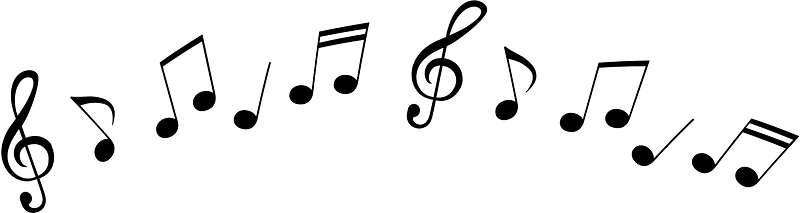

# **-------------------------- Learn To Compose ------------------------------**




**Course:** Introduction To Deep Learning


**Itamar Assaf** 314699612

**Omer Bokobza** 315588178

# **Appetizer**

[Test Yourself](https://drive.google.com/drive/folders/1i1eYx0pQm7Elu3fZQ1rujrDtsmsGoBqf?usp=sharing)  - can you recognize which of the following pieces was composed by Shubert? Which piece composed by our model? 😉




#**Introduction**

Generating music using deep learning models, such as **Generative Adversarial Networks (GANs)**, is a fascinating topic for our project. This subject has gained a lot of interest in recent years (Google, OpenAI, other companies and individuals). The goal of such projects is to generate new and original pieces of music that sound like they were composed by famous composers, such as Bach, Mozart or Beethoven. Alternatively, the goal could be to generate entirely new and original pieces of music that exhibit the style and structure of classical music.

**imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade torch
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import glob
import random
import gc
from torch.autograd import Variable

!pip install midiutil
from midiutil.MidiFile import MIDIFile

!pip install pygame
import pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_path =  "/content/gdrive/My Drive/Colab Notebooks/learn to compose/" ## change me to your path!!! :)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setting a mutual random seed
torch.manual_seed(1)         # Insert any integer
torch.cuda.manual_seed(1)    # Insert any integer

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Dataset**

## **Data Description**

For our model, we found on Kaggle a dataset called 'MusicNet' that contains a collection of 330 freely-licensed classical music recordings. for each piece the recording was preproccessed and converted into csv files that contains represantation of all notes for each piece. The file contains the following information for each note:
* the instrument playing
* start time and end time
* start beat and end beat
* pitch


Additional to the pieces themselves, attached a metadata file that contains information regarding each piece. From this file we will extract the following information:
* ID
* composer
* scale
* ensemble


First, we will upload the meta data of the pieces. For our purposes we would like to separate minor and major pieces from one another for they are treated differently in music composition.

When composing, understanding the difference between major and minor scales is crucial. A scale is a sequence of notes arranged in ascending or descending order. Major scales have a happy, uplifting sound, and are built on a specific pattern of whole and half steps. In contrast, minor scales have a sad, melancholic sound, and are built on a different pattern of whole and half steps. Composers often use these scales to create different moods and emotions in their music, and the choice between major and minor scales can greatly impact the overall feel of a piece and the compositor choices when composing a piece. 

for simplecity, we would also extract only piano pieces and nerrow down our learning to major pieces.

Presented here is an example for how the dataset looks like for Schubert minor pieces:

## **PreProcessing Data**

In [ ]:
# uploading the meta data
meta_data = data = pd.read_csv(drive_path + "musicnet_metadata.csv")

# seperating the data
meta_data = meta_data[meta_data['composition'].str.contains('iano')]
major_pieces = meta_data[meta_data['composition'].str.contains('major')]
minor_pieces = meta_data[meta_data['composition'].str.contains('minor')]

# representing the data
minor_pieces_Schubert = minor_pieces[minor_pieces['composer'].str.contains('Schubert')]
print(minor_pieces_Schubert)

      id  composer              composition  \
9   1749  Schubert  Piano Sonata in A minor   
10  1750  Schubert  Piano Sonata in A minor   
11  1751  Schubert  Piano Sonata in A minor   
12  1752  Schubert  Piano Sonata in A minor   
13  1755  Schubert  Piano Sonata in A minor   
14  1756  Schubert  Piano Sonata in A minor   
15  1757  Schubert  Piano Sonata in C minor   
16  1758  Schubert  Piano Sonata in C minor   
17  1759  Schubert  Piano Sonata in C minor   
18  1760  Schubert  Piano Sonata in C minor   

                                             movement    ensemble    source  \
9                                         1. Moderato  Solo Piano  Museopen   
10                              2. Andante poco mosso  Solo Piano  Museopen   
11  3. Scherzo. Allegro vivace - Trio. Un poco piu...  Solo Piano  Museopen   
12                           4. Rondo. Allegro vivace  Solo Piano  Museopen   
13                                         2. Andante  Solo Piano  Museopen   
14      

Next, we will upload the data from kaggle as cvs files, for each piece represanting it's notes per instrument as an interval:

[start time, end time, instrument, note, start_beat, note_value, id]

At the end a random piece dataframe is presented.


In [ ]:
def upload_files(data_name):
  path =  "/content/gdrive/My Drive/Colab Notebooks/learn to compose/pieces/" + data_name + "/*.csv" 
  pieces = {}
  counter = 0
  for file in glob.glob(path):
    counter = counter + 1
    filename = file.split("/")[-1]   # get the name of the .csv file
    filename = filename.split(".")[0]
    data = pd.read_csv(file)
    data = data[data["instrument"] == 1]
    pieces[filename] = data
  return pieces

df = upload_files("train labels")


piece_name = "1749"
piece = df[piece_name]
print(piece)


      start_time  end_time  instrument  note  start_beat  end_beat  \
0         124382    127454           1    59       0.750     0.125   
1         124382    127454           1    71       0.750     0.125   
2         127454    129501           1    72       0.875     0.125   
3         127454    129501           1    60       0.875     0.125   
4         129501    151518           1    59       1.000     1.000   
...          ...       ...         ...   ...         ...       ...   
5348    30359006  30398429           1    76    1601.000     2.000   
5349    30359006  30398429           1    45    1601.000     2.000   
5350    30359006  30398429           1    33    1601.000     2.000   
5351    30359006  30398429           1    36    1601.000     2.000   
5352    30359006  30398429           1    40    1601.000     2.000   

         note_value  
0     Thirty Second  
1     Thirty Second  
2            Eighth  
3            Eighth  
4           Quarter  
...             ...  
5348 

Now, we set the transpose value of all pieces to the scale of C (minor or major correspondingly) doing so will extend our data set for all major and minor scales and will assist the learning process. We are doing so taking in mind that the transposition does not affect the composition process (e.g. a major scale is a major scale regardless of what note you start it from - later on we will give the option of choosing the scale which will result in a simple transposition).


the mapping for notes represantation is as following:



In [ ]:
key_notes = {
    'C': 0,
    'C-sharp': 1,
    'D-flat': 1,
    'D': 2,
    'D-sharp': 3,
    'E-flat': 3,
    'E': 4,
    'F': 5,
    'F-sharp': 6,
    'G-flat': -6,
    'G': -5,
    'G-sharp': -4,
    'A-flat': -4,
    'A': -3,
    'A-sharp': -2,
    'B-flat': -2,
    'B': -1
}



After separating the data, now it is time for preprocessing and fitting. Our main idea is to treat the data as images of notes: the X-axis is the time axis and the Y-axis is the pitch of the note, when the value of 1 represent the begining of a note, the value of -1 the continuum of a note and zero is no notes at all (this representatin will help us later on with the model - fits to an outcome of the Tanh activation function).



### **Using PreProcessing To Overcome Limitations**

 After uploading the dataset and seperating it into pieces that can operate together as a common ground for the learning process we ran into a problem, only 84 pieces are classified as a major piano piece and that is not a big enough dataset to train a GAN's model. Furthermore, each piece is of different length and to make a uniform data type we would need to adjust the images to one another.

To overcome these two problems we duplicated the pieces, and in a circular form we connected each of them to itself, tail to head, and cut the image into one common size. this way, we got 84 different images of the same size of a relativly long size.

Later on, in the training process we will use the long length to our advantage; each epoch we will randomize a much smaller scope (much smaller then the size of each piece), this way, each time we will get a different part of the pieces and because of the random way of choosing the scope and the different length of each piece we will significantly increase our dataset size.

Here, is a function that converts the data into one big tensor of images as described above:

In [ ]:
def build_note_image(piece,transposition):
  smallest_unit = (1/12)
  num_of_beats = round((piece["start_beat"].iloc[-1] + piece["end_beat"].iloc[-1])/smallest_unit)
  note_image = torch.zeros([1,1,88,26000])   #21 is 0
  ratio = 26000//num_of_beats + 1
  for k in range (ratio):
    for i in range (len(piece)):
      start_beat = int(piece["start_beat"].iloc[i]/smallest_unit)
      end_beat = int((piece["end_beat"].iloc[i]/smallest_unit) + start_beat)
      # print(start_beat,end_beat)
      shift = k * (num_of_beats + 48)
      if (end_beat + shift) >= 26000: break
      note_image[0,0,(piece["note"].iloc[i]-21 + transposition),(start_beat + shift) :(end_beat + shift)] = -1
      note_image[0,0,(piece["note"].iloc[i]-21 + transposition),(start_beat + shift)] = 1
  return note_image # stacked_tensor

def build_all_note_images(df,meta_data):
  i = 0
  for piece_meta in meta_data.iloc:
    try:
      transposition = key_notes[piece_meta.loc['composition'].split(" ")[-2]]
    except:
      print(name + " doesn't have a scale")
      continue
    name = str(piece_meta.loc['id'])
    if name in df:
      images_vec = build_note_image(df[name],transposition)
      if i ==0 :
        stacked_tensor = images_vec
        i = i+1
      else:
        stacked_tensor = torch.cat((stacked_tensor, images_vec), dim=0)
    else:       
        print(name + " does not exist")
  return stacked_tensor

In [ ]:
images_arr = build_all_note_images(df,major_pieces)

2556 does not exist


Here is an example of how a small scope of a music piece image looks like:

the shape of the thorch stack is:torch.Size([84, 1, 88, 26000])
number of images loaded:84


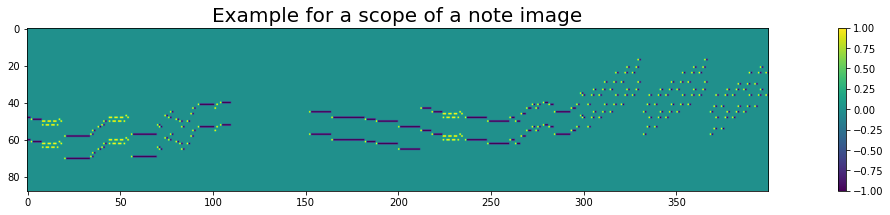

In [ ]:
# please notice here you can save and load the data
torch.save(images_arr, drive_path + 'my_tensor3.pt')
images_arr = torch.load(drive_path + 'my_tensor3.pt')
images_arr = images_arr.to(device)

print('the shape of the thorch stack is:' + str(images_arr.shape))
print('number of images loaded:' + str(len(images_arr)))

plt.figure(figsize=(25,3))
plt.imshow(images_arr[0,0,:,400:800].detach().cpu())
plt.title("Example for a scope of a note image", size = 20)
plt.colorbar()

In order to get even better result, with our limited resources, we would like to assist the learning process even more in the preprocessing portion of the project. 

By using fundametals of music theory, in this section we are going to create the music 'netural' filters (scale and chords filters). In classical music the scale and chords consist of fixed intervals, we will use this fact to our advantage and create the chords image and the scale image by multipling the piece image by the scale matrix and right after by the chords matrix, both consists these intervals



Text(0.5, 1.0, 'Chords interval matrix')

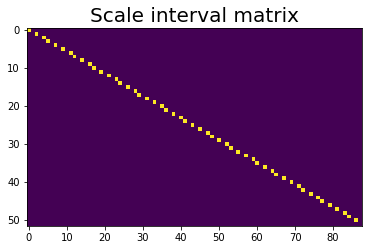

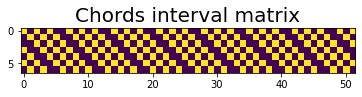

In [ ]:
def create_major_scale_filter():
  all_scale = np.zeros((7,12))
  for i, j in enumerate([0,2,4,5,7,9,11]):
      all_scale[i, j] = 1
  all_scale = np.kron(np.eye(8), all_scale)[:52,:88]
  all_scale = torch.from_numpy(all_scale)
  return Variable(all_scale, requires_grad = True)

def create_minor_scale_filter():
  all_scale = torch.zeros(88)
  for i in range(8):
    for j in [0,2,3,5,7,9,10]:
      if (i*12 + j < 88):
        all_scale[i*12 + j] = 1
  return all_scale

minor_scale = create_minor_scale_filter()
major_scale = create_major_scale_filter()

def scale_chords_filter():
  matrix = np.kron(np.ones(9),np.eye(7))
  matrix = matrix + np.roll(matrix, 2) + np.roll(matrix, 4)
  matrix = torch.from_numpy(matrix[:,7:59])
  if torch.cuda.is_available():
    matrix = matrix.to(device)
  else:
    matrix = matrix.to(device)
  return matrix


chords_filter = scale_chords_filter()
matrix = np.kron(np.ones(9),np.eye(7))
matrix = matrix + np.roll(matrix, 2) + np.roll(matrix, 4)
matrix = torch.from_numpy(matrix[:,7:59])
plt.figure()
plt.imshow(major_scale.detach().cpu())
plt.title("Scale interval matrix", size = 20)
plt.figure()
plt.imshow(matrix)
plt.title("Chords interval matrix", size = 20)


Next, we will create the filters as CNN models, so we can easily use them durring the training process. We should also note, that because we can't determain the chords with a full certainty we will also add a Softmax function after multiplying by the coresponding matrix to give us a better correlation to the probability of each chord to apear:

In [ ]:
class scale_conv(nn.Module):
  def __init__(self, scale):
      super(scale_conv, self).__init__()
      self.scale = scale.to(device).float()
      # setting the matrix as a leaf variable that requires grad is very important for the gradient flow later on
      self.scale = Variable(self.scale, requires_grad = True)

  def forward(self, image):
      image = torch.matmul(self.scale,image)
      return image

class chords_conv(nn.Module):
  def __init__(self):
      super(chords_conv, self).__init__()
      self.matrix = np.kron(np.ones(9),np.eye(7))
      self.matrix = self.matrix + np.roll(self.matrix, 2) + np.roll(self.matrix, 4)
      self.matrix = torch.from_numpy(self.matrix[:8,7:59]).to(device).float()
      # setting the matrix as a leaf variable that requires grad is very important for the gradient flow later on
      self.matrix = Variable(self.matrix, requires_grad = True)

  def forward(self, image):
      image = torch.matmul(self.matrix,image)
      image = torch.softmax(5*image , dim = -2)
      return image

Here is an example of the image would look like after going through the filter:

Text(0.5, 1.0, 'Chords image')

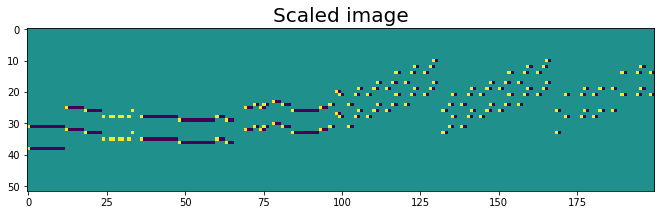

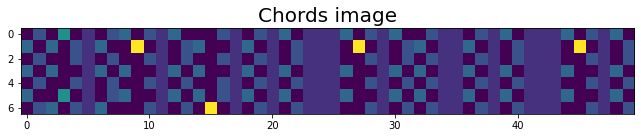

In [ ]:
SC = scale_conv(major_scale)
CC = chords_conv().to(device)

scaled_image = SC(images_arr[:1,:,:,:])
chords_image = CC(scaled_image)

plt.figure(figsize=(25,3))
plt.imshow(scaled_image[0,0,:,600:800].detach().cpu())
plt.title("Scaled image", size = 20)
plt.figure(figsize=(11,3))
plt.imshow(chords_image[0,0,:,750:800].detach().cpu())
plt.title("Chords image", size = 20)

We would also like the filters to serve us in the opposite process (from chords to scale to image in the generator). Therefore, we will create the opposite models as well:

In [ ]:
class de_scale_conv(nn.Module):
  def __init__(self, scale):
      super(de_scale_conv, self).__init__()
      self.scale = scale.permute(1,0).to(device).float()
      # setting the matrix as a leaf variable that requires grad is very important for the gradient flow later on
      self.scale = Variable(self.scale, requires_grad = True)

  def forward(self, image):
      image = torch.matmul(self.scale,image)
      return image

class de_chords_conv(nn.Module):
  def __init__(self):
      super(de_chords_conv, self).__init__()
      self.matrix = np.kron(np.ones(9),np.eye(7))
      self.matrix = self.matrix + np.roll(self.matrix, 2) + np.roll(self.matrix, 4)
      self.matrix = torch.from_numpy(self.matrix[:8,7:59]).permute(1,0).to(device).float()
      # setting the matrix as a leaf variable that requires grad is very important for the gradient flow later on
      self.matrix = Variable(self.matrix, requires_grad = True)

  def forward(self, image):
      image = torch.matmul(self.matrix,image)
      return image

We would also note that the opposite operation does not give us the original image (that makes scence, for we are loosing information when applying the scale and chords filter - smaller image - less information), instead we get a smeared image. here is how the reconstracted from chords image looks like:

Text(0.5, 1.0, 'Descaled image')

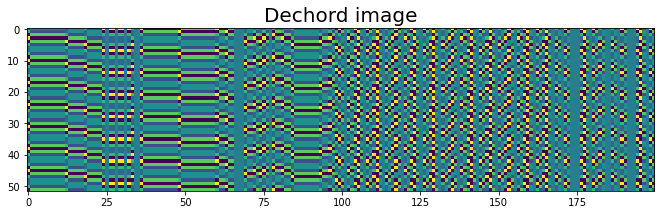

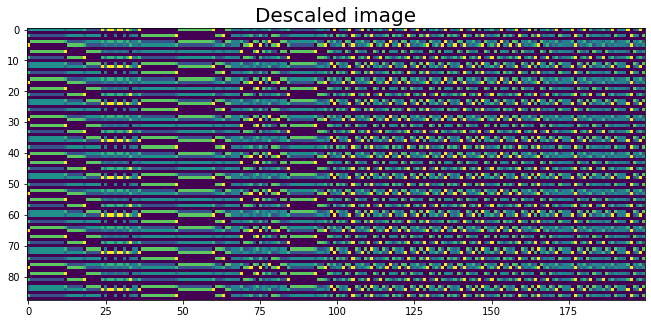

In [ ]:
DSC = de_scale_conv(major_scale)
DCC = de_chords_conv()

dechord_image = DCC(chords_image)
descaled_image = DSC(dechord_image)

plt.figure(figsize=(25,3))
plt.imshow(dechord_image[0,0,:,600:800].detach().cpu())
plt.title("Dechord image", size = 20)
plt.figure(figsize=(30,5))
plt.imshow(descaled_image[0,0,:,600:800].detach().cpu())
plt.title("Descaled image",size = 20)

# **Limitations**

* **Small Dataset:** As stated above, our main limitation is the quntity of data. in our preprocessing section we tried to find solutions to this problem by lengthening the images and later on using one sized small scope with random starting point to view the image. this way each time we will get a different image and differnt batches.

* **Resources Limitations:** Even though our dataset is relativly small we got big tensors that requires large memory usage, and GPU computation power. to deal with that problem, first, we had to adjust our code to be more efficient when generating the data and saving it. We did so, at the Preprocessing section, by creating all data as one big tensor, saving it, and seperatly uploading it. Second, while training the model we would like to reduce the number of 'trash' images to a minimum. Therefore we would have to avoid saving example images durring the process. Last, we acquired from google the Jupyter notebook colabpro in order to get better prefoemances and a larger memory span.

* **Time Limitations:** Building a generative model is a complex task that requires time, patient,trial and error, research and more. aproaching this task in the little time we have with other obligations as student we would have to be efficient and understand that compremises must be made durring the process.  



#**VAE - Old Model**


[2] In our first attempt we tried using the VAE model (very similar to the one we used in assignment 4) and after a few tries decided to abandon it (more about this decision is in the following section). Unfortunatly due to the colab limitations and different preprocessing between the models we could not present both. However, we did decide to leave this attempt here just for illustration:

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, batch_size, input_channels, num_hiddens, latent, scale):
#         super(Encoder, self).__init__()
#         self.num_hiddens = num_hiddens
#         self.latent = latent
#         self.scale = scale
#         self.scale_conv = scale_conv
#         self.chords_conv = chords_conv
#         self.batch_size = batch_size
#         self.block_scale = nn.Sequential(
#             self.scale_conv(scale = self.scale),
#             nn.Conv2d(input_channels, num_hiddens, kernel_size=(3,48), stride=(1,6),padding = (1,41)),
#             #(52,2600)->(52,440)
#             nn.BatchNorm2d(num_hiddens),
#             nn.ReLU(),
#             nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(12,10), stride=(6,4),padding = (1,3)),
#             #(52,440)->(8,110)
#             nn.BatchNorm2d(num_hiddens * 2),
#             nn.ReLU())
        
#         self.block_adjust_2_scale = nn.Sequential(
#             nn.Conv2d(input_channels, num_hiddens, kernel_size=(8,48), stride=(2,6),padding = (11,41)),
#             #(88,2600)->(52,440)
#             nn.BatchNorm2d(num_hiddens),
#             nn.ReLU(),
#             nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(12,10), stride=(6,4),padding = (1,3)),
#             #(52,440)->(8,110)
#             nn.BatchNorm2d(num_hiddens * 2),
#             nn.ReLU())

#         self.block_chords = nn.Sequential(
#             self.scale_conv(scale = self.scale),
#             self.chords_conv(batch_size, input_channels, self.scale),

#             nn.Conv2d(input_channels, num_hiddens, kernel_size=(3,48), stride=(1,6),padding = (1,41)),
#             #(8,2600)->(8,440)
#             nn.BatchNorm2d(num_hiddens),
#             nn.ReLU(),
#             nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(3,10), stride=(1,4),padding = (1,3)),
#             #(8,440)->(8,110)
#             nn.BatchNorm2d(num_hiddens * 2),
#             nn.ReLU())
        
#         self.unify = torch.cat

#         self.block_channels = nn.Sequential(
#             nn.Conv2d(num_hiddens*2, num_hiddens * 4, kernel_size=(4,7), stride=(2,5), padding = (1,1)),
#             #(3,8,110)->(3,4,22)
#             nn.BatchNorm2d(num_hiddens * 4),
#             nn.ReLU())
        
#         self.fc_mu = nn.Linear(3*4*num_hiddens*4*22,latent)     # Insert the input size
#         self.fc_logvar = nn.Linear(3*4*num_hiddens*4*22,latent) # Insert the input size

#     def forward(self, inputs):
#         # inputs.view(-1)
#         channel_1 = self.block_scale(inputs)
#         # print(channel_1.shape)
#         channel_2 = self.block_adjust_2_scale(inputs)
#         # print(channel_2.shape)
#         channel_3 = self.block_chords(inputs)
#         # print(channel_3.shape)

#         channels = torch.cat((channel_1, channel_2, channel_3),2) #channel_3
#         channels = self.block_channels(channels)
#         # print(channels.shape)
#         channels = channels.view(channels.size(0), -1)
#         mu = self.fc_mu(channels)##!!!!!!!!!!!
#         logvar = self.fc_logvar(channels)#!!!!!!!!!!!
#         return mu, logvar 

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self, batch_size, input_channels, num_hiddens, latent, scale):
#         super(Decoder, self).__init__()
#         self.num_hiddens = num_hiddens
#         self.latent = latent
#         self.scale = scale
#         self.de_scale_conv = de_scale_conv
#         self.de_chords_conv = de_chords_conv
#         self.batch_size = batch_size
#         self.fc_dec = nn.Linear(latent, 208) # Insert the output size - WAS num_hiddens * 8 * 8
#         self.dropout = nn.Dropout(0.3)

#         self.block1 = nn.Sequential(
#             nn.ConvTranspose2d(input_channels, num_hiddens, kernel_size=(5,7), stride=(1,5),padding = (1,1)), ## input_channels???
#             #(2,104) -> (4,520)
#             nn.BatchNorm2d(num_hiddens),
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, kernel_size=(4,7), stride=(2,5),padding = (1,1)),
#             #(4,520) -> (8,2600)
#             nn.BatchNorm2d(num_hiddens // 2),
#             nn.LeakyReLU())
#         #8,6,12,1
#         self.block_adjust = nn.Sequential(
#             nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(6,3), stride=(12,1),padding = (1,1)),
#             #(8,2600) -> (88,2600)
#             nn.BatchNorm2d(num_hiddens // 4),
#             nn.ReLU())

#         self.block_chords = nn.Sequential(
#             self.de_chords_conv(batch_size, input_channels, self.scale),
#             nn.Dropout(0.3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(6,3), stride=(2,1),padding = (10,1)),
#             #(52,2600) -> (88,2600)
#             nn.BatchNorm2d(num_hiddens // 4),
#             nn.ReLU())
        
#         self.block_scale = nn.Sequential(
#             self.de_chords_conv(batch_size, input_channels, self.scale),
#             self.de_scale_conv(scale = self.scale))

#         self.block_channels = nn.Sequential(
#             nn.Conv2d(256, out_channels=4,kernel_size=(87,121), stride=(1,1), padding=(43,60)),
#             nn.Dropout(0.3),
#             nn.BatchNorm2d(4),
#             nn.ReLU(),
#             nn.Conv2d(4, 1,kernel_size=(87,121), stride=(1,1), padding=(43,60)),
#             # nn.Dropout(0.4),
#             # nn.BatchNorm2d(4),
#             # nn.ReLU(),
#             # nn.Conv2d(2, 1,kernel_size=(87,121), stride=(1,1), padding=(43,60)),
#             # nn.Dropout(0.5),
#             #(88,2600) -> (88,2600)
#             nn.Tanh())  #THE OUTPUT SHOULD BE BETWEEN [0,1]


#     def forward(self, inputs):
#         print("start_decoding")
#         channels = self.fc_dec(inputs)
#         channels = channels.view(channels.size(0), 1, 2, 104)
#         channels = self.block1(channels)
#         print(channels.shape)
#         channel_1 = self.block_scale(channels)
#         print(channel_1.shape)
#         channel_2 = self.block_adjust(channels)
#         print(channel_2.shape)
#         channel_3 = self.block_chords(channels)
#         print(channel_3.shape)       

#         channels = torch.cat((channel_1, channel_2, channel_3),1) #channel_3
#         x_rec = self.block_channels(channels)
        
#         return x_rec

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, batch_size, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, scale):
#         super(VAE, self).__init__()
#         self.encode = Encoder(batch_size = batch_size, input_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent, scale = scale)
#         self.decode = Decoder(batch_size = batch_size, input_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent, scale = scale)

#     # Reparametrization Trick
#     def reparametrize(self, mu, logvar):
#       std = torch.exp(0.5 * logvar)
#       eps = torch.randn_like(std)     
#       return eps.mul(std).add_(mu) # z = mu + Tr(sigma)*epsilon

#     # Initialize Weights
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
#                 m.weight.data.normal_(mean, std)
#                 m.bias.data.zero_()

#     def forward(self, x):
#         # YOUR CODE GOES HERE:
#         mu, logvar = self.encode(x)
#         z = self.reparametrize(mu, logvar)
#         x_rec = self.decode(z)
#         return x_rec , mu, logvar

In [ ]:
# def vae_loss(x_recon, x, mu, logvar, beta):
#     MSE = nn.MSELoss(reduction = 'sum')
#     KLD = torch.mean(-0.5*torch.sum(1+logvar-logvar.exp()-mu.pow(2),dim= -1),dim=0)
#     print(x_recon.shape,x.shape)
#     BCE = MSE(x_recon,x)/len(x_recon)
#     loss = KLD*beta + BCE
#     return loss

In [ ]:
# learning_rate = 0.001
# batch_size = 10
# num_epochs = 30 # was 10 
# dataset_size = 84 # How many data samples to use for training, 30,000 should be enough.

# #VAE Class inputs: 
# enc_in_chnl = 1
# enc_num_hidden = 32
# dec_in_chnl = 1
# dec_num_hidden = 256

In [ ]:
# def train(images, num_epochs,batch_size,dataset_size,model,learning_rate, checkpoint_path = None, beta = 3):
#     '''  
#     This is a starter code for the training process. You can modify it for your 
#     own conveinient.
#     num_epochs - number of training epochs
#     batch_size - size of the batches
#     dataset_size - How many training samples to use. 
#     model - The model you are training.   

#     Note: decide what are the outputs of the function. 
#     '''

#     # Your code goes Here:
#     #criterion = vae_loss() # ****OMER*****
#     optimizer = torch.optim.Adam(model.parameters(),
#                            lr = learning_rate)
       
#     iters, train_loss, val_loss_arr  = [], [] ,[]
#     n = 0
#     for epoch in range(num_epochs):
#       indeces = torch.randperm(dataset_size)

#       print(f"starting epoch: {epoch}")
#       # model.train()
#       for batch_idx in range(dataset_size//batch_size):
#           model.train()
#           starting_point = random.randint(0,23399)
#           batch = images[indeces,:,:,:][batch_idx * batch_size : (batch_idx + 1) * batch_size,:,:,starting_point:starting_point + 2600]
#           # print(imgs)
#           if torch.cuda.is_available():
#             batch = batch.to(device)
#           else:
#             batch = batch.to(device)
#           optimizer.zero_grad() # I CHANGE!! (Omer)
#           rec_imgs , mu, logvar = model(batch)
#           loss = vae_loss(rec_imgs, batch, mu, logvar, beta)
#           loss.backward()
#           optimizer.step()  
#           #n += 1
#           if batch_idx % 5 == 0:
#               print(f"Batch {batch_idx}. [Train Loss {loss}]")
#               plt.figure(batch_idx)
#               plt.subplot(1,2,1)
#               plt.imshow(batch.cpu().detach().numpy()[0,0,:,::32])
#               plt.subplot(1,2,2)
#               plt.imshow(rec_imgs.cpu().detach().numpy()[0,0,:,::32])
#               plt.show()
#           # Since the dataset is large, train on 'dataset_size' samples.
#           if dataset_size//batch_size == batch_idx: 
#               print("break")
#               break
#         # Validation set
#       #val_iters.append(n)
#       # with torch.no_grad():
#       #     model.eval()     
#       #     for batch_idx, batch in enumerate(test_loader):
#       #         img, _ = batch
#       #         if torch.cuda.is_available():
#       #           img = img.to(device)
#       #         else:
#       #           img = img.to(device)
#       #         rec_img , mu, logvar = model(img)
#       #         val_loss = vae_loss(rec_img, img, mu, logvar, beta)

#       iters.append(epoch)
#       train_loss.append(float(loss))
#       # val_loss_arr.append(float(val_loss))

#       print(f"Epoch {epoch}. [Val Loss **to be entered] [Train Loss {loss}]")

#       if (checkpoint_path is not None) and epoch >= 0:
#           torch.save(model.state_dict(), checkpoint_path.format(epoch))

#             # increment the iteration number
#     return iters , train_loss , val_loss_arr

In [ ]:
# def plot_learning_curve(iters, train_loss, val_loss):
#     """
#     Plot the learning curve.
#     """
#     plt.figure()
#     plt.title("Learning Curve: Loss per Iteration")
#     plt.plot(iters, train_loss, label="Train")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend(loc='best')
#     plt.show()

#     plt.figure()
#     plt.title("Learning Curve: Loss per Iteration")
#     plt.plot(iters, val_loss, label="Validation")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend(loc='best')
#     plt.show()

In [ ]:
# latent1 = 55
# # del model_1
# # torch.cuda.empty_cache()
# if torch.cuda.is_available():
#     model_1 = VAE(batch_size, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1, major_scale).to(device)
#     model_1.weight_init(mean=0, std=0.02)
# else:
#     model_1 = VAE(batch_size, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1, major_scale)
#     model_1.weight_init(mean=0, std=0.02)

# optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [ ]:
# PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models/'
# # del batch
# # torch.cuda.empty_cache()
# iters , train_loss , val_loss = train(images_arr, num_epochs,batch_size,dataset_size,model_1,learning_rate, checkpoint_path = PATH_TO_SAVE_MODEL + "zibi{}.pk", beta = 0.1)


# **Network - GAN Model**

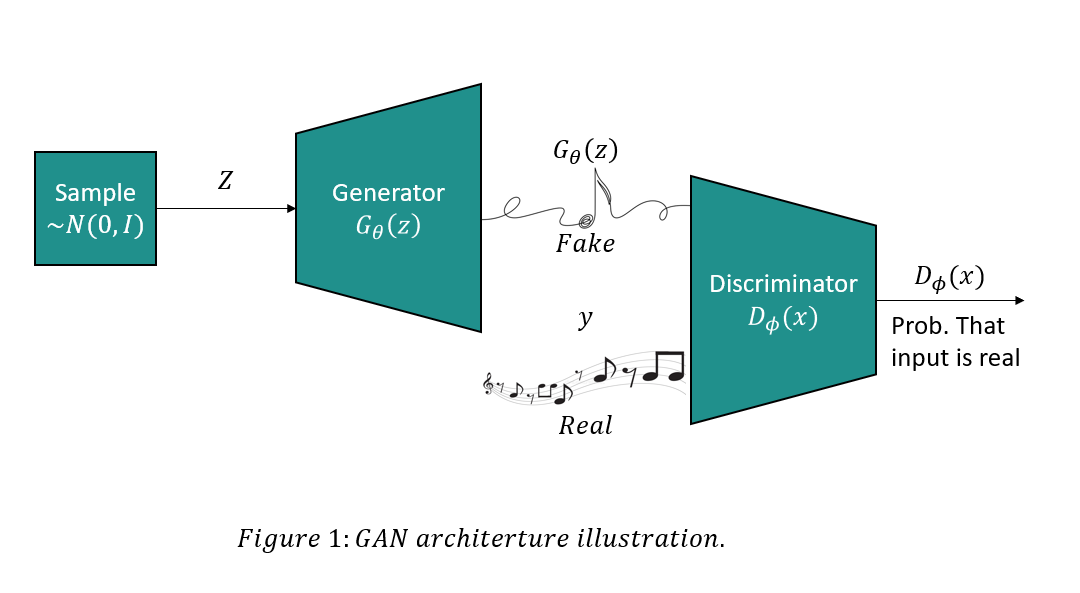

## **Motivation**

Our first trial was using VAE, our choise of VAE was due to the limitations listed above. We made the assumption that VAE will give us better results under the limited dataset and computational power. however, our tries came up empty. After building the encoder and decoder and running the model a few times with different hyperparameter the model always converged into a black image (no notes at all). After doing some brief evaluation of these results we got to the conclusion that these results makes scene. We treated the pieces as images and while doing so we assumed that pixels in the image has large correlation to their neighbors but that is not the case for note images. the correlation is much larger to previous note and notes of the same chords and scale. When using VAE, because of the poor correlation between nighbor pixels, the usage of divergence and MSE in the loss function, and the fact that only a few notes are being played at a time, converging to no notes at all makes a lot of scence.

After coming to this conclusion we decided to try using a GAN model. GANs have some unique advantages over VAEs that make them preferable for generative modeling in certain applications. GANs can generate more realistic samples, learn more complex data distributions, have a more intuitive training process, and are more versatile in their applications. These advantages are due to the use of a discriminator network, which helps the generator network to produce samples that are difficult to distinguish from real data. In contrast, VAEs rely on a probabilistic encoder and decoder to learn the underlying distribution, which makes them less suitable for generating complex and high-dimensional data.






##  **GAN - Implemenation**



GANs are neural networks that consist of two networks: a generator network and a discriminator network. The generator network learns to create new data that is similar to the training data, while the discriminator network learns to distinguish between real data and the fake data generated by the generator network.

During training, the generator network takes random noise as input and generates a fake sample, which is then fed into the discriminator network along with a real sample from the training data. The discriminator network then outputs a probability indicating whether the sample is real or fake. The generator network is trained to minimize the probability of the discriminator correctly identifying the fake sample, while the discriminator network is trained to maximize its ability to correctly distinguish between real and fake samples.

This process is repeated iteratively until the generator network produces samples that can be mistaken for real data, and the discriminator network is having a harder time differentiating between real and fake samples. The final generator network can then be used to generate new data that is similar to the training data.

### **Discriminator**

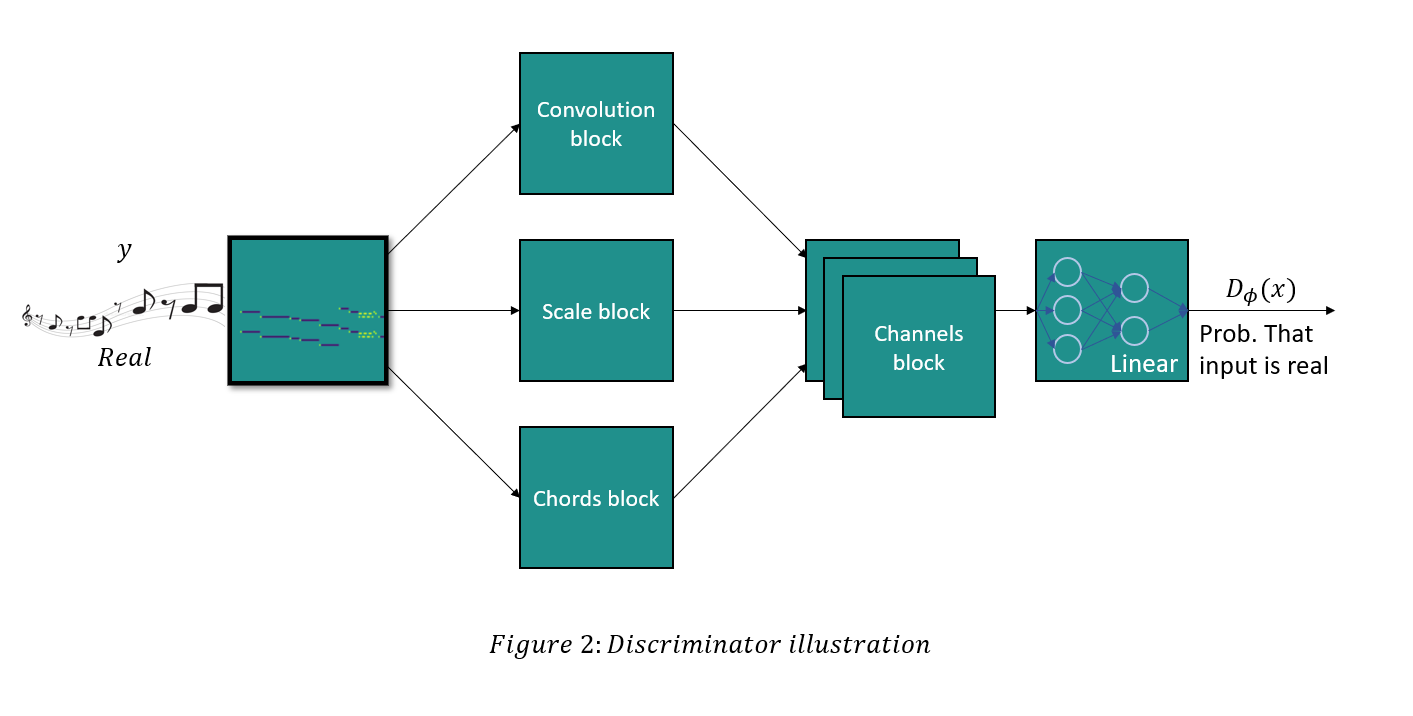

Our discrimnator consist of 4 blocks and other layers:

* **Convolution block:** Using two convolutional layers each followed by Batch normalization and activation function (LeakyReLU) we will be able to learn correlation between neighbor pixels which hopefully will help the nural network learn rhythm, patterns, octave location and more

* **Scale block:** Using our scale filter, followed by two convolutional layers each followed by Batch normalization and activation function (LeakyReLU) we will be able to learn correlation between neighbor notes.

* **Chords block:** Using our scale filter, followed by our chords filter, followed by two convolutional layers each followed by Batch normalization and activation function (LeakyReLU) we will be able to learn correlation between neighbor chords and harmonious move.

* **Channels block:** after applying all blocks we would like to concatenate all layers together and aplly an additional block in order to find the correlation between all three: chords, scale, and rhythm. we would do so with an aditional convolutional layer followed by Batch normalization and activation function (LeakyReLU).

Finally, we would use a linear layer to give us an output of size 1 (rather the image is real or not) 



In [ ]:
class Discriminator(nn.Module):
    #52,12,6,1
    def __init__(self, batch_size, input_channels, num_hiddens, output_size, scale):
        super(Discriminator, self).__init__()
        self.num_hiddens = num_hiddens
        self.output_size = output_size
        self.scale_conv = scale_conv(scale)
        self.chords_conv = chords_conv()
        self.batch_size = batch_size
        self.dropout = nn.Dropout(0.3)

        self.block_scale = nn.Sequential(
            self.scale_conv,
            nn.Conv2d(input_channels, num_hiddens, kernel_size=(3,48), stride=(1,6),padding = (1,41)),
            #(52,2600)->(52,440)
            nn.BatchNorm2d(num_hiddens),
            nn.LeakyReLU(),
            # self.dropout(),
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(12,10), stride=(7,4),padding = (1,3)),
            #(52,440)->(7,110)
            nn.BatchNorm2d(num_hiddens * 2),
            nn.LeakyReLU())
        
        self.block_adjust_2_scale = nn.Sequential(
            nn.Conv2d(input_channels, num_hiddens, kernel_size=(8,48), stride=(2,6),padding = (11,41)),
            #(88,2600)->(52,440)
            nn.BatchNorm2d(num_hiddens),
            nn.LeakyReLU(),
            # self.dropout(),
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(12,10), stride=(7,4),padding = (1,3)),
            #(52,440)->(7,110)
            nn.BatchNorm2d(num_hiddens * 2),
            nn.LeakyReLU())
            

        self.block_chords = nn.Sequential(
            self.scale_conv,
            self.chords_conv,

            nn.Conv2d(input_channels, num_hiddens, kernel_size=(3,48), stride=(1,6),padding = (1,41)),
            #(7,2600)->(7,440)
            nn.BatchNorm2d(num_hiddens),
            nn.LeakyReLU(),
            # self.dropout(),
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(3,10), stride=(1,4),padding = (1,3)),
            #(7,440)->(7,110)
            nn.BatchNorm2d(num_hiddens * 2),
            nn.LeakyReLU())

        self.block_channels = nn.Sequential(
            nn.Conv2d(num_hiddens*2*3, num_hiddens * 4, kernel_size=(4,7), stride=(2,5), padding = (1,1)),
            #(7,110)->(4,22)
            nn.BatchNorm2d(num_hiddens * 4),
            nn.LeakyReLU())
            
        
        self.fc_out = nn.Linear(int(4*num_hiddens*22*3), output_size)     # Insert the input size

    def forward(self, inputs):
        channels = torch.cat((self.block_scale(inputs), self.block_adjust_2_scale(inputs), self.block_chords(inputs)),-3) #channel_3
        channels = self.block_channels(channels)
        channels = channels.view(channels.size(0), -1)
        
        return self.fc_out(channels)
# print(calc_h_conv(7,3,2,1))

In [ ]:
def calc_h_trans(h_in,kernel_size,stride,padding):
  return (h_in - 1) * stride - 2 * padding + kernel_size

def calc_h_conv(h_in,kernel_size,stride,padding):
  return (h_in + 2 * padding - kernel_size) / stride + 1

print(calc_h_trans(52,5,1, 2))

52


### **Generator models**

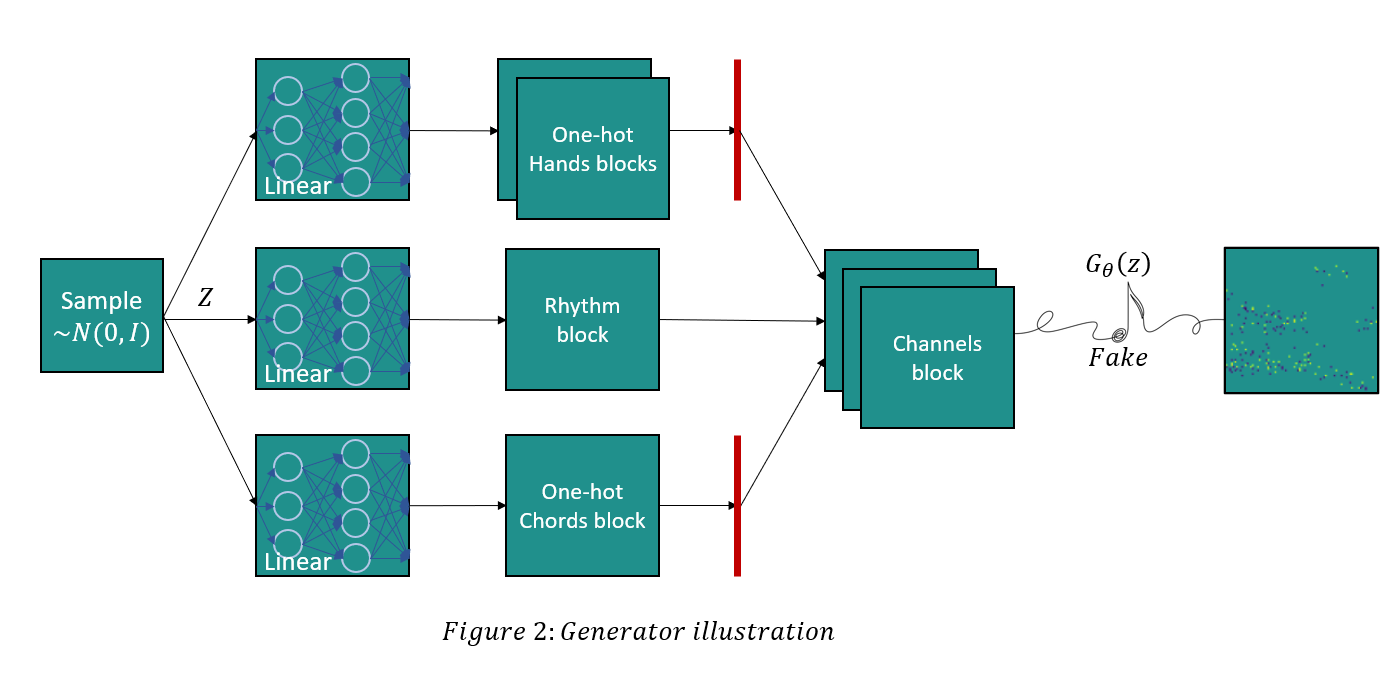

Our Generator consist of 5 blocks and other layers:

* **Rhythm block:** Using a linear layer followed by two Transposition layers each followed by Batch normalization and activation function (Sigmoid) we will be able to learn correlation between neighbor pixels which hopefully will help the Generator learn rhythm and patterns

* **2 Hand blocks:** By using a linear layer followed by a one-hot represantation and multiplying by a matrix that represant the locations of the octaves across the keyboard, we are hoping to give our model the ability to focus on one area at a time(one hand roughly can cover a whole octave). This part is very tricky because using one-hot represantation this way is not gradable. In order to overcome this challange we decided to try and treat this block as an individual model and train it seperatly.

* **Chords block:** Very similar to the hand blocks, by using a linear layer followed by a one-hot represantation and multiplying by a matrix that represant the chords across the keyboard, we are hoping to give our model the ability to use currect notes that are on scale and acording to a certain chords movement. This part was very tricky as well because using one-hot represantation this way is not gradable. In order to overcome this challange we decided to try and treat this block as an individual model as well and train it seperatly.

* **Channels block:** after applying all blocks we used torch.mul() between the chords, hands, and rhythm in order to place the chords in the hand position and play it in the given rhythm. Using the nn.functional.Variable we made sure the output of our seperated models will be gradable and only after the torch.mul() we continued our learning process and apllyed an additional block of transposition and convolution both working only on the Time-axis (rhythm) to avoid any changes to the chords and hand position, both are followed by activation layers when the last one is Tanh().

Finally, we used the round() function to get discrete values (-1, 0, 1)




Building the generator revealed to be a challanging task and raised a lot of problems, some we managed to overcome and some we did not and decided to abandon:

*  after establishing the basic model, we wanted it to contain RNN layers as part of the generation of the chords and hands movement and as part of the rhythm block for all three are time correlated. We had to abandon the idea of using RNN after failing to train the model proparly with it in a few different attempts and because of lack of time. we tend to try and combine it again after this semester on our own.

* The idea of seperating the Generator into 4 different models came after modeling the Generator only with the convolution model (rhythm) in order to try and make a more complex model. while doing so we encountered the problem of backpropogation through one-hot represantation. we tried overcoming this problem by seperating the Generator and back propagating through each model seperatly. However, this solution doesn't seem to work, we are certain that there are better solutions that will give us better results. we tend to explore this options as well. (We chose to keep the model with this separation because it doesn't seem to effect the convergance of the main branch and gave us some interesting insights)

In [ ]:
hands_matrix = Variable(torch.kron(torch.eye(8),torch.ones(12,1))[:88,:], requires_grad = True)
# plt.figure()
# plt.imshow(hands_matrix)
class RNNHands(nn.Module):
    def __init__(self, input_size = 200, rnn_layers = 4, hidden_size = 10):
        super(RNNHands, self).__init__()
        self.Linear = nn.Linear(input_size,hidden_size).to(device)
        self.fc = nn.Linear(hidden_size,216)
        self.lstm = nn.LSTM(hidden_size, hidden_size, rnn_layers, batch_first = True, dropout = 0.3)
        # self.lstm2 = nn.LSTM(5, 1,rnn_layers, batch_first = True).to(device)
        self.sigmoid = nn.LeakyReLU(0.7)
        self.relu = nn.Tanh()
        self.dropout= nn.Dropout(0.3)

    def forward(self, x, hidden=None):
        hands = self.Linear(x.to(device))
        hands = self.relu(hands)
        hands = self.dropout(hands)
        # hands, _ = self.lstm(hands.unsqueeze(1))
        # hands = self.sigmoid(hands)
        hands = self.fc(hands.unsqueeze(1))
        # chords = self.sigmoid(chords)
        # chords, _ = self.lstm2(chords, hidden)
        hands = self.sigmoid(hands)

        return hands.to(device)

class OneHotHands(nn.Module):
    def __init__(self):
        super(OneHotHands, self).__init__()
        self.hands_matrix = hands_matrix.to(device)#Variable(self.hands_matrix, requires_grad = True)
        self.onehot = nn.functional.one_hot
        
    def forward(self,x):
        x = x + (3/7)
        x = torch.clamp(x ,min = 0, max = 1)
        x = torch.round (x * 7).long()
        # print(x.shape)
        hand = self.onehot(x, num_classes = 8).permute(0,1,3,2).float()
        # print(hand.shape)
        # print(hand.shape)
        hand = torch.matmul(self.hands_matrix.reshape(1,1,88,8).to(device),hand)
        # print(hand.shape)
        # plt.figure()
        # plt.imshow(hand.detach().cpu()[0,0,:,:])
        # plt.show()
        return hand.to(device)

In [ ]:
class RNNchords(nn.Module):
    def __init__(self, input_size = 200, rnn_layers = 4, hidden_size = 10):
        super(RNNchords, self).__init__()
        self.Linear = nn.Linear(input_size,hidden_size)
        self.fc = nn.Linear(hidden_size,54)
        self.lstm = nn.LSTM(hidden_size, hidden_size, rnn_layers, batch_first = True, dropout = 0.3)
        # self.lstm2 = nn.LSTM(5, 1,rnn_layers, batch_first = True).to(device)
        self.sigmoid = nn.ReLU()
        self.relu = nn.Sigmoid()
        self.dropout= nn.Dropout(0.3)

    def forward(self, x, hidden=None):
        chords = self.Linear(x.to(device))
        chords = self.relu(chords)
        chords = self.dropout(chords)
        # chords, _ = self.lstm(chords.unsqueeze(1))
        # chords = self.sigmoid(chords)
        chords = self.fc(chords.unsqueeze(1))#.unsqueeze(1)
        # chords = self.sigmoid(chords)
        # chords, _ = self.lstm2(chords, hidden)
        chords = self.sigmoid(chords)
        return chords.to(device)
        
class OneHotChords(nn.Module):
    def __init__(self):
        super(OneHotChords, self).__init__()
        self.onehot = nn.functional.one_hot
    
    def forward(self, x):
        x = torch.clamp(x,max = 1)
        x = torch.round (x * 6).long()
        x = self.onehot(x, num_classes = 7).permute(0,1,3,2).float()
        # plt.figure()
        # plt.imshow(x.detach().cpu()[0,0,:,:])
        # plt.show()
        return x.to(device)

In [ ]:
class RNNrythem(nn.Module):
    def __init__(self, input_size = 200, rnn_layers = 4):
        super(RNNrythem, self).__init__()
        self.Linear = nn.Linear(input_size,7*26)
        self.leakyrelu = nn.LeakyReLU(0.1)
        # self.lstm = nn.LSTM(1, 7, rnn_layers, batch_first = True, dropout = 0.3)

    def forward(self, x, hidden=None):
        rythem = self.Linear(x)
        rythem = self.leakyrelu(rythem)
        # rythem, _ = self.lstm(rythem)
        rythem = rythem.view(x.size(0),1,7,26)
        # rythem = rythem.view(rythem.size(0), 1, 7, 26)

        return rythem.to(device)

### **Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self, batch_size, input_channels, num_hiddens, z_size, scale):
        super(Generator, self).__init__()
        self.de_scale_conv = de_scale_conv(scale)
        self.de_chords_conv = de_chords_conv()
        # self.rnnrighthand = RNNHands(input_size=z_size)
        # self.rnnlefthand = RNNHands(input_size=z_size)
        self.fc_dec = nn.Linear(z_size, z_size)
        self.rnnrythem = RNNrythem(z_size)
        self.sigmoid = nn.Sigmoid()
        self.rnnchords = RNNchords()
       
        self.block_adjust = nn.Sequential(
            nn.ConvTranspose2d(1, num_hiddens // 2, kernel_size=(4,6), stride=(1,2),padding = (1,1)),#6,4,1
            #(7,26) -> (8,54)
            nn.Dropout(0.3),
            nn.BatchNorm2d(num_hiddens // 2),
            nn.Sigmoid(),
            nn.ConvTranspose2d(num_hiddens//2,  54, kernel_size=(6,6), stride=(12,4),padding = (1,1)),#6,4,1
            #(8,54) -> (88,216)
            nn.Dropout(0.3),
            nn.BatchNorm2d(54),
            nn.Sigmoid())

        self.block_scale = nn.Sequential(
            self.de_chords_conv,
            nn.Dropout(0.3),
            nn.ConvTranspose2d(1, num_hiddens // 8, kernel_size=(5,6), stride=(1,4),padding = (2,1)),#1,1,0
            #(52,54) -> (52,216)
            nn.Dropout(0.3),
            # nn.LeakyReLU(0.1),
            nn.BatchNorm2d(num_hiddens // 8),
            nn.Conv2d(num_hiddens//8, 1, kernel_size=(5,3), stride=(1,1),padding = (2,1)),############ was 311 5 1 2
            #(88,216)->(88,216)
            self.de_scale_conv,
            nn.Dropout(0.3))
        
        self.block_channels = nn.Sequential(
            nn.ConvTranspose2d(108, num_hiddens // 4, kernel_size=(1,7), stride=(1,3),padding = (0,1)),#6,4,1num_hiddens // 2
            #(88,216) -> (88,650)
            nn.Dropout(0.3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(num_hiddens // 4),
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(7,6), stride=(1,4),padding = (3,1)),#1,1,0 713
            #(88,650) -> (88,2600)
            nn.Dropout(0.3),
            # nn.LeakyReLU(0.1),
            nn.BatchNorm2d(num_hiddens // 8),
            nn.Conv2d(num_hiddens//8, 1, kernel_size=(5,3), stride=(1,1),padding = (2,1)),############ was 311 5 1 2
            #(88,2600)->(88,2600)
            nn.Tanh())  #THE OUTPUT SHOULD BE BETWEEN [0,1]


    def forward(self, inputs, right_hand, left_hand, chords):
        channels = self.sigmoid(self.fc_dec(inputs))
        chords = Variable(chords, requires_grad = True)#self.rnnchords(channels)
        scale = Variable(self.block_scale(chords), requires_grad = True)#(88,1084)
        left_hand = Variable(left_hand, requires_grad = True)#self.rnnlefthand(channels)
        right_hand = Variable(right_hand, requires_grad = True)#self.rnnrighthand(channels)
        rythem = self.rnnrythem(channels)
        rythem = self.block_adjust(rythem)
        # print(f"right_hand:{right_hand.shape} left_hand{left_hand.shape} rythem:{rythem.shape}, scale:{scale.shape}")
        channels = torch.cat((torch.mul(rythem, torch.mul(left_hand, scale)),torch.mul(rythem, torch.mul(right_hand, scale))), 1)
        # plt.figure(figsize=(20,20))
        # plt.subplot(2,2,1); plt.imshow(channels.detach().cpu()[0,0,:,:]); plt.colorbar()
        # plt.subplot(2,2,2); plt.imshow(scale.detach().cpu()[0,0,:,:]); plt.colorbar()
        # plt.subplot(2,2,3); plt.imshow(chords.detach().cpu()[0,0,:,:]); plt.colorbar()
        # plt.subplot(2,2,4); plt.imshow(right_hand.detach().cpu()[0,0,:,:]); plt.colorbar()
        # plt.show()
        return torch.round(self.block_channels(channels))
print(calc_h_trans(88,7,1,3))

88


### **Loss Function**

As we learned in class, the Discriminator's objective is to maximize its correct idintifications (those of real images and those of fake ones) by adjusting its parameters. On the other hand, the Generator's goal is to minimize the Descriminator correct identifications of fake images, which is solely controlled by the Generator. Consequently, the best strategy for the Generator is to adjust its parameters to produce images that can deceive the Discriminator.

To train the Discriminator, we use binary cross-entropy loss as it functions as a binary classifier. We denote a fake image by label "0" and a real image by label "1". To enhance the Discriminator's generalization capabilities, the labels are slightly decreased from 1 to 0.9, using the parameter "smooth" In the function presented in class [1], this is implemented as labels = torch.ones(size) * 0.9. as we saw in class this implementation gives us better results.

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size).to(device)*0.9
    else:
        labels = torch.ones(batch_size).to(device) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate 
    squeezed_Dout = D_out.squeeze()
    loss = criterion(squeezed_Dout, labels)
    # print(f"the labels vec is: {labels}\n the dout is: {squeezed_Dout}")
    return loss.to(device)

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device) * 0.00001# fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    squeezed_Dout = D_out.squeeze()
    loss = criterion(squeezed_Dout, labels)
    # print(f"the labels vec is: {labels}\n the dout is: {squeezed_Dout}")
    return loss.to(device)

## **GAN - Training**

The training function Based on the example given in class, and modifyed according to our model. The training process is training the descriminator and the Generator interchangeably. In addition, we also added training for each of the individual blocks (hands, chords):

In [ ]:
def train(G, D, RH, LH, C, HOH, COH, images, batch_size = 20, dataset_size = 84, z_size=100, lr=0.001, num_epochs=5): 
    d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    rh_optimizer = torch.optim.Adam(RH.parameters(), lr=lr)
    lh_optimizer = torch.optim.Adam(LH.parameters(), lr=lr)
    c_optimizer = torch.optim.Adam(C.parameters(), lr=lr)


    # keep track of loss and generated, "fake" samples would not be save due to memory limitations
    # samples = []
    losses = []

    print_every = 2

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    fixed_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).to(device).float()

    # train the network
    D.train()
    G.train()
    LH.train()
    RH.train()
    C.train()
    for epoch in range(num_epochs):
        indeces = torch.randperm(dataset_size)
        for batch_i in range(dataset_size//batch_size):
            starting_point = random.randint(0,23399)
 
            ## Important rescaling step - since the generator output layer is tanh ## 
            # real_images = real_images  # rescale input images from [0,1) to [-1, 1) -> th
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train with real images
            # Compute the discriminator losses on real images 
            # smooth the real labels
            d_real_loss = real_loss(D(images[indeces,:,:,:][batch_i * batch_size : (batch_i + 1) * batch_size,:,:,starting_point:starting_point + 2600]), smooth=True)
            
            
            # 2. Train with fake images
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).to(device).float()

            # Compute the discriminator losses on fake images        
            # D_fake = D(G(z))
            
            d_fake_loss = fake_loss(D(G(z, HOH(RH(z)), HOH(LH(z)), COH(C(z)))))
            
            # add up loss and perform backprop
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            
            # 1. Train with fake images and flipped labels
            g_optimizer.zero_grad()
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).to(device).float()
            # fake_images = G(z)
            


                        # Compute the discriminator losses on fake images using flipped labels
            gD_fake = D(G(z, HOH(RH(z)), HOH(LH(z)), COH(C(z))))
            
            g_loss = real_loss((gD_fake)) # use real loss to flip 
            g_loss.backward()
            g_optimizer.step()

            # =========================================
            #            TRAIN THE right hand
            # =========================================
            rh_optimizer.zero_grad()
            # 1. Train with fake images and flipped labels
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).to(device).float()
            # fake_images = G(z)

            rhD_fake = D(G(z, HOH(RH(z)), HOH(LH(z)), COH(C(z))))
            
            rh_loss = real_loss(rhD_fake) # use real loss to flip labels
            rh_loss.backward()
            rh_optimizer.step()

            # =========================================
            #            TRAIN THE left hand
            # =========================================
            lh_optimizer.zero_grad()
            # 1. Train with fake images and flipped labels
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).to(device).float()
            # fake_images = G(z)

            lhD_fake = D(G(z, HOH(RH(z)), HOH(LH(z)), COH(C(z))))
            
            lh_loss = real_loss(lhD_fake) # use real loss to flip labels
            lh_loss.backward()
            lh_optimizer.step()

            # =========================================
            #            TRAIN THE chords
            # =========================================
            c_optimizer.zero_grad()
            # 1. Train with fake images and flipped labels
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).to(device).float()
            # fake_images = G(z)
            
            cD_fake = D(G(z, HOH(RH(z)), HOH(LH(z)), COH(C(z))))
            
            c_loss = real_loss(cD_fake) # use real loss to flip labels
            c_loss.backward()
            c_optimizer.step()

            # # perform backprop
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, num_epochs, d_loss.item(), g_loss.item()))#

        
        ## AFTER EACH EPOCH##
        # append discriminator loss and generator loss
        losses.append((d_loss.item(), g_loss.item()))
        

        G.train() # back to train mode
        if (epoch % 5 == 0):
                    # generate and show sample, fake images will not be saved
            G.eval() # eval mode for generating samples
            LH.eval()
            RH.eval()
            C.eval()
            # samples_z = G(fixed_z)
            plt.figure(figsize=(25,3))
            # plt.subplot(1,2,1)
            plt.imshow(G(fixed_z, HOH(RH(fixed_z)), HOH(LH(fixed_z)), COH(C(fixed_z))).cpu().detach().numpy()[1,0,:,1000:2000])
            # plt.subplot(1,2,2)
            # plt.imshow(samples_z.cpu().detach().numpy()[0,0,:,::32])
            plt.show()
            # samples.append(samples_z)
            checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models2/compose{}{}.pk'
            torch.save(G.state_dict(), checkpoint_path.format("G",epoch))
            torch.save(D.state_dict(), checkpoint_path.format("D",epoch))
            


    # plot learning curve
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()     
     
    return #samples

# **Results**

## **Hyper-Parameters**

Training this model, we tried various differenet combinations of hyper-parameters. For getting better result, we used trial-and-error methods, choosing starting point and changing each parameter seperatly by taking them to the extremes, better understanding it's influence and slowly adjusting In search of the best result. 

We are aware that this might not be the best way to optimize the parameters, however, due to many computation and memory restrictions - we found this method efficient.

Additionally, in order to emphasis each parameter effect on the learning process, we chose to show here training curves with all hyperparameters set to the optimum we found, excpet for one - set to an extreme value to show it influence and unic behaviour.

**In this section we will show several training processes with different hyper-parameters such as:**
* $z_t$ - the latent variable
* learning rate
* batch size
* less/more epochs 

The order of the parameter changes here is the same of our choise making in real timw to show the process of the fine tuning of hyperparameters.

Our basic assumptions is the optimum we found-

batch size = 20, learning rate = 0.002, epochs = 120, $z_t$ = 200

The sub-titles indicate which parameters we changed or selected



### **Train With Low** $z_t$

Here we chose $z_t$= 10

cache is cleard
Epoch [    1/   80] | d_loss: 1.4319 | g_loss: 12.3111
Epoch [    1/   80] | d_loss: 54.8989 | g_loss: 0.0028


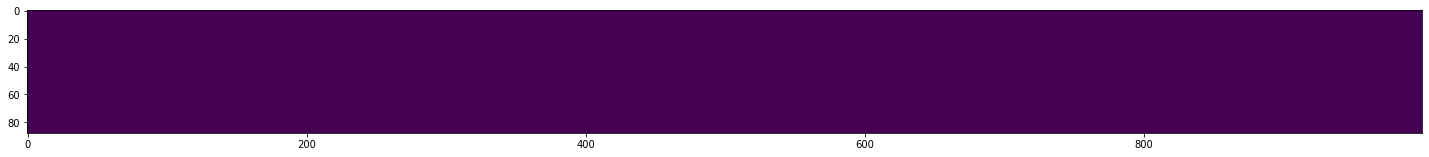

Epoch [    2/   80] | d_loss: 12.9658 | g_loss: 22.1774
Epoch [    2/   80] | d_loss: 8.6763 | g_loss: 0.0000
Epoch [    3/   80] | d_loss: 2.2470 | g_loss: 29.3034
Epoch [    3/   80] | d_loss: 2.3568 | g_loss: 35.4807
Epoch [    4/   80] | d_loss: 2.0390 | g_loss: 42.6909
Epoch [    4/   80] | d_loss: 1.8426 | g_loss: 46.4439
Epoch [    5/   80] | d_loss: 1.4774 | g_loss: 53.2097
Epoch [    5/   80] | d_loss: 1.3081 | g_loss: 49.9357
Epoch [    6/   80] | d_loss: 1.1613 | g_loss: 40.3308
Epoch [    6/   80] | d_loss: 1.2504 | g_loss: 34.1568


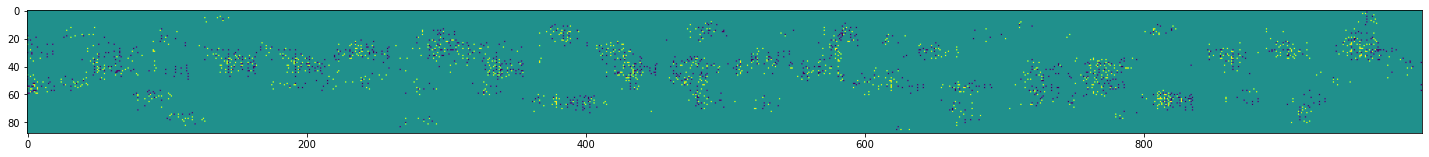

Epoch [    7/   80] | d_loss: 1.1064 | g_loss: 22.4635
Epoch [    7/   80] | d_loss: 1.1375 | g_loss: 26.0731
Epoch [    8/   80] | d_loss: 2.0442 | g_loss: 22.2614
Epoch [    8/   80] | d_loss: 1.0367 | g_loss: 15.9433
Epoch [    9/   80] | d_loss: 0.9674 | g_loss: 18.7279
Epoch [    9/   80] | d_loss: 0.9343 | g_loss: 18.7184
Epoch [   10/   80] | d_loss: 0.7864 | g_loss: 14.4703
Epoch [   10/   80] | d_loss: 1.0225 | g_loss: 14.9816
Epoch [   11/   80] | d_loss: 1.0001 | g_loss: 17.4456
Epoch [   11/   80] | d_loss: 0.8656 | g_loss: 19.6507


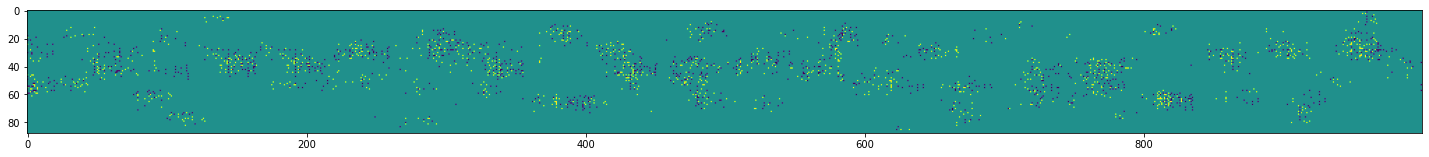

Epoch [   12/   80] | d_loss: 0.7004 | g_loss: 23.1781
Epoch [   12/   80] | d_loss: 0.7576 | g_loss: 19.0561
Epoch [   13/   80] | d_loss: 0.9134 | g_loss: 25.1894
Epoch [   13/   80] | d_loss: 0.5894 | g_loss: 27.8208
Epoch [   14/   80] | d_loss: 0.6242 | g_loss: 30.1597
Epoch [   14/   80] | d_loss: 0.6453 | g_loss: 31.3359
Epoch [   15/   80] | d_loss: 0.6486 | g_loss: 30.9063
Epoch [   15/   80] | d_loss: 0.6157 | g_loss: 28.6263
Epoch [   16/   80] | d_loss: 0.8199 | g_loss: 33.3826
Epoch [   16/   80] | d_loss: 0.9585 | g_loss: 37.9777


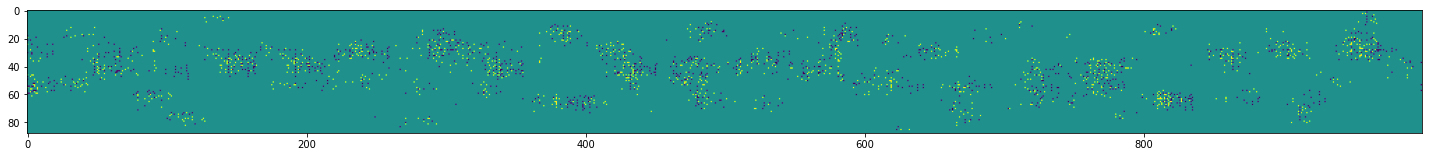

Epoch [   17/   80] | d_loss: 0.6974 | g_loss: 21.8772
Epoch [   17/   80] | d_loss: 0.7405 | g_loss: 15.4516
Epoch [   18/   80] | d_loss: 0.9188 | g_loss: 24.0135
Epoch [   18/   80] | d_loss: 0.7859 | g_loss: 24.4315
Epoch [   19/   80] | d_loss: 0.6863 | g_loss: 24.0452
Epoch [   19/   80] | d_loss: 0.5412 | g_loss: 24.2886
Epoch [   20/   80] | d_loss: 0.6728 | g_loss: 25.0775
Epoch [   20/   80] | d_loss: 0.6168 | g_loss: 21.1898
Epoch [   21/   80] | d_loss: 0.8695 | g_loss: 24.4831
Epoch [   21/   80] | d_loss: 0.4480 | g_loss: 28.6972


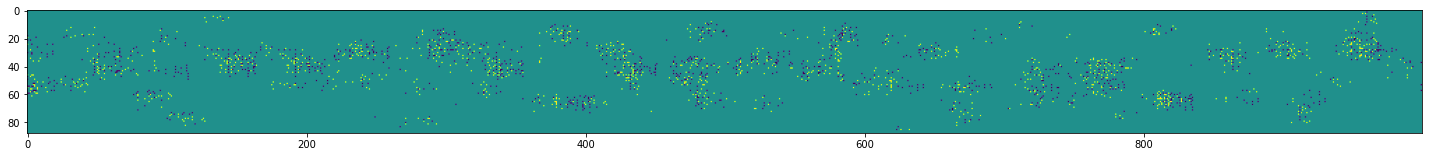

Epoch [   22/   80] | d_loss: 0.5042 | g_loss: 18.4571
Epoch [   22/   80] | d_loss: 0.5536 | g_loss: 20.6720
Epoch [   23/   80] | d_loss: 0.4605 | g_loss: 29.8340
Epoch [   23/   80] | d_loss: 0.6441 | g_loss: 24.2407
Epoch [   24/   80] | d_loss: 1.1025 | g_loss: 23.5064
Epoch [   24/   80] | d_loss: 0.7649 | g_loss: 29.1537
Epoch [   25/   80] | d_loss: 1.4091 | g_loss: 33.7496
Epoch [   25/   80] | d_loss: 0.7211 | g_loss: 23.8019
Epoch [   26/   80] | d_loss: 0.9370 | g_loss: 24.1798
Epoch [   26/   80] | d_loss: 0.6050 | g_loss: 29.6480


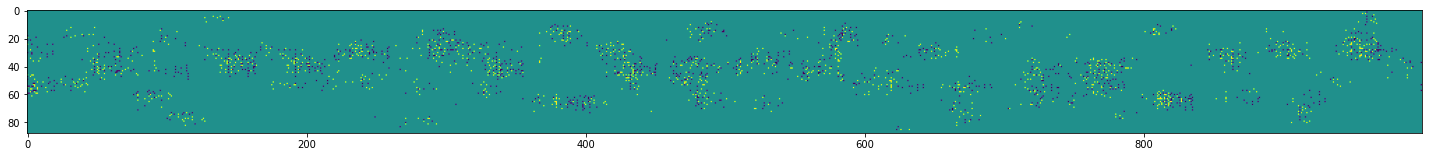

Epoch [   27/   80] | d_loss: 0.4709 | g_loss: 22.4399
Epoch [   27/   80] | d_loss: 0.7454 | g_loss: 11.0366
Epoch [   28/   80] | d_loss: 1.3407 | g_loss: 18.1265
Epoch [   28/   80] | d_loss: 1.0851 | g_loss: 24.8053
Epoch [   29/   80] | d_loss: 0.8509 | g_loss: 30.8225
Epoch [   29/   80] | d_loss: 0.6005 | g_loss: 25.8018
Epoch [   30/   80] | d_loss: 0.8657 | g_loss: 23.1920
Epoch [   30/   80] | d_loss: 0.5669 | g_loss: 24.8364
Epoch [   31/   80] | d_loss: 0.5683 | g_loss: 25.3043
Epoch [   31/   80] | d_loss: 0.5393 | g_loss: 16.4508


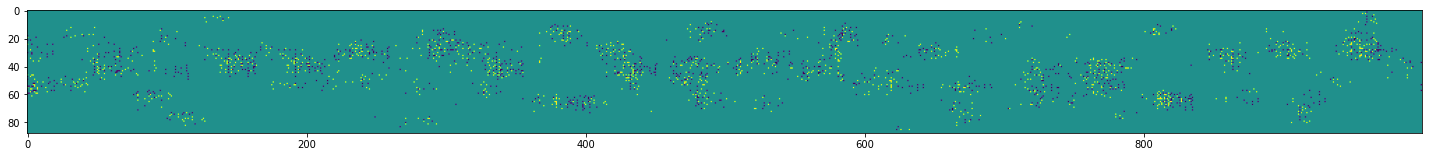

Epoch [   32/   80] | d_loss: 1.0924 | g_loss: 8.6959
Epoch [   32/   80] | d_loss: 0.6520 | g_loss: 18.3627
Epoch [   33/   80] | d_loss: 1.9987 | g_loss: 20.1823
Epoch [   33/   80] | d_loss: 1.1581 | g_loss: 15.2137
Epoch [   34/   80] | d_loss: 1.6756 | g_loss: 17.4083
Epoch [   34/   80] | d_loss: 0.8921 | g_loss: 26.4305
Epoch [   35/   80] | d_loss: 1.6336 | g_loss: 26.8054
Epoch [   35/   80] | d_loss: 0.7527 | g_loss: 20.2132
Epoch [   36/   80] | d_loss: 1.1737 | g_loss: 23.2987
Epoch [   36/   80] | d_loss: 0.9906 | g_loss: 26.6052


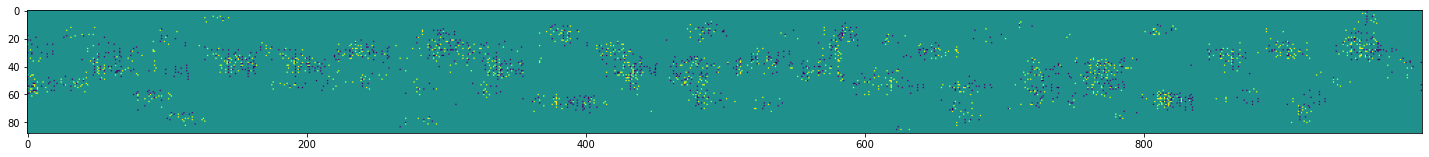

Epoch [   37/   80] | d_loss: 0.9415 | g_loss: 18.8682
Epoch [   37/   80] | d_loss: 0.5395 | g_loss: 16.8635
Epoch [   38/   80] | d_loss: 0.8323 | g_loss: 22.3889
Epoch [   38/   80] | d_loss: 0.6839 | g_loss: 24.2748
Epoch [   39/   80] | d_loss: 0.6457 | g_loss: 18.1691
Epoch [   39/   80] | d_loss: 0.7244 | g_loss: 19.9379
Epoch [   40/   80] | d_loss: 0.8294 | g_loss: 22.4798
Epoch [   40/   80] | d_loss: 0.7822 | g_loss: 17.9729
Epoch [   41/   80] | d_loss: 0.7944 | g_loss: 17.6248
Epoch [   41/   80] | d_loss: 0.5942 | g_loss: 23.9658


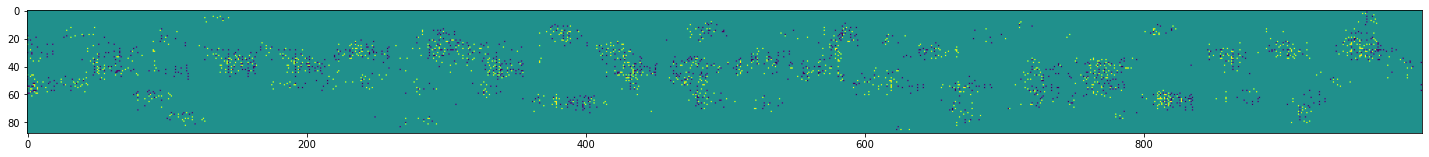

Epoch [   42/   80] | d_loss: 0.8456 | g_loss: 11.5406
Epoch [   42/   80] | d_loss: 1.0007 | g_loss: 8.6567
Epoch [   43/   80] | d_loss: 0.8396 | g_loss: 17.1728
Epoch [   43/   80] | d_loss: 1.0930 | g_loss: 20.3898
Epoch [   44/   80] | d_loss: 0.7942 | g_loss: 9.0819
Epoch [   44/   80] | d_loss: 1.7646 | g_loss: 8.6713
Epoch [   45/   80] | d_loss: 1.4658 | g_loss: 20.1146
Epoch [   45/   80] | d_loss: 0.5834 | g_loss: 32.0360
Epoch [   46/   80] | d_loss: 2.1402 | g_loss: 29.5481
Epoch [   46/   80] | d_loss: 1.1135 | g_loss: 24.6991


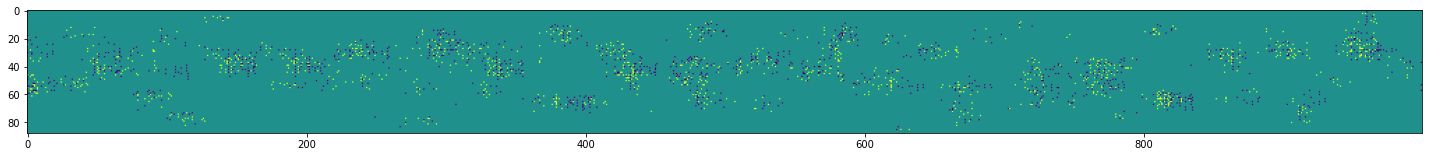

Epoch [   47/   80] | d_loss: 1.2815 | g_loss: 17.7873
Epoch [   47/   80] | d_loss: 0.8492 | g_loss: 23.6573
Epoch [   48/   80] | d_loss: 1.7013 | g_loss: 31.2895
Epoch [   48/   80] | d_loss: 0.8000 | g_loss: 22.7756
Epoch [   49/   80] | d_loss: 1.0522 | g_loss: 22.4769
Epoch [   49/   80] | d_loss: 0.6955 | g_loss: 28.0565
Epoch [   50/   80] | d_loss: 0.6258 | g_loss: 28.2030
Epoch [   50/   80] | d_loss: 0.5157 | g_loss: 30.0422
Epoch [   51/   80] | d_loss: 0.6334 | g_loss: 29.9078
Epoch [   51/   80] | d_loss: 0.6303 | g_loss: 31.8651


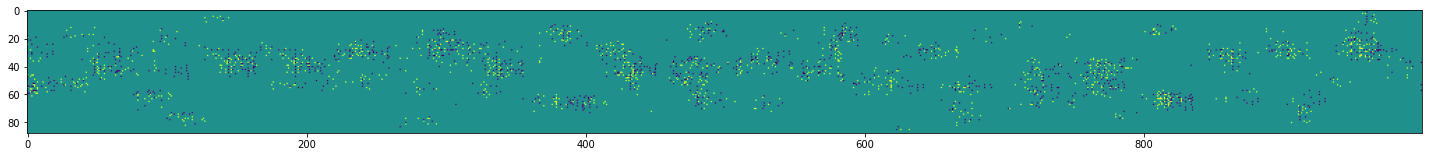

Epoch [   52/   80] | d_loss: 0.6234 | g_loss: 18.7051
Epoch [   52/   80] | d_loss: 0.9301 | g_loss: 18.1628
Epoch [   53/   80] | d_loss: 0.7378 | g_loss: 26.0186
Epoch [   53/   80] | d_loss: 1.2695 | g_loss: 22.4618
Epoch [   54/   80] | d_loss: 1.1294 | g_loss: 15.2653
Epoch [   54/   80] | d_loss: 1.2169 | g_loss: 15.9150
Epoch [   55/   80] | d_loss: 0.5349 | g_loss: 23.9594
Epoch [   55/   80] | d_loss: 1.6063 | g_loss: 16.6232
Epoch [   56/   80] | d_loss: 0.9930 | g_loss: 11.9201
Epoch [   56/   80] | d_loss: 1.3137 | g_loss: 15.2917


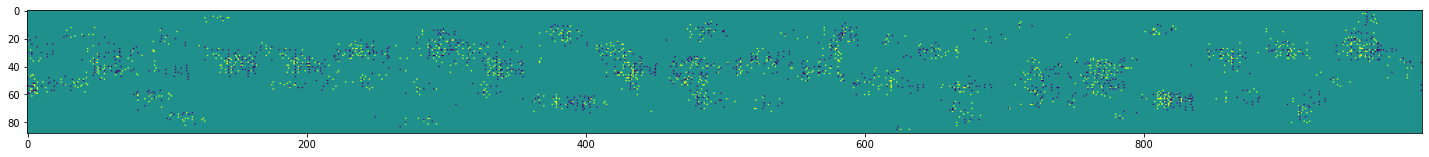

Epoch [   57/   80] | d_loss: 0.7161 | g_loss: 18.7778
Epoch [   57/   80] | d_loss: 0.9444 | g_loss: 15.2428
Epoch [   58/   80] | d_loss: 1.2757 | g_loss: 6.2743
Epoch [   58/   80] | d_loss: 1.8072 | g_loss: 8.9350
Epoch [   59/   80] | d_loss: 1.4817 | g_loss: 16.2239
Epoch [   59/   80] | d_loss: 0.7343 | g_loss: 28.3868
Epoch [   60/   80] | d_loss: 0.5034 | g_loss: 21.1997
Epoch [   60/   80] | d_loss: 1.2428 | g_loss: 17.9659
Epoch [   61/   80] | d_loss: 1.0281 | g_loss: 23.8183
Epoch [   61/   80] | d_loss: 0.8450 | g_loss: 31.3102


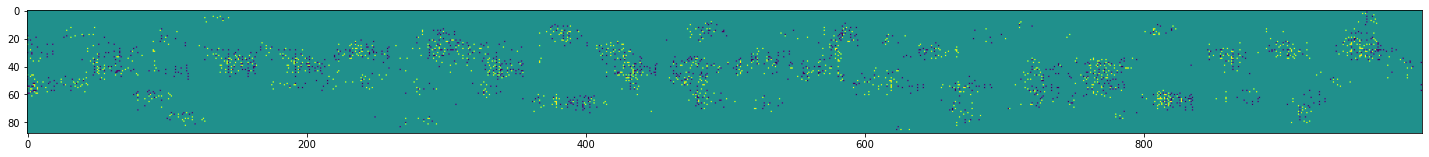

Epoch [   62/   80] | d_loss: 0.7924 | g_loss: 21.4301
Epoch [   62/   80] | d_loss: 0.8494 | g_loss: 20.6982
Epoch [   63/   80] | d_loss: 0.6194 | g_loss: 29.5154
Epoch [   63/   80] | d_loss: 0.9764 | g_loss: 30.7158
Epoch [   64/   80] | d_loss: 0.8398 | g_loss: 24.5317
Epoch [   64/   80] | d_loss: 0.9749 | g_loss: 30.0326
Epoch [   65/   80] | d_loss: 0.8426 | g_loss: 32.4668
Epoch [   65/   80] | d_loss: 0.8651 | g_loss: 32.4851
Epoch [   66/   80] | d_loss: 0.8621 | g_loss: 29.6610
Epoch [   66/   80] | d_loss: 0.6251 | g_loss: 32.9161


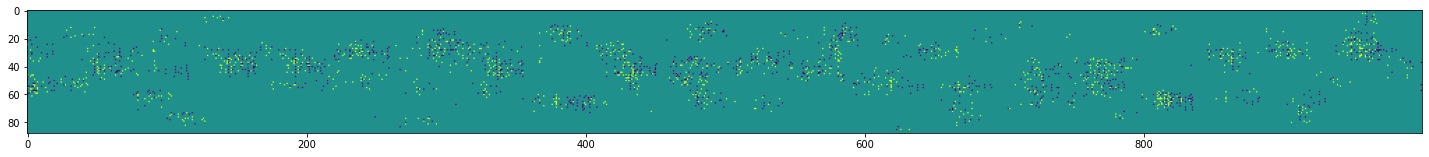

Epoch [   67/   80] | d_loss: 0.6921 | g_loss: 23.7757
Epoch [   67/   80] | d_loss: 0.6367 | g_loss: 23.4585
Epoch [   68/   80] | d_loss: 0.5309 | g_loss: 31.8683
Epoch [   68/   80] | d_loss: 0.5563 | g_loss: 28.2369
Epoch [   69/   80] | d_loss: 0.7755 | g_loss: 24.7810
Epoch [   69/   80] | d_loss: 0.6757 | g_loss: 26.4969
Epoch [   70/   80] | d_loss: 0.7481 | g_loss: 25.2575
Epoch [   70/   80] | d_loss: 0.5656 | g_loss: 24.2995
Epoch [   71/   80] | d_loss: 0.4938 | g_loss: 28.4068
Epoch [   71/   80] | d_loss: 0.5291 | g_loss: 28.3835


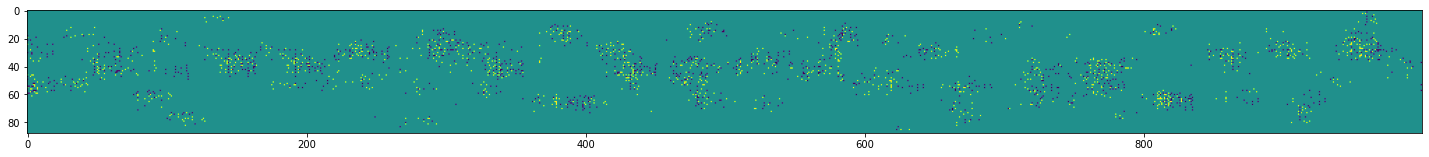

Epoch [   72/   80] | d_loss: 0.4665 | g_loss: 21.6089
Epoch [   72/   80] | d_loss: 0.8923 | g_loss: 19.0395
Epoch [   73/   80] | d_loss: 0.8383 | g_loss: 22.7344
Epoch [   73/   80] | d_loss: 0.7744 | g_loss: 24.8637
Epoch [   74/   80] | d_loss: 1.1279 | g_loss: 28.6277
Epoch [   74/   80] | d_loss: 0.4988 | g_loss: 23.5437
Epoch [   75/   80] | d_loss: 0.5057 | g_loss: 24.0802
Epoch [   75/   80] | d_loss: 0.7752 | g_loss: 23.5425
Epoch [   76/   80] | d_loss: 0.6918 | g_loss: 17.7228
Epoch [   76/   80] | d_loss: 0.8752 | g_loss: 19.9058


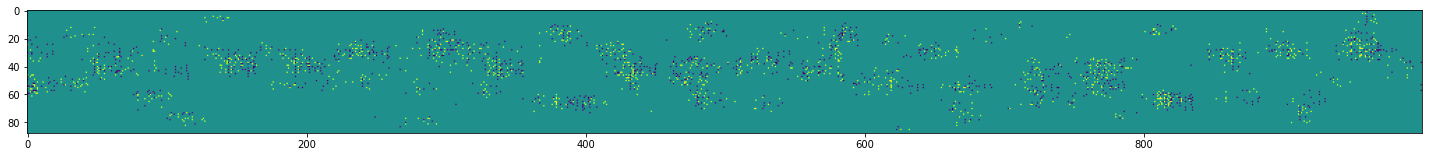

Epoch [   77/   80] | d_loss: 0.4359 | g_loss: 20.6400
Epoch [   77/   80] | d_loss: 0.8885 | g_loss: 15.2137
Epoch [   78/   80] | d_loss: 1.1882 | g_loss: 14.3101
Epoch [   78/   80] | d_loss: 1.2221 | g_loss: 15.9380
Epoch [   79/   80] | d_loss: 0.7207 | g_loss: 24.1861
Epoch [   79/   80] | d_loss: 0.5088 | g_loss: 21.6937
Epoch [   80/   80] | d_loss: 0.5792 | g_loss: 21.0822
Epoch [   80/   80] | d_loss: 0.5133 | g_loss: 22.6713


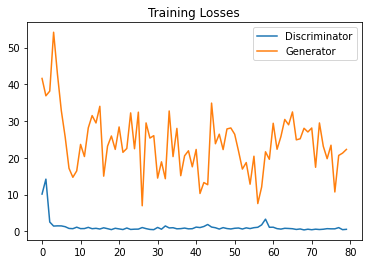

In [ ]:
# Size of input image to discriminator (28*28)
input_size = 1
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layers in the discriminator and the generator
hidden_size = 256
z_size = 10
batch_size = 20

try:
  del D
  del G
  torch.cuda.empty_cache()
  gc.collect()
  print("cache is cleard")
except:
  print("did not delete chache")

load_models = False
D = Discriminator(batch_size, input_size, hidden_size, d_output_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, output_size, scale
G = Generator(batch_size, input_size, hidden_size, z_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, latent, scale
RH = RNNHands(z_size).to(device)
LH = RNNHands(z_size).to(device)
C = RNNchords(z_size).to(device)
HOH = OneHotHands().to(device)
COH = OneHotChords().to(device)
if load_models:
    checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models/compose{}.pk'
    G.load_state_dict(torch.load(checkpoint_path.format("G" + str(load_models)), map_location=torch.device('cuda')))
    D.load_state_dict(torch.load(checkpoint_path.format("D" + str(load_models)), map_location=torch.device('cuda')))

train(G, D, RH, LH, C, HOH, COH, images_arr,batch_size,84, z_size, lr=0.002, num_epochs=80)
# plot_grad_flow(G.cpu().named_parameters())

**We can see** that the discriminator remains low, but the generator does not converge. It is harder for the generator to make fine tunings because the inpust it gets lacks information and can represent less features & patterns in the piece.

In the VAE model, where the main conclusion was that for a model with a larger latent - the results were better, the convergence curve was sharper and faster (actually for a low latent we did not get good convergence at all).

We get the same conclusion here for the GAN model, The concept of the GANs Generator is similar to the VAEs Decoder (generating a bigger image from a small latent)

### **Train With Small Batch**

cache is cleard
Epoch [    1/   80] | d_loss: 1.4854 | g_loss: 32.2762
Epoch [    1/   80] | d_loss: 25.8925 | g_loss: 20.7510


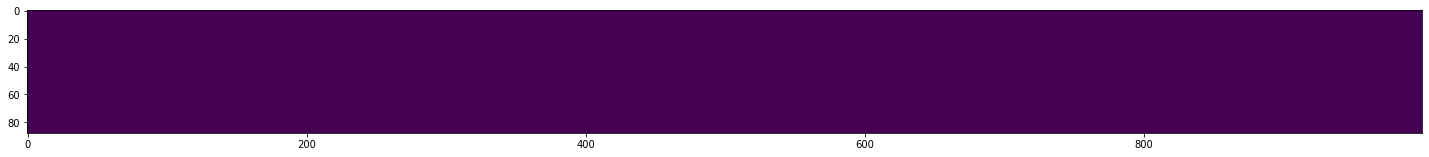

Epoch [    2/   80] | d_loss: 0.8375 | g_loss: 5.4991
Epoch [    2/   80] | d_loss: 4.1203 | g_loss: 37.0404
Epoch [    3/   80] | d_loss: 0.6478 | g_loss: 24.5395
Epoch [    3/   80] | d_loss: 1.1074 | g_loss: 25.1450
Epoch [    4/   80] | d_loss: 0.8631 | g_loss: 20.7912
Epoch [    4/   80] | d_loss: 1.2799 | g_loss: 23.2889
Epoch [    5/   80] | d_loss: 1.0306 | g_loss: 30.8197
Epoch [    5/   80] | d_loss: 1.0191 | g_loss: 37.2723
Epoch [    6/   80] | d_loss: 1.1644 | g_loss: 30.4778
Epoch [    6/   80] | d_loss: 1.1662 | g_loss: 26.7437


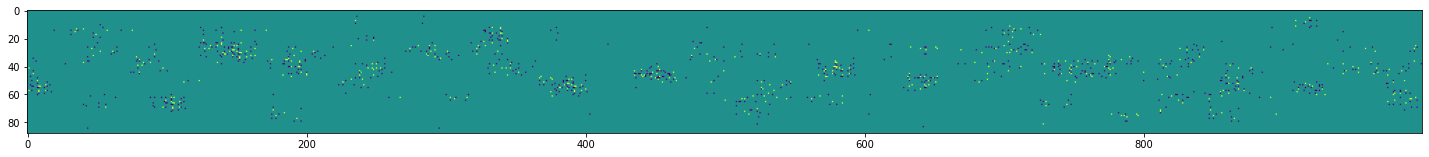

Epoch [    7/   80] | d_loss: 1.0403 | g_loss: 11.6652
Epoch [    7/   80] | d_loss: 1.1920 | g_loss: 16.9116
Epoch [    8/   80] | d_loss: 0.8520 | g_loss: 29.4242
Epoch [    8/   80] | d_loss: 0.6939 | g_loss: 26.3058
Epoch [    9/   80] | d_loss: 0.7854 | g_loss: 22.6563
Epoch [    9/   80] | d_loss: 0.9404 | g_loss: 19.7641
Epoch [   10/   80] | d_loss: 0.7165 | g_loss: 23.1518
Epoch [   10/   80] | d_loss: 1.0582 | g_loss: 23.6203
Epoch [   11/   80] | d_loss: 0.7627 | g_loss: 16.7538
Epoch [   11/   80] | d_loss: 0.8635 | g_loss: 20.4976


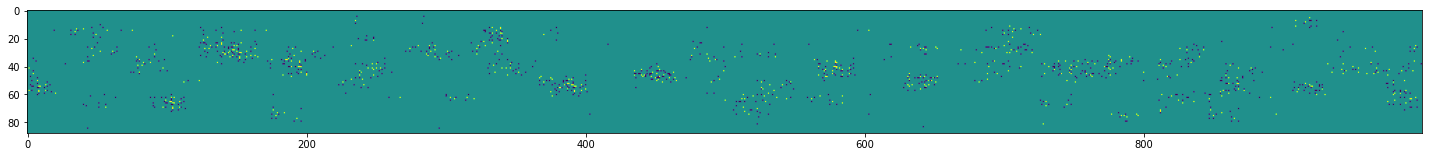

Epoch [   12/   80] | d_loss: 1.0029 | g_loss: 9.9497
Epoch [   12/   80] | d_loss: 0.7818 | g_loss: 8.0548
Epoch [   13/   80] | d_loss: 0.4710 | g_loss: 22.1829
Epoch [   13/   80] | d_loss: 0.7029 | g_loss: 20.5566
Epoch [   14/   80] | d_loss: 0.5910 | g_loss: 20.1036
Epoch [   14/   80] | d_loss: 0.6664 | g_loss: 19.2146
Epoch [   15/   80] | d_loss: 0.6385 | g_loss: 20.8479
Epoch [   15/   80] | d_loss: 0.6070 | g_loss: 18.2049
Epoch [   16/   80] | d_loss: 0.4882 | g_loss: 20.8411
Epoch [   16/   80] | d_loss: 0.6348 | g_loss: 19.0534


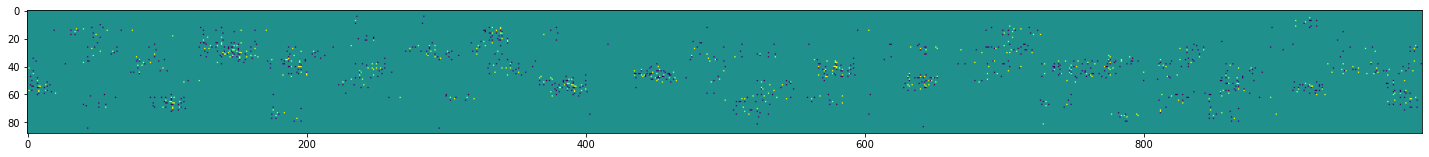

Epoch [   17/   80] | d_loss: 0.7101 | g_loss: 5.5955
Epoch [   17/   80] | d_loss: 0.6115 | g_loss: 10.5630
Epoch [   18/   80] | d_loss: 0.5320 | g_loss: 18.3825
Epoch [   18/   80] | d_loss: 0.6893 | g_loss: 20.3933
Epoch [   19/   80] | d_loss: 0.7394 | g_loss: 17.8899
Epoch [   19/   80] | d_loss: 0.5148 | g_loss: 19.3066
Epoch [   20/   80] | d_loss: 0.4150 | g_loss: 20.3209
Epoch [   20/   80] | d_loss: 0.5126 | g_loss: 18.4778
Epoch [   21/   80] | d_loss: 0.6078 | g_loss: 16.9000
Epoch [   21/   80] | d_loss: 0.5270 | g_loss: 21.0149


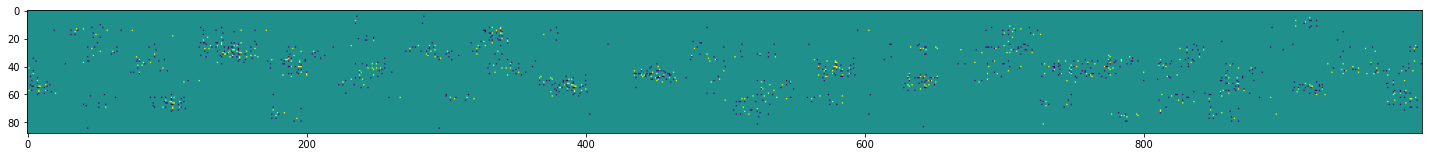

Epoch [   22/   80] | d_loss: 0.4482 | g_loss: 5.6414
Epoch [   22/   80] | d_loss: 0.5038 | g_loss: 9.7591
Epoch [   23/   80] | d_loss: 0.5408 | g_loss: 13.2004
Epoch [   23/   80] | d_loss: 0.7239 | g_loss: 14.6770
Epoch [   24/   80] | d_loss: 0.8312 | g_loss: 15.1204
Epoch [   24/   80] | d_loss: 0.8883 | g_loss: 10.2210
Epoch [   25/   80] | d_loss: 0.7002 | g_loss: 16.7264
Epoch [   25/   80] | d_loss: 0.7100 | g_loss: 17.1245
Epoch [   26/   80] | d_loss: 0.7426 | g_loss: 9.1389
Epoch [   26/   80] | d_loss: 0.9981 | g_loss: 10.7089


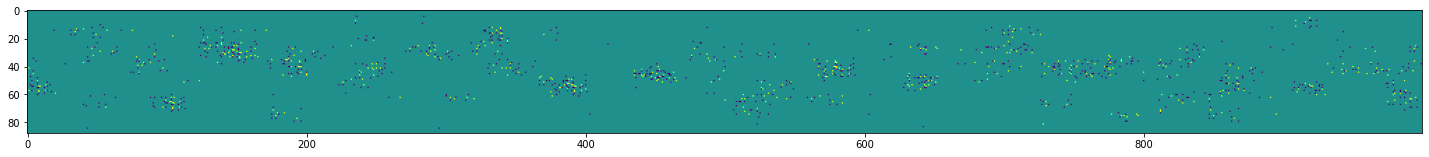

Epoch [   27/   80] | d_loss: 0.6773 | g_loss: 13.1048
Epoch [   27/   80] | d_loss: 0.6769 | g_loss: 3.9758
Epoch [   28/   80] | d_loss: 0.8409 | g_loss: 15.5305
Epoch [   28/   80] | d_loss: 0.8641 | g_loss: 18.4264
Epoch [   29/   80] | d_loss: 0.7162 | g_loss: 13.2197
Epoch [   29/   80] | d_loss: 0.7583 | g_loss: 13.0587
Epoch [   30/   80] | d_loss: 0.5159 | g_loss: 21.1974
Epoch [   30/   80] | d_loss: 0.5751 | g_loss: 16.4898
Epoch [   31/   80] | d_loss: 0.5431 | g_loss: 15.2709
Epoch [   31/   80] | d_loss: 0.4808 | g_loss: 19.2661


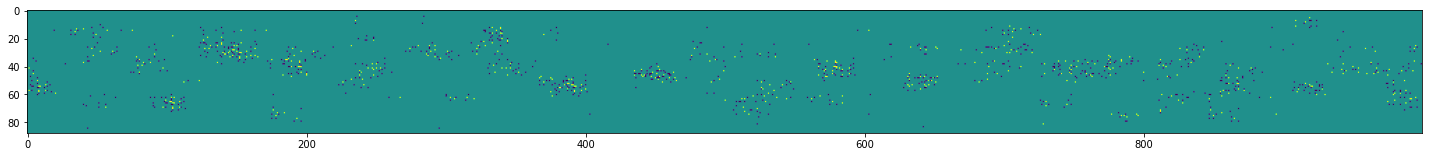

Epoch [   32/   80] | d_loss: 0.8481 | g_loss: 2.1369
Epoch [   32/   80] | d_loss: 0.5563 | g_loss: 13.6549
Epoch [   33/   80] | d_loss: 0.5950 | g_loss: 21.4658
Epoch [   33/   80] | d_loss: 0.5736 | g_loss: 24.0128
Epoch [   34/   80] | d_loss: 0.5224 | g_loss: 22.8361
Epoch [   34/   80] | d_loss: 0.5411 | g_loss: 29.2606
Epoch [   35/   80] | d_loss: 0.6248 | g_loss: 23.9773
Epoch [   35/   80] | d_loss: 0.4829 | g_loss: 28.8914
Epoch [   36/   80] | d_loss: 1.8857 | g_loss: 17.1695
Epoch [   36/   80] | d_loss: 2.1022 | g_loss: 3.6193


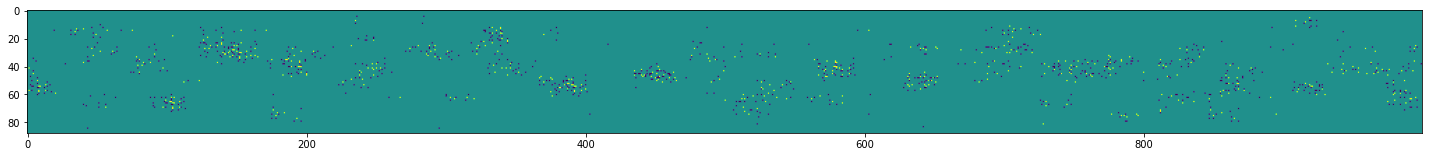

Epoch [   37/   80] | d_loss: 4.2921 | g_loss: 36.5327
Epoch [   37/   80] | d_loss: 12.6993 | g_loss: 56.7385
Epoch [   38/   80] | d_loss: 2.0117 | g_loss: 42.1131
Epoch [   38/   80] | d_loss: 5.1539 | g_loss: 26.3216
Epoch [   39/   80] | d_loss: 6.8391 | g_loss: 17.8232
Epoch [   39/   80] | d_loss: 7.5316 | g_loss: 24.0300
Epoch [   40/   80] | d_loss: 6.9154 | g_loss: 39.5295
Epoch [   40/   80] | d_loss: 5.1673 | g_loss: 57.4923
Epoch [   41/   80] | d_loss: 3.5198 | g_loss: 75.8722
Epoch [   41/   80] | d_loss: 2.3224 | g_loss: 84.8887


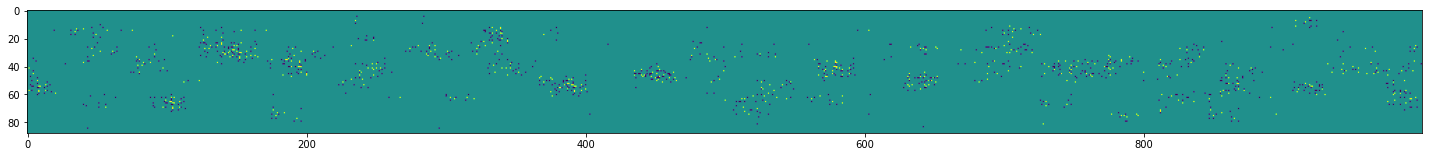

Epoch [   42/   80] | d_loss: 2.3815 | g_loss: 73.6684
Epoch [   42/   80] | d_loss: 1.3238 | g_loss: 69.0339
Epoch [   43/   80] | d_loss: 1.2395 | g_loss: 76.1777
Epoch [   43/   80] | d_loss: 1.0717 | g_loss: 76.2384
Epoch [   44/   80] | d_loss: 1.5368 | g_loss: 70.9583
Epoch [   44/   80] | d_loss: 1.2205 | g_loss: 66.1689
Epoch [   45/   80] | d_loss: 1.4209 | g_loss: 63.5672
Epoch [   45/   80] | d_loss: 1.1709 | g_loss: 63.9895
Epoch [   46/   80] | d_loss: 0.9083 | g_loss: 65.4875
Epoch [   46/   80] | d_loss: 1.5736 | g_loss: 59.2776


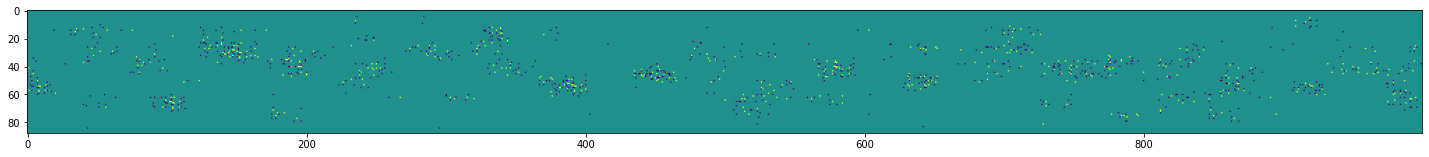

Epoch [   47/   80] | d_loss: 1.0303 | g_loss: 47.5912
Epoch [   47/   80] | d_loss: 0.9630 | g_loss: 46.9342
Epoch [   48/   80] | d_loss: 0.6383 | g_loss: 61.0913
Epoch [   48/   80] | d_loss: 1.3490 | g_loss: 54.5735
Epoch [   49/   80] | d_loss: 1.4012 | g_loss: 45.2025
Epoch [   49/   80] | d_loss: 1.4972 | g_loss: 44.1170
Epoch [   50/   80] | d_loss: 1.3480 | g_loss: 45.7845
Epoch [   50/   80] | d_loss: 0.6725 | g_loss: 53.8655
Epoch [   51/   80] | d_loss: 1.0544 | g_loss: 49.3777
Epoch [   51/   80] | d_loss: 1.3676 | g_loss: 33.0322


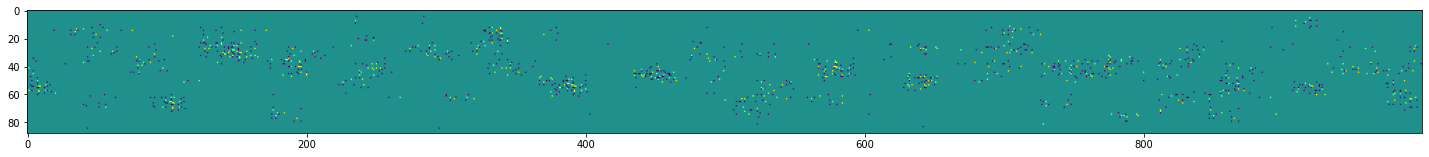

Epoch [   52/   80] | d_loss: 1.9167 | g_loss: 19.6224
Epoch [   52/   80] | d_loss: 2.0770 | g_loss: 23.7314
Epoch [   53/   80] | d_loss: 1.4159 | g_loss: 41.7127
Epoch [   53/   80] | d_loss: 0.9056 | g_loss: 50.1876
Epoch [   54/   80] | d_loss: 0.8254 | g_loss: 40.4096
Epoch [   54/   80] | d_loss: 1.3529 | g_loss: 36.5381
Epoch [   55/   80] | d_loss: 1.5585 | g_loss: 37.1288
Epoch [   55/   80] | d_loss: 0.8796 | g_loss: 45.3487
Epoch [   56/   80] | d_loss: 0.7286 | g_loss: 47.1797
Epoch [   56/   80] | d_loss: 0.7485 | g_loss: 40.5864


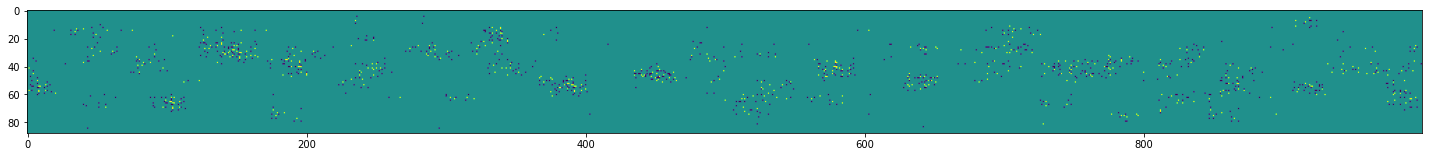

Epoch [   57/   80] | d_loss: 0.8724 | g_loss: 30.3458
Epoch [   57/   80] | d_loss: 0.8606 | g_loss: 31.7809
Epoch [   58/   80] | d_loss: 0.5589 | g_loss: 43.1531
Epoch [   58/   80] | d_loss: 0.8588 | g_loss: 39.6598
Epoch [   59/   80] | d_loss: 0.7345 | g_loss: 36.5145
Epoch [   59/   80] | d_loss: 0.8324 | g_loss: 39.4010
Epoch [   60/   80] | d_loss: 0.6485 | g_loss: 40.6823
Epoch [   60/   80] | d_loss: 0.6002 | g_loss: 40.7800
Epoch [   61/   80] | d_loss: 0.6854 | g_loss: 37.0892
Epoch [   61/   80] | d_loss: 0.7839 | g_loss: 36.5542


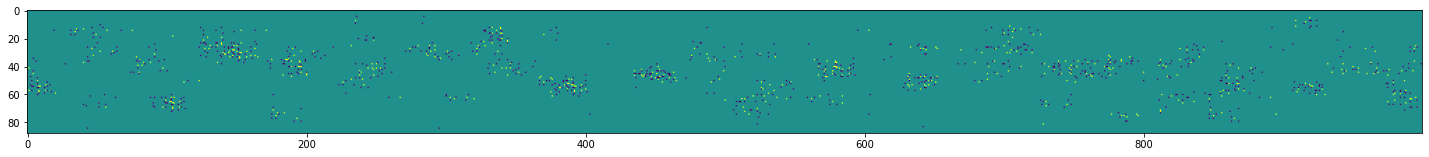

Epoch [   62/   80] | d_loss: 0.6397 | g_loss: 29.5637
Epoch [   62/   80] | d_loss: 0.6676 | g_loss: 29.3016
Epoch [   63/   80] | d_loss: 0.5770 | g_loss: 39.0937
Epoch [   63/   80] | d_loss: 0.5722 | g_loss: 38.2606
Epoch [   64/   80] | d_loss: 0.6548 | g_loss: 36.3810
Epoch [   64/   80] | d_loss: 0.7002 | g_loss: 39.8235
Epoch [   65/   80] | d_loss: 0.5314 | g_loss: 40.5031
Epoch [   65/   80] | d_loss: 0.5584 | g_loss: 36.3895
Epoch [   66/   80] | d_loss: 0.7937 | g_loss: 35.8025
Epoch [   66/   80] | d_loss: 0.5980 | g_loss: 39.2562


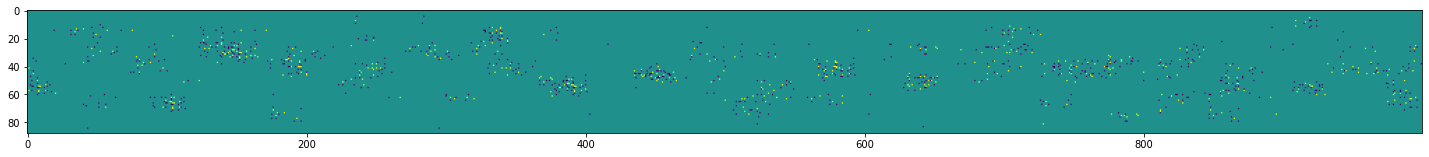

Epoch [   67/   80] | d_loss: 0.4668 | g_loss: 27.7393
Epoch [   67/   80] | d_loss: 0.5878 | g_loss: 29.6337
Epoch [   68/   80] | d_loss: 0.5463 | g_loss: 38.6157
Epoch [   68/   80] | d_loss: 0.7692 | g_loss: 34.2208
Epoch [   69/   80] | d_loss: 0.6929 | g_loss: 36.0704
Epoch [   69/   80] | d_loss: 0.5780 | g_loss: 39.3894
Epoch [   70/   80] | d_loss: 0.6173 | g_loss: 37.7865
Epoch [   70/   80] | d_loss: 0.5799 | g_loss: 34.2978
Epoch [   71/   80] | d_loss: 0.6352 | g_loss: 35.2522
Epoch [   71/   80] | d_loss: 0.8381 | g_loss: 35.7845


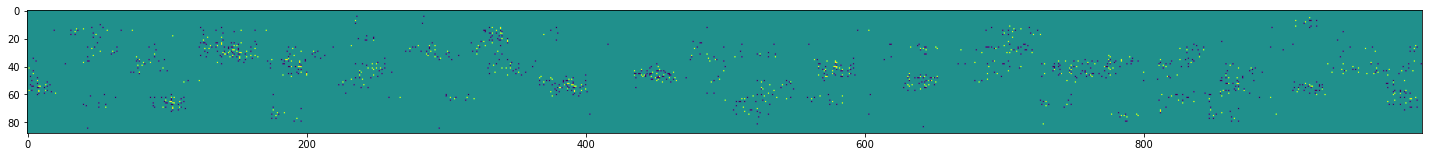

Epoch [   72/   80] | d_loss: 0.5022 | g_loss: 25.4600
Epoch [   72/   80] | d_loss: 0.6478 | g_loss: 26.5570
Epoch [   73/   80] | d_loss: 0.4587 | g_loss: 38.5358
Epoch [   73/   80] | d_loss: 0.4519 | g_loss: 30.9295
Epoch [   74/   80] | d_loss: 0.6716 | g_loss: 29.1196
Epoch [   74/   80] | d_loss: 0.6061 | g_loss: 33.2013
Epoch [   75/   80] | d_loss: 0.8917 | g_loss: 28.4043
Epoch [   75/   80] | d_loss: 0.6292 | g_loss: 25.1525
Epoch [   76/   80] | d_loss: 0.8119 | g_loss: 27.0424
Epoch [   76/   80] | d_loss: 1.4365 | g_loss: 28.5840


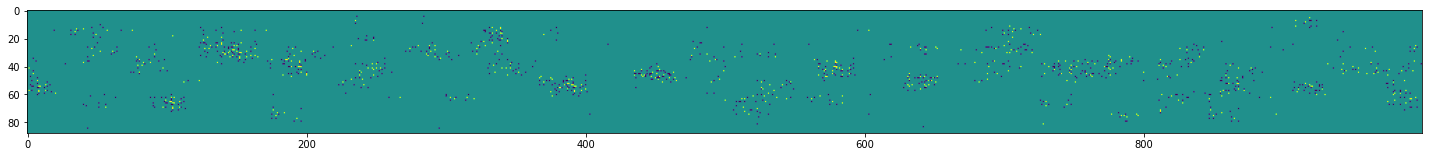

Epoch [   77/   80] | d_loss: 0.6548 | g_loss: 24.2771
Epoch [   77/   80] | d_loss: 0.5314 | g_loss: 23.2469
Epoch [   78/   80] | d_loss: 0.4548 | g_loss: 30.7207
Epoch [   78/   80] | d_loss: 0.5847 | g_loss: 33.3166
Epoch [   79/   80] | d_loss: 0.5313 | g_loss: 26.1549
Epoch [   79/   80] | d_loss: 0.9292 | g_loss: 27.9261
Epoch [   80/   80] | d_loss: 0.5823 | g_loss: 31.3453
Epoch [   80/   80] | d_loss: 1.6589 | g_loss: 26.8917


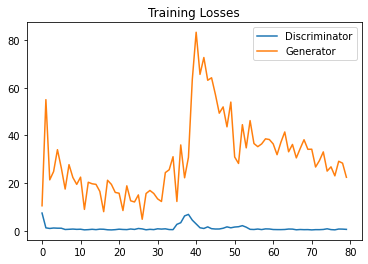

In [ ]:
# Size of input image to discriminator (28*28)
input_size = 1
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layers in the discriminator and the generator
hidden_size = 256
# Size of latent vector to give to generator
z_size = 200
batch_size = 5

try:
  del D
  del G
  torch.cuda.empty_cache()
  gc.collect()
  print("cache is cleard")
except:
  print("did not delete chache")

load_models = False
D = Discriminator(batch_size, input_size, hidden_size, d_output_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, output_size, scale
G = Generator(batch_size, input_size, hidden_size, z_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, latent, scale
RH = RNNHands(z_size).to(device)
LH = RNNHands(z_size).to(device)
C = RNNchords(z_size).to(device)
HOH = OneHotHands().to(device)
COH = OneHotChords().to(device)
if load_models:
    checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models2/compose{}.pk'
    G.load_state_dict(torch.load(checkpoint_path.format("G" + str(load_models)), map_location=torch.device('cuda')))
    D.load_state_dict(torch.load(checkpoint_path.format("D" + str(load_models)), map_location=torch.device('cuda')))

train(G, D, RH, LH, C, HOH, COH, images_arr,batch_size, z_size=200, lr=0.002, num_epochs=80)
# plot_grad_flow(G.cpu().named_parameters())

**For a small batch**, we get a curve that doesn't converge well, and even in the middle of the training it diverges for several epochs.

The learning process is not carried out properly, for a small batch the process is unstable because each backward we receive less information. When the batch is small, we may get all good/bad samples with a higher probability, therefore, we may get the gradients in the wrong direction - and thus the stability is affected.

### **Train with a high learning rate (=0.02)**

cache is cleard
Epoch [    1/   80] | d_loss: 1.5122 | g_loss: 159.0853
Epoch [    1/   80] | d_loss: 348.3285 | g_loss: 126.9546


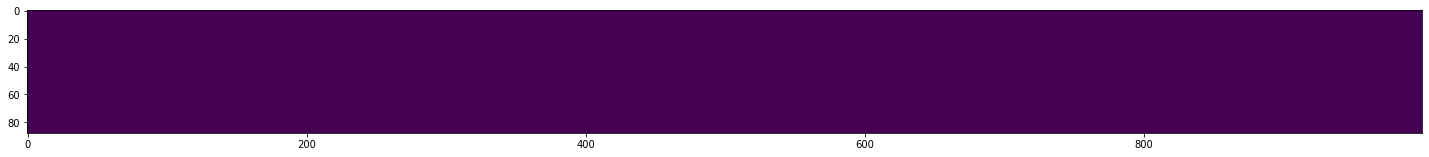

Epoch [    2/   80] | d_loss: 73.1373 | g_loss: 178.5321
Epoch [    2/   80] | d_loss: 12.0123 | g_loss: 0.0000
Epoch [    3/   80] | d_loss: 76.5221 | g_loss: 188.5431
Epoch [    3/   80] | d_loss: 41.2071 | g_loss: 472.6152
Epoch [    4/   80] | d_loss: 13.8762 | g_loss: 475.8939
Epoch [    4/   80] | d_loss: 15.9013 | g_loss: 453.9924
Epoch [    5/   80] | d_loss: 19.7379 | g_loss: 490.1494
Epoch [    5/   80] | d_loss: 24.0665 | g_loss: 495.0603
Epoch [    6/   80] | d_loss: 21.4227 | g_loss: 532.4170
Epoch [    6/   80] | d_loss: 18.3074 | g_loss: 617.2614


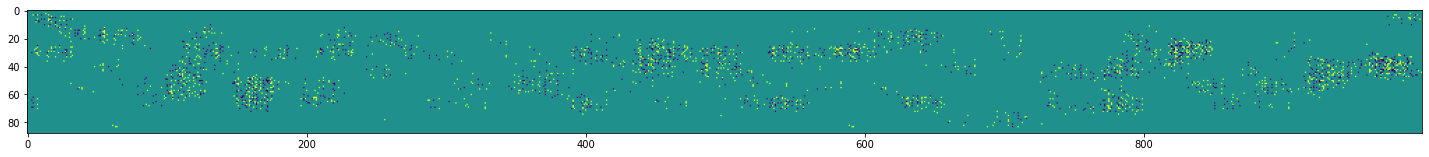

Epoch [    7/   80] | d_loss: 13.9538 | g_loss: 579.5307
Epoch [    7/   80] | d_loss: 14.4404 | g_loss: 628.2661
Epoch [    8/   80] | d_loss: 9.3717 | g_loss: 642.7332
Epoch [    8/   80] | d_loss: 9.0802 | g_loss: 621.3760
Epoch [    9/   80] | d_loss: 8.4274 | g_loss: 541.3737
Epoch [    9/   80] | d_loss: 8.2415 | g_loss: 521.9150
Epoch [   10/   80] | d_loss: 10.0634 | g_loss: 486.7374
Epoch [   10/   80] | d_loss: 7.4794 | g_loss: 456.6147
Epoch [   11/   80] | d_loss: 13.3338 | g_loss: 468.6681
Epoch [   11/   80] | d_loss: 10.5442 | g_loss: 402.4854


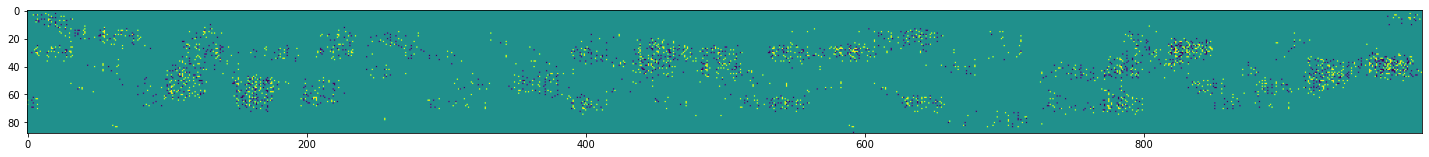

Epoch [   12/   80] | d_loss: 8.6893 | g_loss: 360.3636
Epoch [   12/   80] | d_loss: 10.3597 | g_loss: 404.7109
Epoch [   13/   80] | d_loss: 10.7349 | g_loss: 403.7477
Epoch [   13/   80] | d_loss: 5.3206 | g_loss: 387.7574
Epoch [   14/   80] | d_loss: 3.6319 | g_loss: 406.3280
Epoch [   14/   80] | d_loss: 7.7248 | g_loss: 378.7375
Epoch [   15/   80] | d_loss: 6.2470 | g_loss: 353.3153
Epoch [   15/   80] | d_loss: 6.5818 | g_loss: 360.1006
Epoch [   16/   80] | d_loss: 5.3490 | g_loss: 335.8293
Epoch [   16/   80] | d_loss: 7.1615 | g_loss: 357.4073


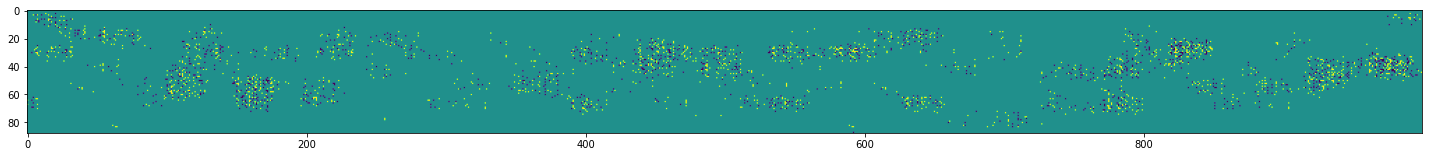

Epoch [   17/   80] | d_loss: 7.9695 | g_loss: 324.0088
Epoch [   17/   80] | d_loss: 3.9024 | g_loss: 312.5604
Epoch [   18/   80] | d_loss: 4.5500 | g_loss: 283.5457
Epoch [   18/   80] | d_loss: 5.0378 | g_loss: 299.8390
Epoch [   19/   80] | d_loss: 2.4956 | g_loss: 314.6830
Epoch [   19/   80] | d_loss: 4.3749 | g_loss: 328.6218
Epoch [   20/   80] | d_loss: 3.7162 | g_loss: 293.3683
Epoch [   20/   80] | d_loss: 4.6742 | g_loss: 287.8087
Epoch [   21/   80] | d_loss: 3.6479 | g_loss: 303.5795
Epoch [   21/   80] | d_loss: 3.6422 | g_loss: 321.5853


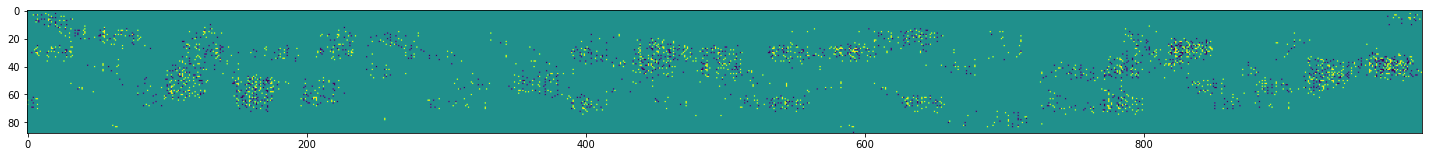

Epoch [   22/   80] | d_loss: 2.5165 | g_loss: 266.8804
Epoch [   22/   80] | d_loss: 3.6451 | g_loss: 257.3942
Epoch [   23/   80] | d_loss: 3.5694 | g_loss: 266.4852
Epoch [   23/   80] | d_loss: 3.7579 | g_loss: 263.9106
Epoch [   24/   80] | d_loss: 2.6085 | g_loss: 276.4019
Epoch [   24/   80] | d_loss: 2.7311 | g_loss: 272.8470
Epoch [   25/   80] | d_loss: 2.8546 | g_loss: 239.2095
Epoch [   25/   80] | d_loss: 2.7852 | g_loss: 268.2397
Epoch [   26/   80] | d_loss: 2.3160 | g_loss: 268.2569
Epoch [   26/   80] | d_loss: 3.8588 | g_loss: 241.1769


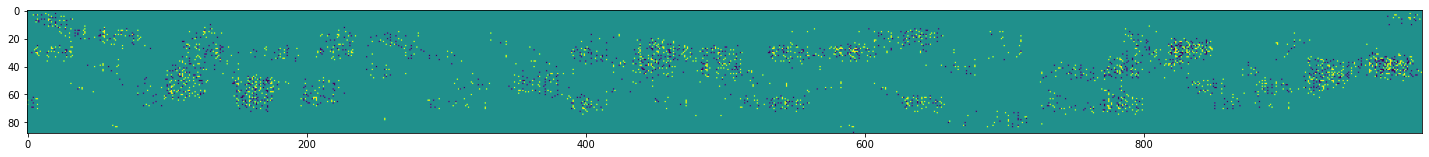

Epoch [   27/   80] | d_loss: 3.0470 | g_loss: 199.9095
Epoch [   27/   80] | d_loss: 2.7554 | g_loss: 222.1354
Epoch [   28/   80] | d_loss: 4.0606 | g_loss: 253.6966
Epoch [   28/   80] | d_loss: 4.6347 | g_loss: 222.4327
Epoch [   29/   80] | d_loss: 3.4631 | g_loss: 222.2546
Epoch [   29/   80] | d_loss: 3.0007 | g_loss: 194.0165
Epoch [   30/   80] | d_loss: 3.1351 | g_loss: 213.0182
Epoch [   30/   80] | d_loss: 4.6974 | g_loss: 210.2159
Epoch [   31/   80] | d_loss: 2.9335 | g_loss: 233.8617
Epoch [   31/   80] | d_loss: 2.5800 | g_loss: 218.5125


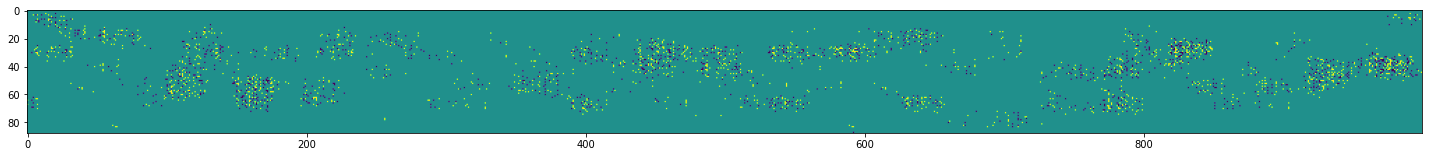

Epoch [   32/   80] | d_loss: 1.3184 | g_loss: 182.8339
Epoch [   32/   80] | d_loss: 2.5696 | g_loss: 196.2714
Epoch [   33/   80] | d_loss: 2.5476 | g_loss: 195.7637
Epoch [   33/   80] | d_loss: 2.2710 | g_loss: 195.2704
Epoch [   34/   80] | d_loss: 2.7441 | g_loss: 197.6406
Epoch [   34/   80] | d_loss: 2.0018 | g_loss: 184.8733
Epoch [   35/   80] | d_loss: 1.9325 | g_loss: 184.3645
Epoch [   35/   80] | d_loss: 2.1811 | g_loss: 179.4022
Epoch [   36/   80] | d_loss: 1.6817 | g_loss: 190.1294
Epoch [   36/   80] | d_loss: 2.3961 | g_loss: 182.0109


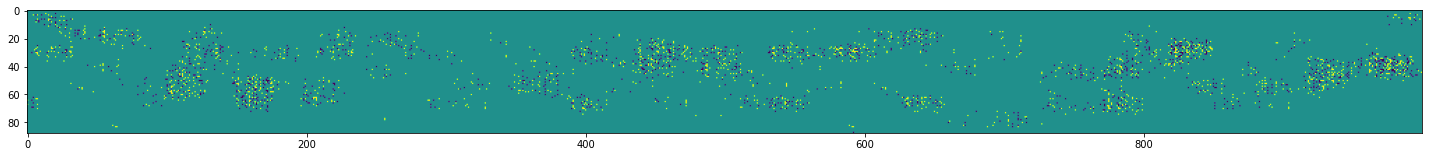

Epoch [   37/   80] | d_loss: 2.3454 | g_loss: 162.2901
Epoch [   37/   80] | d_loss: 1.6572 | g_loss: 173.6349
Epoch [   38/   80] | d_loss: 4.1499 | g_loss: 172.5353
Epoch [   38/   80] | d_loss: 2.2840 | g_loss: 153.2242
Epoch [   39/   80] | d_loss: 2.7841 | g_loss: 143.1173
Epoch [   39/   80] | d_loss: 2.8823 | g_loss: 155.7798
Epoch [   40/   80] | d_loss: 1.8279 | g_loss: 162.8055
Epoch [   40/   80] | d_loss: 2.3793 | g_loss: 175.9359
Epoch [   41/   80] | d_loss: 4.3277 | g_loss: 159.7675
Epoch [   41/   80] | d_loss: 2.1840 | g_loss: 143.5677


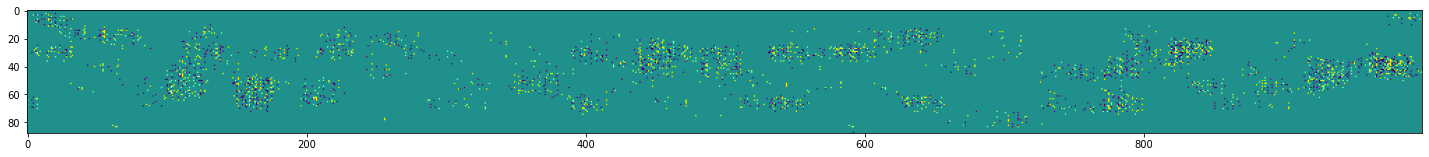

Epoch [   42/   80] | d_loss: 3.7437 | g_loss: 128.6623
Epoch [   42/   80] | d_loss: 3.6744 | g_loss: 126.3146
Epoch [   43/   80] | d_loss: 2.1638 | g_loss: 148.1627
Epoch [   43/   80] | d_loss: 3.5676 | g_loss: 167.2572
Epoch [   44/   80] | d_loss: 1.9216 | g_loss: 138.3508
Epoch [   44/   80] | d_loss: 1.8467 | g_loss: 138.2045
Epoch [   45/   80] | d_loss: 1.5361 | g_loss: 124.6055
Epoch [   45/   80] | d_loss: 1.8813 | g_loss: 129.6305
Epoch [   46/   80] | d_loss: 2.4694 | g_loss: 114.1555
Epoch [   46/   80] | d_loss: 1.8497 | g_loss: 105.7389


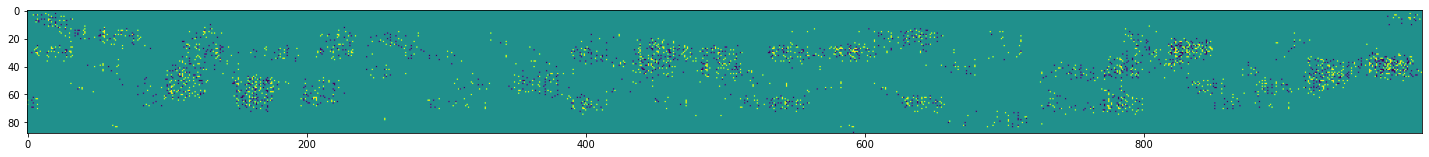

Epoch [   47/   80] | d_loss: 3.6404 | g_loss: 111.3592
Epoch [   47/   80] | d_loss: 2.2687 | g_loss: 87.8423
Epoch [   48/   80] | d_loss: 3.8548 | g_loss: 96.3384
Epoch [   48/   80] | d_loss: 3.4628 | g_loss: 107.9470
Epoch [   49/   80] | d_loss: 2.8938 | g_loss: 101.5672
Epoch [   49/   80] | d_loss: 2.9115 | g_loss: 112.4197
Epoch [   50/   80] | d_loss: 2.6587 | g_loss: 119.2807
Epoch [   50/   80] | d_loss: 2.0861 | g_loss: 110.4885
Epoch [   51/   80] | d_loss: 2.3881 | g_loss: 104.9117
Epoch [   51/   80] | d_loss: 1.8663 | g_loss: 102.0458


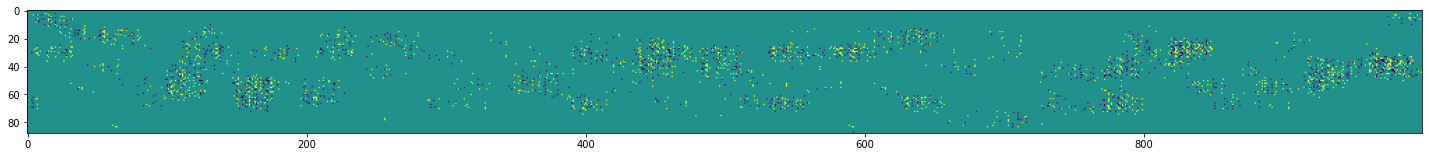

Epoch [   52/   80] | d_loss: 1.8586 | g_loss: 99.4240
Epoch [   52/   80] | d_loss: 2.5092 | g_loss: 97.7198
Epoch [   53/   80] | d_loss: 1.3745 | g_loss: 110.4671
Epoch [   53/   80] | d_loss: 1.2654 | g_loss: 98.7815
Epoch [   54/   80] | d_loss: 3.1734 | g_loss: 99.4951
Epoch [   54/   80] | d_loss: 1.9612 | g_loss: 101.5488
Epoch [   55/   80] | d_loss: 1.7282 | g_loss: 95.3147
Epoch [   55/   80] | d_loss: 1.8479 | g_loss: 102.4077
Epoch [   56/   80] | d_loss: 1.8627 | g_loss: 102.5270
Epoch [   56/   80] | d_loss: 2.6112 | g_loss: 87.5820


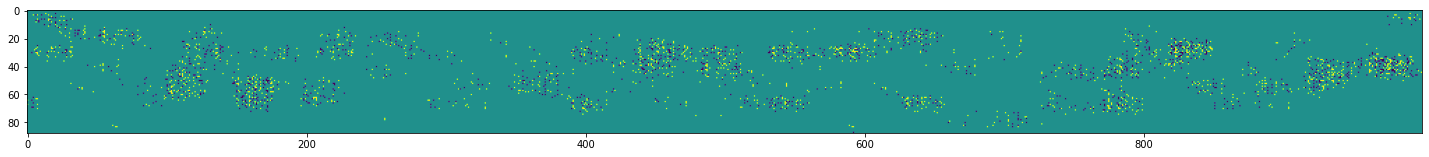

Epoch [   57/   80] | d_loss: 1.3465 | g_loss: 78.8155
Epoch [   57/   80] | d_loss: 1.8455 | g_loss: 83.5752
Epoch [   58/   80] | d_loss: 1.4442 | g_loss: 96.6480
Epoch [   58/   80] | d_loss: 1.1324 | g_loss: 93.0789
Epoch [   59/   80] | d_loss: 1.1031 | g_loss: 87.1082
Epoch [   59/   80] | d_loss: 1.8072 | g_loss: 79.3707
Epoch [   60/   80] | d_loss: 0.9327 | g_loss: 84.9073
Epoch [   60/   80] | d_loss: 1.2903 | g_loss: 75.5914
Epoch [   61/   80] | d_loss: 1.5298 | g_loss: 82.0427
Epoch [   61/   80] | d_loss: 1.3608 | g_loss: 75.9539


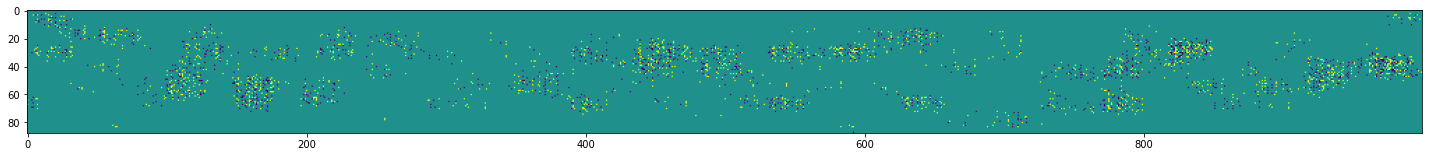

Epoch [   62/   80] | d_loss: 1.3196 | g_loss: 72.0536
Epoch [   62/   80] | d_loss: 1.2210 | g_loss: 65.0609
Epoch [   63/   80] | d_loss: 1.5871 | g_loss: 67.1436
Epoch [   63/   80] | d_loss: 0.9930 | g_loss: 74.8506
Epoch [   64/   80] | d_loss: 1.0897 | g_loss: 69.8727
Epoch [   64/   80] | d_loss: 1.5427 | g_loss: 68.7743
Epoch [   65/   80] | d_loss: 1.1491 | g_loss: 69.3957
Epoch [   65/   80] | d_loss: 1.2284 | g_loss: 70.1293
Epoch [   66/   80] | d_loss: 0.8541 | g_loss: 74.4971
Epoch [   66/   80] | d_loss: 1.4618 | g_loss: 64.2783


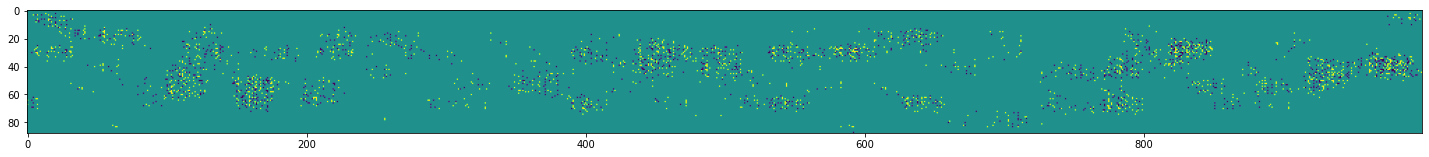

Epoch [   67/   80] | d_loss: 0.9502 | g_loss: 58.8028
Epoch [   67/   80] | d_loss: 1.0999 | g_loss: 58.6278
Epoch [   68/   80] | d_loss: 0.8871 | g_loss: 66.0958
Epoch [   68/   80] | d_loss: 0.8089 | g_loss: 66.9973
Epoch [   69/   80] | d_loss: 1.2429 | g_loss: 65.8137
Epoch [   69/   80] | d_loss: 1.0165 | g_loss: 57.4869
Epoch [   70/   80] | d_loss: 0.8812 | g_loss: 57.4802
Epoch [   70/   80] | d_loss: 1.1941 | g_loss: 59.7131
Epoch [   71/   80] | d_loss: 0.6202 | g_loss: 62.8064
Epoch [   71/   80] | d_loss: 0.8624 | g_loss: 60.5636


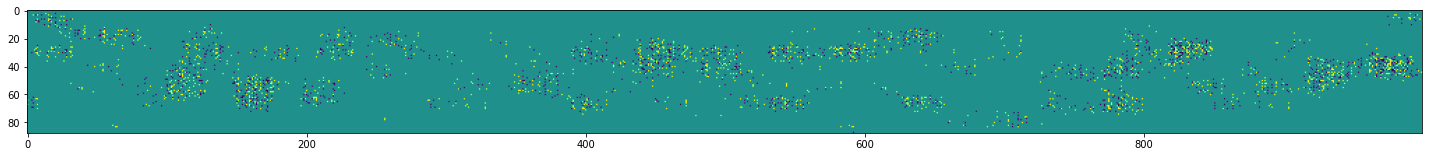

Epoch [   72/   80] | d_loss: 0.5938 | g_loss: 52.3097
Epoch [   72/   80] | d_loss: 0.6227 | g_loss: 61.7173
Epoch [   73/   80] | d_loss: 0.9990 | g_loss: 58.7952
Epoch [   73/   80] | d_loss: 1.1891 | g_loss: 50.4776
Epoch [   74/   80] | d_loss: 1.3808 | g_loss: 49.4030
Epoch [   74/   80] | d_loss: 1.0534 | g_loss: 51.8958
Epoch [   75/   80] | d_loss: 0.8035 | g_loss: 57.0467
Epoch [   75/   80] | d_loss: 0.9131 | g_loss: 61.3855
Epoch [   76/   80] | d_loss: 1.0471 | g_loss: 56.2713
Epoch [   76/   80] | d_loss: 0.7224 | g_loss: 51.3995


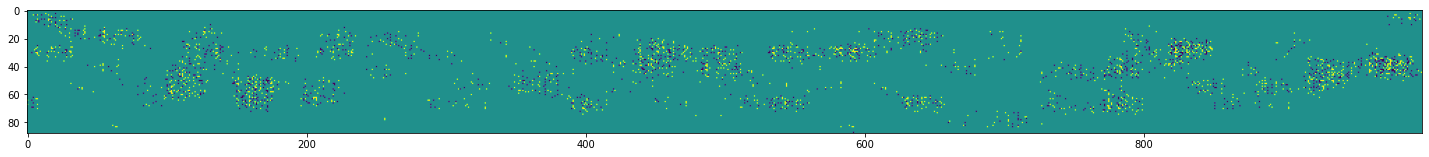

Epoch [   77/   80] | d_loss: 0.7136 | g_loss: 41.7558
Epoch [   77/   80] | d_loss: 1.0549 | g_loss: 50.7104
Epoch [   78/   80] | d_loss: 0.9285 | g_loss: 46.7412
Epoch [   78/   80] | d_loss: 0.5611 | g_loss: 52.6920
Epoch [   79/   80] | d_loss: 0.5563 | g_loss: 52.4819
Epoch [   79/   80] | d_loss: 0.6177 | g_loss: 50.0358
Epoch [   80/   80] | d_loss: 0.6269 | g_loss: 43.3786
Epoch [   80/   80] | d_loss: 0.7293 | g_loss: 45.2346


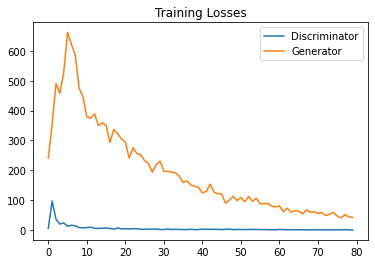

In [ ]:
# Size of input image to discriminator (28*28)
input_size = 1
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layers in the discriminator and the generator
hidden_size = 256
# Size of latent vector to give to generator
z_size = 200
batch_size = 20

try:
  del D
  del G
  torch.cuda.empty_cache()
  gc.collect()
  print("cache is cleard")
except:
  print("did not delete chache")

load_models = False
D = Discriminator(batch_size, input_size, hidden_size, d_output_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, output_size, scale
G = Generator(batch_size, input_size, hidden_size, z_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, latent, scale
RH = RNNHands(z_size).to(device)
LH = RNNHands(z_size).to(device)
C = RNNchords(z_size).to(device)
HOH = OneHotHands().to(device)
COH = OneHotChords().to(device)
if load_models:
    checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models2/compose{}.pk'
    G.load_state_dict(torch.load(checkpoint_path.format("G" + str(load_models)), map_location=torch.device('cuda')))
    D.load_state_dict(torch.load(checkpoint_path.format("D" + str(load_models)), map_location=torch.device('cuda')))

train(G, D, RH, LH, C, HOH, COH, images_arr,batch_size = 20, z_size=200, lr=0.02, num_epochs=80)
# plot_grad_flow(G.cpu().named_parameters())

**We increased the batch** and learning rate back to 0.02 (x10).
We will notice that now, with (batch size = 20, $z_t$ = 200, epochs = 80) the model converges and shows better results. However, the g_loss value to which we converge is relatively high, it is possible that the learning rate affects the convergence time. 

We would like to see if it is possible to reach a lower g_loss value, which means better convergence - therefore in the next part we will increase the epochs to 120 **for the same parameters**.

### **Train more epochs with high learning rate(=0.02)**

cache is cleard
Epoch [    1/  120] | d_loss: 1.5296 | g_loss: 384.0998
Epoch [    1/  120] | d_loss: 33.2229 | g_loss: 0.0000


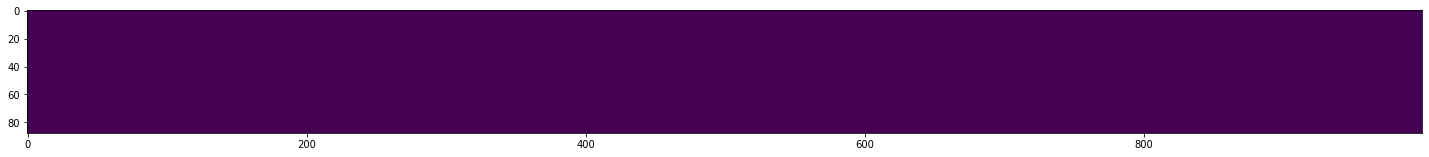

Epoch [    2/  120] | d_loss: 64.0707 | g_loss: 472.8398
Epoch [    2/  120] | d_loss: 12.9534 | g_loss: 735.1569
Epoch [    3/  120] | d_loss: 19.4991 | g_loss: 342.1906
Epoch [    3/  120] | d_loss: 7.3606 | g_loss: 244.2806
Epoch [    4/  120] | d_loss: 14.6894 | g_loss: 208.1499
Epoch [    4/  120] | d_loss: 13.0602 | g_loss: 232.6061
Epoch [    5/  120] | d_loss: 10.8890 | g_loss: 228.7301
Epoch [    5/  120] | d_loss: 9.8258 | g_loss: 265.7659
Epoch [    6/  120] | d_loss: 13.4518 | g_loss: 289.3406
Epoch [    6/  120] | d_loss: 5.1457 | g_loss: 259.3209


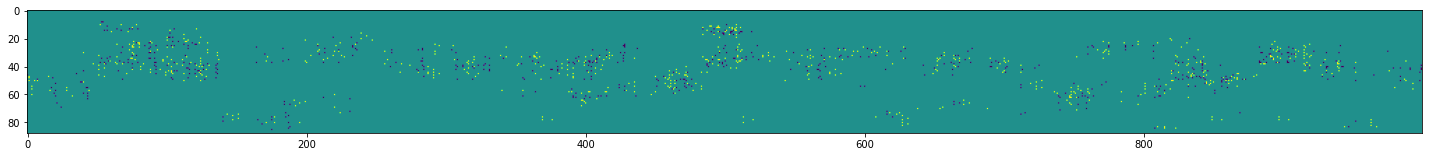

Epoch [    7/  120] | d_loss: 6.6420 | g_loss: 163.0971
Epoch [    7/  120] | d_loss: 5.5015 | g_loss: 215.8551
Epoch [    8/  120] | d_loss: 7.0301 | g_loss: 281.3971
Epoch [    8/  120] | d_loss: 6.9913 | g_loss: 241.7185
Epoch [    9/  120] | d_loss: 8.6189 | g_loss: 214.1255
Epoch [    9/  120] | d_loss: 9.9627 | g_loss: 187.2071
Epoch [   10/  120] | d_loss: 10.7754 | g_loss: 157.3206
Epoch [   10/  120] | d_loss: 7.8808 | g_loss: 169.6865
Epoch [   11/  120] | d_loss: 6.2802 | g_loss: 224.8998
Epoch [   11/  120] | d_loss: 4.1621 | g_loss: 176.3537


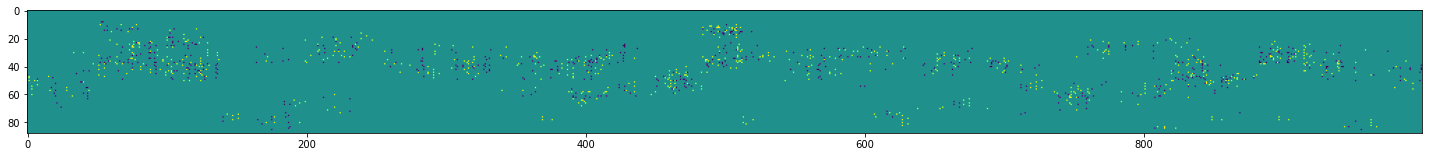

Epoch [   12/  120] | d_loss: 4.2589 | g_loss: 100.1893
Epoch [   12/  120] | d_loss: 4.9486 | g_loss: 92.6674
Epoch [   13/  120] | d_loss: 5.0060 | g_loss: 199.8174
Epoch [   13/  120] | d_loss: 8.4191 | g_loss: 201.7113
Epoch [   14/  120] | d_loss: 6.0444 | g_loss: 153.8777
Epoch [   14/  120] | d_loss: 2.9955 | g_loss: 161.0150
Epoch [   15/  120] | d_loss: 4.7563 | g_loss: 142.1716
Epoch [   15/  120] | d_loss: 3.8352 | g_loss: 154.9694
Epoch [   16/  120] | d_loss: 3.7173 | g_loss: 156.1198
Epoch [   16/  120] | d_loss: 2.7204 | g_loss: 146.5994


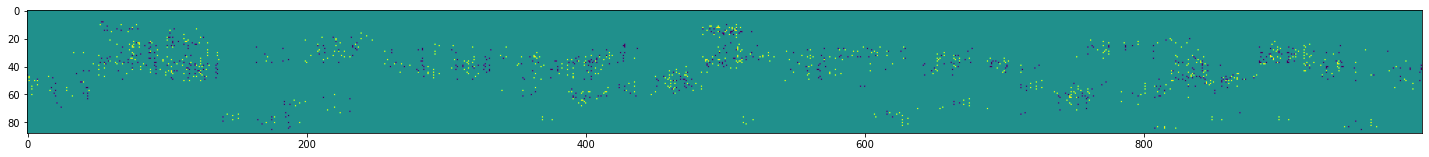

Epoch [   17/  120] | d_loss: 2.5133 | g_loss: 89.9438
Epoch [   17/  120] | d_loss: 3.3006 | g_loss: 44.4021
Epoch [   18/  120] | d_loss: 4.6582 | g_loss: 134.9979
Epoch [   18/  120] | d_loss: 2.6212 | g_loss: 162.1366
Epoch [   19/  120] | d_loss: 4.1212 | g_loss: 188.2767
Epoch [   19/  120] | d_loss: 3.7756 | g_loss: 175.3825
Epoch [   20/  120] | d_loss: 3.4400 | g_loss: 156.6879
Epoch [   20/  120] | d_loss: 4.0643 | g_loss: 163.8511
Epoch [   21/  120] | d_loss: 3.2425 | g_loss: 197.2280
Epoch [   21/  120] | d_loss: 2.7281 | g_loss: 184.4520


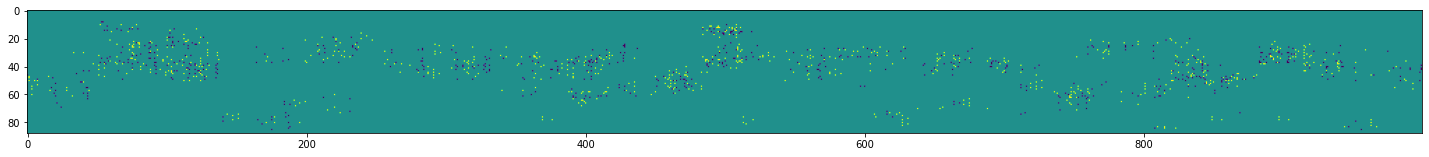

Epoch [   22/  120] | d_loss: 2.9025 | g_loss: 124.0207
Epoch [   22/  120] | d_loss: 4.9543 | g_loss: 142.0069
Epoch [   23/  120] | d_loss: 2.4163 | g_loss: 218.1588
Epoch [   23/  120] | d_loss: 3.2629 | g_loss: 171.5038
Epoch [   24/  120] | d_loss: 4.3708 | g_loss: 174.4304
Epoch [   24/  120] | d_loss: 5.0622 | g_loss: 194.1908
Epoch [   25/  120] | d_loss: 3.1775 | g_loss: 202.9628
Epoch [   25/  120] | d_loss: 5.3346 | g_loss: 177.7981
Epoch [   26/  120] | d_loss: 3.8225 | g_loss: 171.6223
Epoch [   26/  120] | d_loss: 3.7617 | g_loss: 151.2517


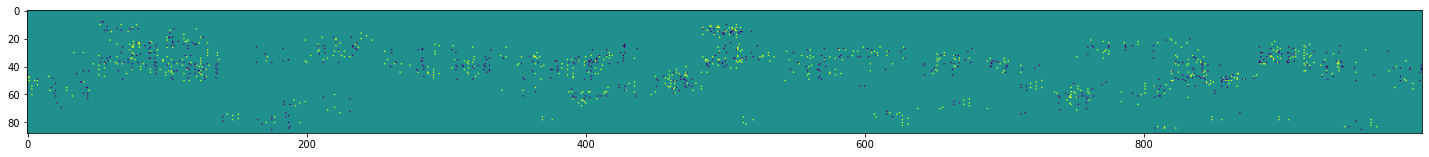

Epoch [   27/  120] | d_loss: 3.7868 | g_loss: 114.8289
Epoch [   27/  120] | d_loss: 4.1632 | g_loss: 109.4116
Epoch [   28/  120] | d_loss: 3.9611 | g_loss: 155.4798
Epoch [   28/  120] | d_loss: 2.8364 | g_loss: 159.1100
Epoch [   29/  120] | d_loss: 5.9418 | g_loss: 150.6744
Epoch [   29/  120] | d_loss: 2.2717 | g_loss: 126.2125
Epoch [   30/  120] | d_loss: 3.2263 | g_loss: 129.9951
Epoch [   30/  120] | d_loss: 3.1722 | g_loss: 128.3927
Epoch [   31/  120] | d_loss: 3.4374 | g_loss: 128.1111
Epoch [   31/  120] | d_loss: 2.4581 | g_loss: 129.4357


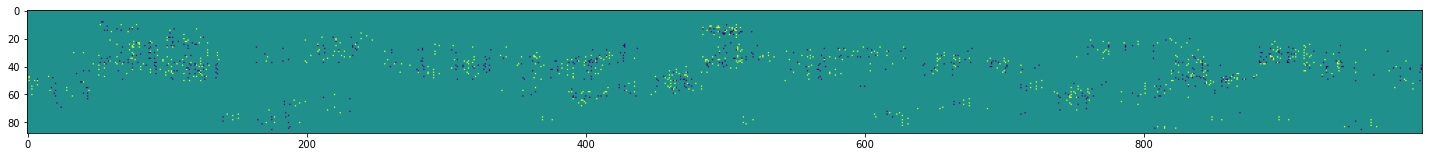

Epoch [   32/  120] | d_loss: 2.2631 | g_loss: 89.9985
Epoch [   32/  120] | d_loss: 4.1758 | g_loss: 69.9736
Epoch [   33/  120] | d_loss: 3.9752 | g_loss: 70.9040
Epoch [   33/  120] | d_loss: 5.6970 | g_loss: 71.4749
Epoch [   34/  120] | d_loss: 4.8947 | g_loss: 92.8346
Epoch [   34/  120] | d_loss: 4.4026 | g_loss: 129.0857
Epoch [   35/  120] | d_loss: 6.0950 | g_loss: 162.2760
Epoch [   35/  120] | d_loss: 4.6618 | g_loss: 175.2426
Epoch [   36/  120] | d_loss: 2.4668 | g_loss: 162.2485
Epoch [   36/  120] | d_loss: 2.8618 | g_loss: 186.4702


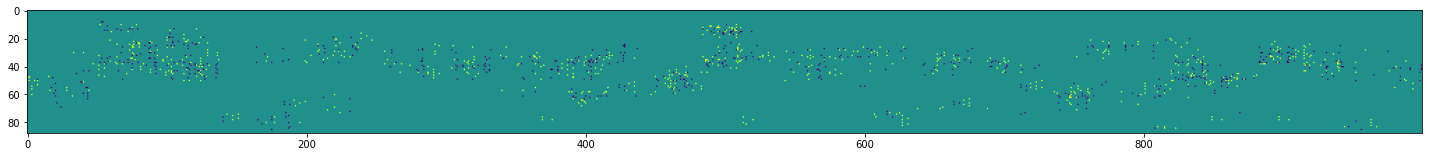

Epoch [   37/  120] | d_loss: 1.9640 | g_loss: 127.8280
Epoch [   37/  120] | d_loss: 3.1621 | g_loss: 149.6767
Epoch [   38/  120] | d_loss: 2.2458 | g_loss: 174.9908
Epoch [   38/  120] | d_loss: 2.2548 | g_loss: 185.5203
Epoch [   39/  120] | d_loss: 2.8073 | g_loss: 186.5798
Epoch [   39/  120] | d_loss: 2.3369 | g_loss: 200.2301
Epoch [   40/  120] | d_loss: 5.0753 | g_loss: 172.1753
Epoch [   40/  120] | d_loss: 2.9926 | g_loss: 174.5525
Epoch [   41/  120] | d_loss: 3.1762 | g_loss: 165.5396
Epoch [   41/  120] | d_loss: 3.3172 | g_loss: 168.1315


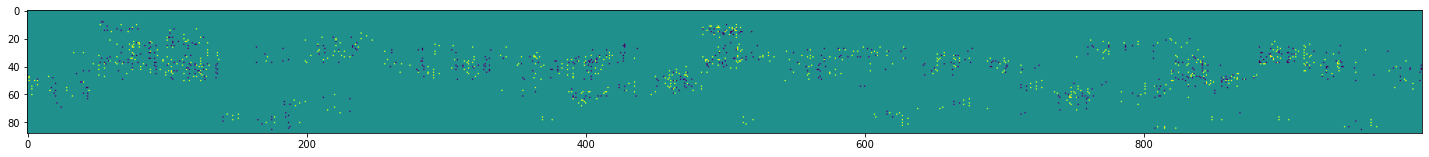

Epoch [   42/  120] | d_loss: 1.6277 | g_loss: 116.9116
Epoch [   42/  120] | d_loss: 4.9512 | g_loss: 122.9143
Epoch [   43/  120] | d_loss: 1.7991 | g_loss: 167.3402
Epoch [   43/  120] | d_loss: 1.8635 | g_loss: 161.8634
Epoch [   44/  120] | d_loss: 1.5748 | g_loss: 167.0983
Epoch [   44/  120] | d_loss: 1.3344 | g_loss: 156.1861
Epoch [   45/  120] | d_loss: 1.6582 | g_loss: 159.5431
Epoch [   45/  120] | d_loss: 1.1102 | g_loss: 152.0680
Epoch [   46/  120] | d_loss: 1.4108 | g_loss: 154.4088
Epoch [   46/  120] | d_loss: 1.4646 | g_loss: 148.0310


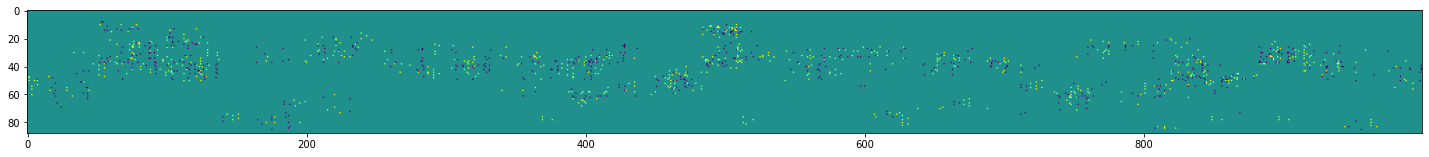

Epoch [   47/  120] | d_loss: 1.8105 | g_loss: 98.7278
Epoch [   47/  120] | d_loss: 1.5447 | g_loss: 104.0407
Epoch [   48/  120] | d_loss: 1.6306 | g_loss: 143.7335
Epoch [   48/  120] | d_loss: 1.1892 | g_loss: 151.0182
Epoch [   49/  120] | d_loss: 1.5567 | g_loss: 145.6828
Epoch [   49/  120] | d_loss: 1.8113 | g_loss: 129.5377
Epoch [   50/  120] | d_loss: 1.7044 | g_loss: 139.8978
Epoch [   50/  120] | d_loss: 1.8975 | g_loss: 132.2100
Epoch [   51/  120] | d_loss: 1.1390 | g_loss: 130.3396
Epoch [   51/  120] | d_loss: 1.1055 | g_loss: 140.0095


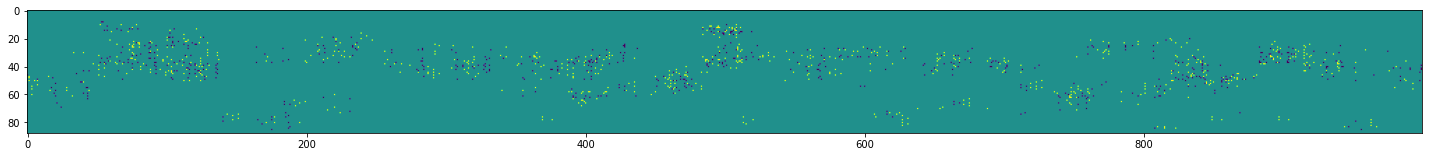

Epoch [   52/  120] | d_loss: 0.9997 | g_loss: 94.4540
Epoch [   52/  120] | d_loss: 0.9128 | g_loss: 90.0970
Epoch [   53/  120] | d_loss: 0.7546 | g_loss: 124.0990
Epoch [   53/  120] | d_loss: 0.9116 | g_loss: 120.4792
Epoch [   54/  120] | d_loss: 0.8349 | g_loss: 114.2806
Epoch [   54/  120] | d_loss: 0.7977 | g_loss: 125.3330
Epoch [   55/  120] | d_loss: 3.1840 | g_loss: 110.1844
Epoch [   55/  120] | d_loss: 1.4146 | g_loss: 103.8518
Epoch [   56/  120] | d_loss: 2.2882 | g_loss: 97.6175
Epoch [   56/  120] | d_loss: 2.2074 | g_loss: 101.2593


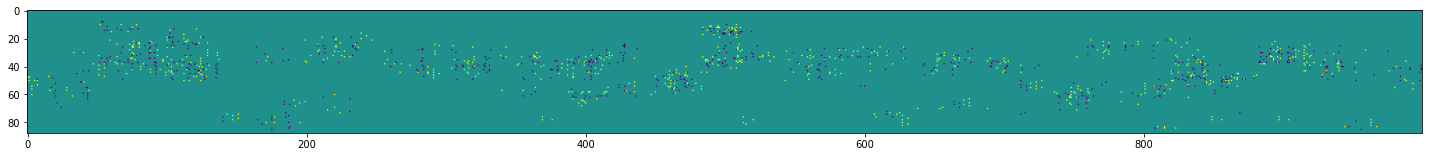

Epoch [   57/  120] | d_loss: 1.3004 | g_loss: 69.5617
Epoch [   57/  120] | d_loss: 1.3853 | g_loss: 78.7109
Epoch [   58/  120] | d_loss: 1.6363 | g_loss: 105.2493
Epoch [   58/  120] | d_loss: 1.7553 | g_loss: 99.7309
Epoch [   59/  120] | d_loss: 1.5043 | g_loss: 92.7981
Epoch [   59/  120] | d_loss: 1.4531 | g_loss: 86.9676
Epoch [   60/  120] | d_loss: 1.2424 | g_loss: 89.6294
Epoch [   60/  120] | d_loss: 0.7975 | g_loss: 86.1245
Epoch [   61/  120] | d_loss: 1.3306 | g_loss: 84.7053
Epoch [   61/  120] | d_loss: 0.9573 | g_loss: 87.5629


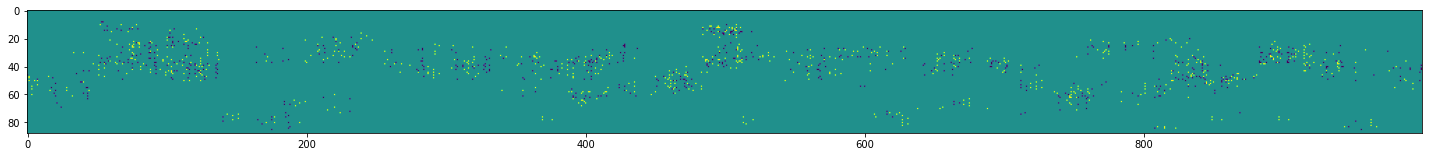

Epoch [   62/  120] | d_loss: 0.9071 | g_loss: 52.6156
Epoch [   62/  120] | d_loss: 1.0996 | g_loss: 46.0822
Epoch [   63/  120] | d_loss: 1.1098 | g_loss: 74.7492
Epoch [   63/  120] | d_loss: 0.7284 | g_loss: 81.2815
Epoch [   64/  120] | d_loss: 2.2501 | g_loss: 83.5641
Epoch [   64/  120] | d_loss: 0.6438 | g_loss: 71.9886
Epoch [   65/  120] | d_loss: 0.9291 | g_loss: 75.0734
Epoch [   65/  120] | d_loss: 0.8164 | g_loss: 77.9964
Epoch [   66/  120] | d_loss: 0.8263 | g_loss: 76.0336
Epoch [   66/  120] | d_loss: 0.6305 | g_loss: 74.8985


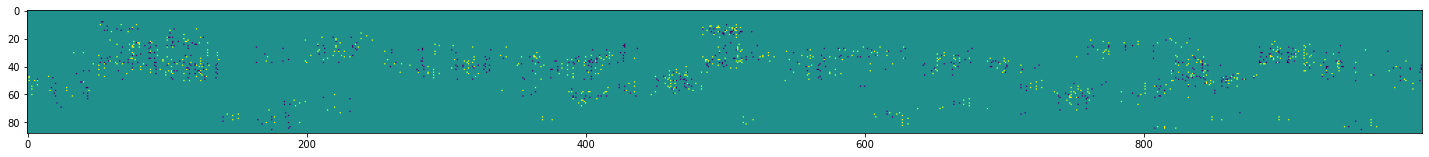

Epoch [   67/  120] | d_loss: 0.4993 | g_loss: 50.2517
Epoch [   67/  120] | d_loss: 0.5100 | g_loss: 51.0190
Epoch [   68/  120] | d_loss: 0.4824 | g_loss: 70.4240
Epoch [   68/  120] | d_loss: 0.6371 | g_loss: 72.3137
Epoch [   69/  120] | d_loss: 0.6593 | g_loss: 71.1904
Epoch [   69/  120] | d_loss: 0.5608 | g_loss: 70.9616
Epoch [   70/  120] | d_loss: 0.4663 | g_loss: 69.7449
Epoch [   70/  120] | d_loss: 0.4809 | g_loss: 69.4833
Epoch [   71/  120] | d_loss: 0.5569 | g_loss: 60.6910
Epoch [   71/  120] | d_loss: 0.5358 | g_loss: 68.7362


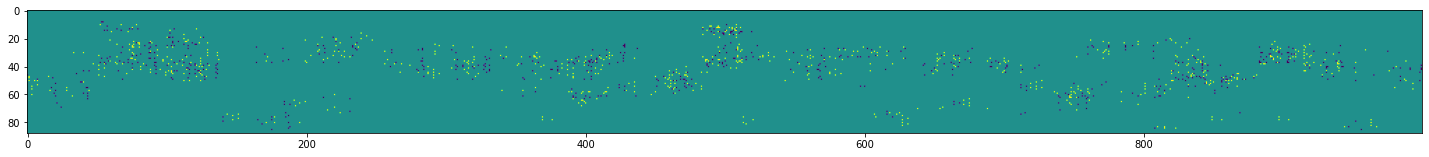

Epoch [   72/  120] | d_loss: 0.6241 | g_loss: 45.8905
Epoch [   72/  120] | d_loss: 0.5823 | g_loss: 46.9939
Epoch [   73/  120] | d_loss: 0.5640 | g_loss: 63.1365
Epoch [   73/  120] | d_loss: 0.6417 | g_loss: 64.5996
Epoch [   74/  120] | d_loss: 0.5024 | g_loss: 64.4237
Epoch [   74/  120] | d_loss: 0.6024 | g_loss: 61.3647
Epoch [   75/  120] | d_loss: 0.4957 | g_loss: 59.6117
Epoch [   75/  120] | d_loss: 0.4631 | g_loss: 56.1168
Epoch [   76/  120] | d_loss: 0.5429 | g_loss: 63.8878
Epoch [   76/  120] | d_loss: 0.4550 | g_loss: 60.7696


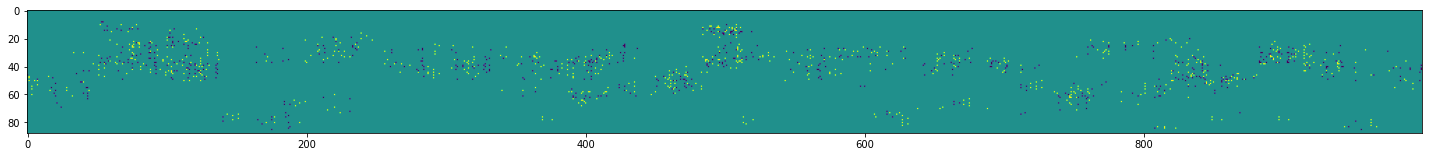

Epoch [   77/  120] | d_loss: 0.4416 | g_loss: 42.2377
Epoch [   77/  120] | d_loss: 0.4802 | g_loss: 41.7425
Epoch [   78/  120] | d_loss: 0.3843 | g_loss: 57.2017
Epoch [   78/  120] | d_loss: 0.4816 | g_loss: 60.8897
Epoch [   79/  120] | d_loss: 0.5008 | g_loss: 54.4384
Epoch [   79/  120] | d_loss: 0.5461 | g_loss: 57.1607
Epoch [   80/  120] | d_loss: 0.4869 | g_loss: 60.5194
Epoch [   80/  120] | d_loss: 0.4426 | g_loss: 59.3686
Epoch [   81/  120] | d_loss: 0.4568 | g_loss: 56.0884
Epoch [   81/  120] | d_loss: 0.4391 | g_loss: 57.7934


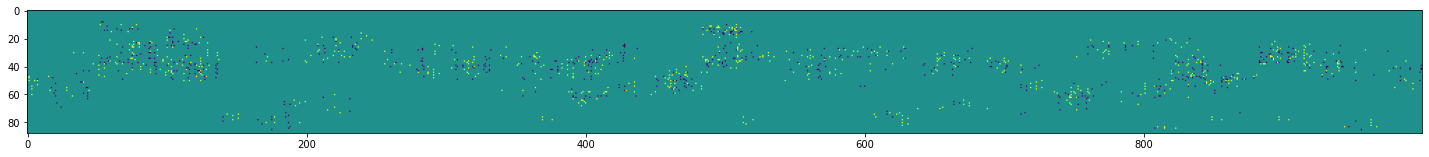

Epoch [   82/  120] | d_loss: 0.4308 | g_loss: 42.3312
Epoch [   82/  120] | d_loss: 0.4020 | g_loss: 40.8120
Epoch [   83/  120] | d_loss: 0.3855 | g_loss: 55.8535
Epoch [   83/  120] | d_loss: 0.4033 | g_loss: 52.4743
Epoch [   84/  120] | d_loss: 0.3904 | g_loss: 54.2958
Epoch [   84/  120] | d_loss: 0.3671 | g_loss: 54.2987
Epoch [   85/  120] | d_loss: 0.4206 | g_loss: 58.4777
Epoch [   85/  120] | d_loss: 0.3706 | g_loss: 54.7984
Epoch [   86/  120] | d_loss: 0.4089 | g_loss: 52.8457
Epoch [   86/  120] | d_loss: 0.4606 | g_loss: 51.1158


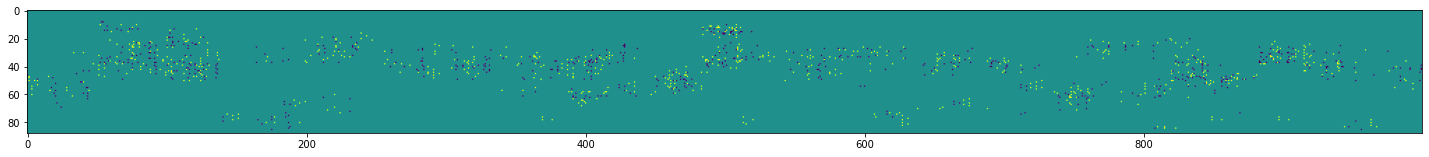

Epoch [   87/  120] | d_loss: 0.4096 | g_loss: 37.2160
Epoch [   87/  120] | d_loss: 0.3762 | g_loss: 40.0128
Epoch [   88/  120] | d_loss: 0.4411 | g_loss: 52.2309
Epoch [   88/  120] | d_loss: 0.4427 | g_loss: 54.3212
Epoch [   89/  120] | d_loss: 0.4742 | g_loss: 46.7635
Epoch [   89/  120] | d_loss: 0.3886 | g_loss: 56.7695
Epoch [   90/  120] | d_loss: 0.3693 | g_loss: 49.5694
Epoch [   90/  120] | d_loss: 0.3566 | g_loss: 51.1103
Epoch [   91/  120] | d_loss: 0.4068 | g_loss: 52.5596
Epoch [   91/  120] | d_loss: 0.4512 | g_loss: 52.7870


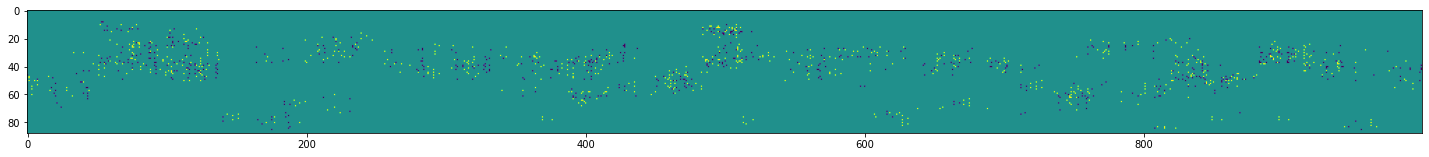

Epoch [   92/  120] | d_loss: 0.4596 | g_loss: 34.2272
Epoch [   92/  120] | d_loss: 0.4198 | g_loss: 33.9450
Epoch [   93/  120] | d_loss: 0.4926 | g_loss: 46.2498
Epoch [   93/  120] | d_loss: 0.4495 | g_loss: 51.1825
Epoch [   94/  120] | d_loss: 0.3837 | g_loss: 48.7678
Epoch [   94/  120] | d_loss: 0.4538 | g_loss: 45.5759
Epoch [   95/  120] | d_loss: 0.4191 | g_loss: 49.1780
Epoch [   95/  120] | d_loss: 0.3909 | g_loss: 49.7903
Epoch [   96/  120] | d_loss: 0.4324 | g_loss: 44.4768
Epoch [   96/  120] | d_loss: 0.3942 | g_loss: 49.5736


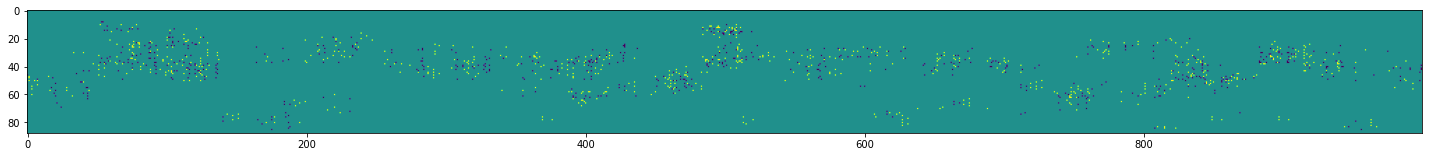

Epoch [   97/  120] | d_loss: 0.4031 | g_loss: 32.8619
Epoch [   97/  120] | d_loss: 0.4055 | g_loss: 32.3495
Epoch [   98/  120] | d_loss: 0.4454 | g_loss: 47.7028
Epoch [   98/  120] | d_loss: 0.3434 | g_loss: 48.9194
Epoch [   99/  120] | d_loss: 0.4101 | g_loss: 45.3412
Epoch [   99/  120] | d_loss: 0.3605 | g_loss: 44.5657
Epoch [  100/  120] | d_loss: 0.3702 | g_loss: 51.3795
Epoch [  100/  120] | d_loss: 0.3477 | g_loss: 46.6005
Epoch [  101/  120] | d_loss: 0.3669 | g_loss: 44.1318
Epoch [  101/  120] | d_loss: 0.3612 | g_loss: 45.9232


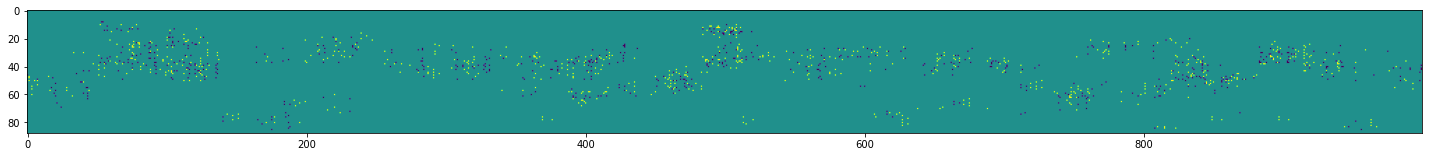

Epoch [  102/  120] | d_loss: 0.3600 | g_loss: 33.2092
Epoch [  102/  120] | d_loss: 0.3659 | g_loss: 33.1810
Epoch [  103/  120] | d_loss: 0.3937 | g_loss: 45.1252
Epoch [  103/  120] | d_loss: 0.3619 | g_loss: 45.7008
Epoch [  104/  120] | d_loss: 0.4732 | g_loss: 45.8561
Epoch [  104/  120] | d_loss: 0.3844 | g_loss: 46.8495
Epoch [  105/  120] | d_loss: 0.3908 | g_loss: 45.6697
Epoch [  105/  120] | d_loss: 0.3730 | g_loss: 48.5167
Epoch [  106/  120] | d_loss: 0.3571 | g_loss: 44.8026
Epoch [  106/  120] | d_loss: 0.3678 | g_loss: 41.7698


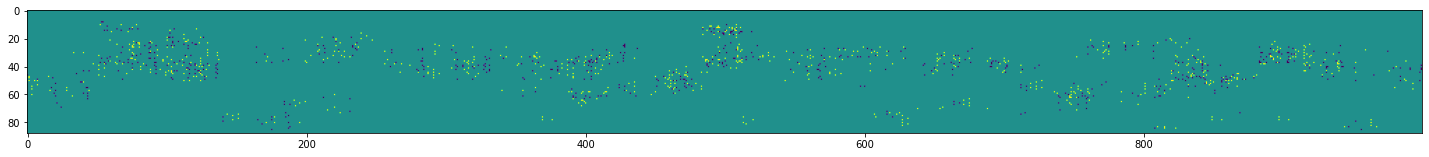

Epoch [  107/  120] | d_loss: 0.3933 | g_loss: 30.8569
Epoch [  107/  120] | d_loss: 0.3530 | g_loss: 31.2537
Epoch [  108/  120] | d_loss: 0.3705 | g_loss: 46.1359
Epoch [  108/  120] | d_loss: 0.3430 | g_loss: 45.0615
Epoch [  109/  120] | d_loss: 0.3770 | g_loss: 44.5242
Epoch [  109/  120] | d_loss: 0.3429 | g_loss: 41.5799
Epoch [  110/  120] | d_loss: 0.3478 | g_loss: 43.9385
Epoch [  110/  120] | d_loss: 0.3573 | g_loss: 44.8442
Epoch [  111/  120] | d_loss: 0.3575 | g_loss: 42.8112
Epoch [  111/  120] | d_loss: 0.3700 | g_loss: 44.9372


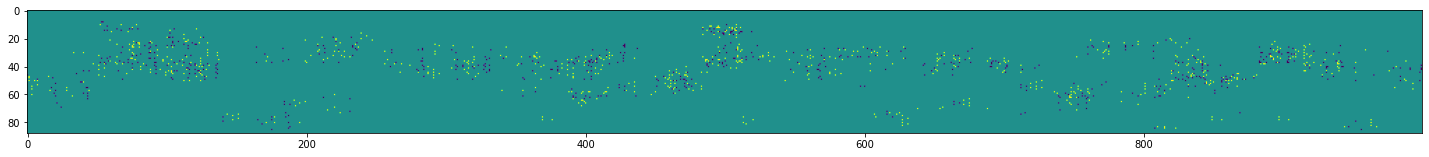

Epoch [  112/  120] | d_loss: 0.3569 | g_loss: 29.5306
Epoch [  112/  120] | d_loss: 0.3789 | g_loss: 29.7675
Epoch [  113/  120] | d_loss: 0.3534 | g_loss: 39.3185
Epoch [  113/  120] | d_loss: 0.3519 | g_loss: 43.1417
Epoch [  114/  120] | d_loss: 0.3502 | g_loss: 43.0838
Epoch [  114/  120] | d_loss: 0.3368 | g_loss: 43.8546
Epoch [  115/  120] | d_loss: 0.3431 | g_loss: 44.5031
Epoch [  115/  120] | d_loss: 0.3407 | g_loss: 40.5352
Epoch [  116/  120] | d_loss: 0.3456 | g_loss: 41.8079
Epoch [  116/  120] | d_loss: 0.3336 | g_loss: 41.7151


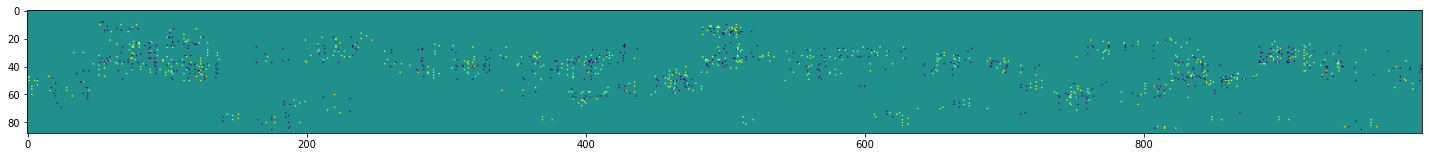

Epoch [  117/  120] | d_loss: 0.3417 | g_loss: 33.8248
Epoch [  117/  120] | d_loss: 0.3389 | g_loss: 29.3223
Epoch [  118/  120] | d_loss: 0.3353 | g_loss: 40.8731
Epoch [  118/  120] | d_loss: 0.3434 | g_loss: 39.6287
Epoch [  119/  120] | d_loss: 0.3444 | g_loss: 40.9800
Epoch [  119/  120] | d_loss: 0.3385 | g_loss: 41.3234
Epoch [  120/  120] | d_loss: 0.3465 | g_loss: 40.2797
Epoch [  120/  120] | d_loss: 0.3471 | g_loss: 39.5024


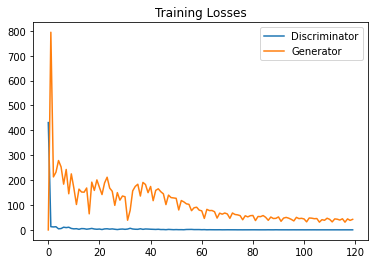

In [ ]:
# Size of input image to discriminator (28*28)
input_size = 1
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layers in the discriminator and the generator
hidden_size = 256
# Size of latent vector to give to generator
z_size = 200
batch_size = 20

try:
  del D
  del G
  torch.cuda.empty_cache()
  gc.collect()
  print("cache is cleard")
except:
  print("did not delete chache")

load_models = False
D = Discriminator(batch_size, input_size, hidden_size, d_output_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, output_size, scale
G = Generator(batch_size, input_size, hidden_size, z_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, latent, scale
RH = RNNHands(z_size).to(device)
LH = RNNHands(z_size).to(device)
C = RNNchords(z_size).to(device)
HOH = OneHotHands().to(device)
COH = OneHotChords().to(device)
if load_models:
    checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models2/compose{}.pk'
    G.load_state_dict(torch.load(checkpoint_path.format("G" + str(load_models)), map_location=torch.device('cuda')))
    D.load_state_dict(torch.load(checkpoint_path.format("D" + str(load_models)), map_location=torch.device('cuda')))

train(G, D, RH, LH, C, HOH, COH, images_arr,batch_size = 20, z_size=200, lr=0.02, num_epochs=120)
# plot_grad_flow(G.cpu().named_parameters())

**As discussed above** in the previous example, even after increasing the number of epochs to 120, thus leads to convergence, this parameters still fail to reduce the g_loss value.

Therefore, we would choose a smaller learning rate, with the same parameters (these are the parameters that brought us to the best results).

### **Train With chosen parameters**

cache is cleard
Epoch [    1/  120] | d_loss: 1.4497 | g_loss: 41.0822
Epoch [    1/  120] | d_loss: 12.8048 | g_loss: 28.4157


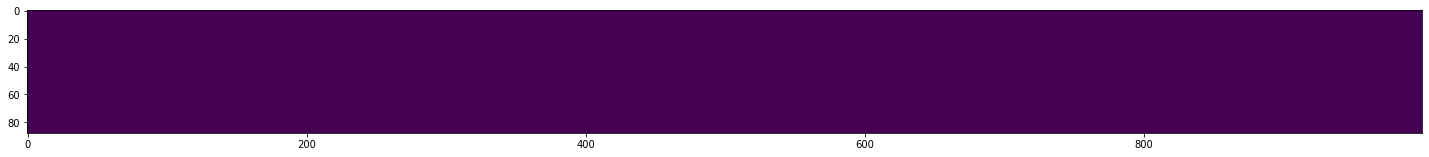

Epoch [    2/  120] | d_loss: 5.6432 | g_loss: 14.3939
Epoch [    2/  120] | d_loss: 4.4095 | g_loss: 39.5690
Epoch [    3/  120] | d_loss: 21.5476 | g_loss: 9.1298
Epoch [    3/  120] | d_loss: 1.4224 | g_loss: 53.8580
Epoch [    4/  120] | d_loss: 6.3218 | g_loss: 66.5108
Epoch [    4/  120] | d_loss: 1.4036 | g_loss: 60.7142
Epoch [    5/  120] | d_loss: 2.0507 | g_loss: 54.4254
Epoch [    5/  120] | d_loss: 3.4994 | g_loss: 50.1956
Epoch [    6/  120] | d_loss: 3.4491 | g_loss: 55.5166
Epoch [    6/  120] | d_loss: 3.1978 | g_loss: 63.1439


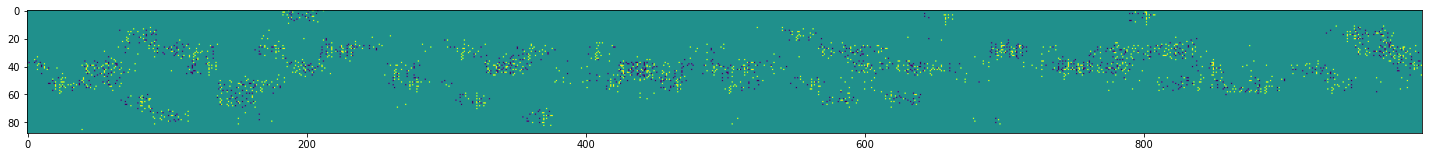

Epoch [    7/  120] | d_loss: 2.5639 | g_loss: 56.5191
Epoch [    7/  120] | d_loss: 1.5580 | g_loss: 64.5739
Epoch [    8/  120] | d_loss: 1.1361 | g_loss: 86.4724
Epoch [    8/  120] | d_loss: 2.5386 | g_loss: 84.0230
Epoch [    9/  120] | d_loss: 1.2570 | g_loss: 67.1792
Epoch [    9/  120] | d_loss: 1.3503 | g_loss: 61.5374
Epoch [   10/  120] | d_loss: 1.5762 | g_loss: 62.2369
Epoch [   10/  120] | d_loss: 1.3007 | g_loss: 63.4792
Epoch [   11/  120] | d_loss: 0.9649 | g_loss: 66.1742
Epoch [   11/  120] | d_loss: 1.1827 | g_loss: 66.1778


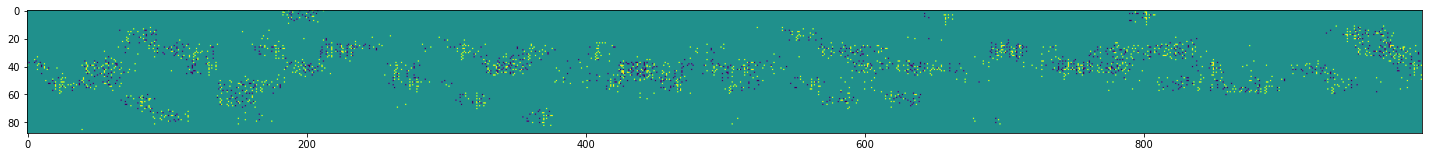

Epoch [   12/  120] | d_loss: 1.5013 | g_loss: 46.8948
Epoch [   12/  120] | d_loss: 1.0484 | g_loss: 43.6967
Epoch [   13/  120] | d_loss: 1.2745 | g_loss: 51.9061
Epoch [   13/  120] | d_loss: 1.0092 | g_loss: 53.8915
Epoch [   14/  120] | d_loss: 0.9942 | g_loss: 55.0811
Epoch [   14/  120] | d_loss: 0.6960 | g_loss: 45.0468
Epoch [   15/  120] | d_loss: 0.9752 | g_loss: 41.7640
Epoch [   15/  120] | d_loss: 0.7721 | g_loss: 48.2850
Epoch [   16/  120] | d_loss: 0.8765 | g_loss: 46.7677
Epoch [   16/  120] | d_loss: 0.6955 | g_loss: 43.3681


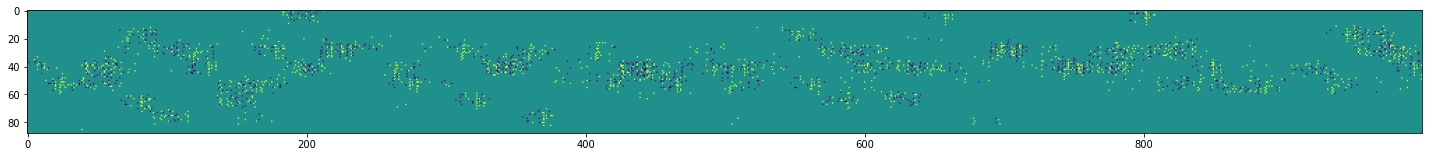

Epoch [   17/  120] | d_loss: 0.7062 | g_loss: 38.8414
Epoch [   17/  120] | d_loss: 0.5699 | g_loss: 39.8829
Epoch [   18/  120] | d_loss: 0.8014 | g_loss: 42.9793
Epoch [   18/  120] | d_loss: 0.5833 | g_loss: 40.6266
Epoch [   19/  120] | d_loss: 0.5480 | g_loss: 43.3151
Epoch [   19/  120] | d_loss: 0.5253 | g_loss: 44.3917
Epoch [   20/  120] | d_loss: 1.0408 | g_loss: 39.4447
Epoch [   20/  120] | d_loss: 0.7207 | g_loss: 38.4595
Epoch [   21/  120] | d_loss: 0.4215 | g_loss: 43.5690
Epoch [   21/  120] | d_loss: 0.7202 | g_loss: 39.9617


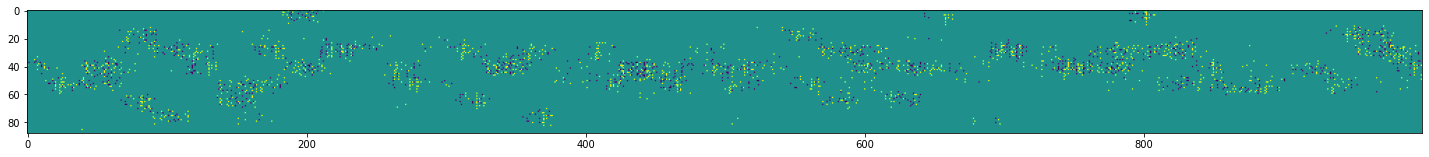

Epoch [   22/  120] | d_loss: 0.5415 | g_loss: 31.9912
Epoch [   22/  120] | d_loss: 0.4422 | g_loss: 34.9890
Epoch [   23/  120] | d_loss: 0.9538 | g_loss: 37.2419
Epoch [   23/  120] | d_loss: 0.7053 | g_loss: 34.5076
Epoch [   24/  120] | d_loss: 0.9570 | g_loss: 34.1595
Epoch [   24/  120] | d_loss: 0.6113 | g_loss: 41.0148
Epoch [   25/  120] | d_loss: 1.1360 | g_loss: 37.3426
Epoch [   25/  120] | d_loss: 0.7375 | g_loss: 32.3884
Epoch [   26/  120] | d_loss: 0.7730 | g_loss: 31.5829
Epoch [   26/  120] | d_loss: 0.4768 | g_loss: 39.4001


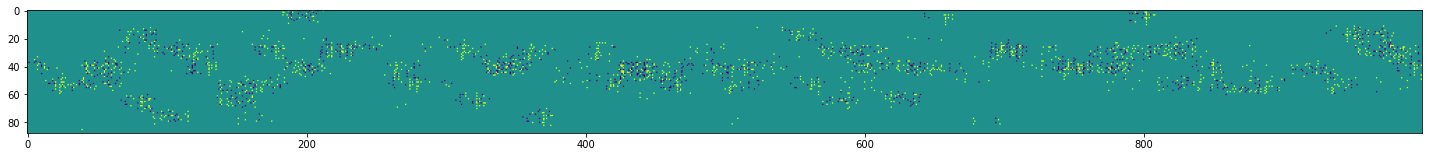

Epoch [   27/  120] | d_loss: 0.8006 | g_loss: 26.2289
Epoch [   27/  120] | d_loss: 0.7280 | g_loss: 23.4543
Epoch [   28/  120] | d_loss: 0.7596 | g_loss: 31.7446
Epoch [   28/  120] | d_loss: 0.9200 | g_loss: 31.2197
Epoch [   29/  120] | d_loss: 0.6899 | g_loss: 30.0831
Epoch [   29/  120] | d_loss: 0.4492 | g_loss: 34.5005
Epoch [   30/  120] | d_loss: 0.7753 | g_loss: 29.7966
Epoch [   30/  120] | d_loss: 0.7567 | g_loss: 28.3751
Epoch [   31/  120] | d_loss: 0.5022 | g_loss: 34.4218
Epoch [   31/  120] | d_loss: 1.1670 | g_loss: 28.7506


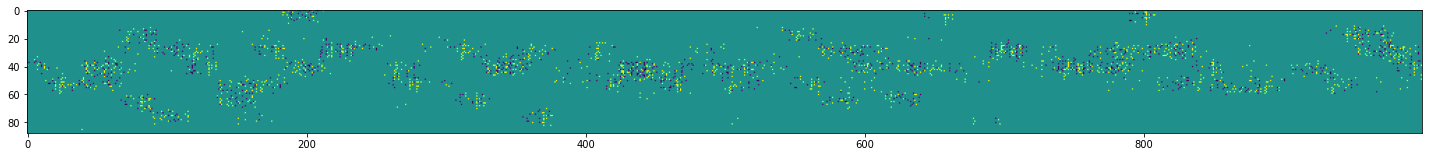

Epoch [   32/  120] | d_loss: 0.9349 | g_loss: 18.4139
Epoch [   32/  120] | d_loss: 1.0390 | g_loss: 21.1958
Epoch [   33/  120] | d_loss: 0.5675 | g_loss: 31.9352
Epoch [   33/  120] | d_loss: 1.6458 | g_loss: 29.1633
Epoch [   34/  120] | d_loss: 1.0293 | g_loss: 23.1701
Epoch [   34/  120] | d_loss: 1.0331 | g_loss: 23.2589
Epoch [   35/  120] | d_loss: 0.7402 | g_loss: 29.6213
Epoch [   35/  120] | d_loss: 2.3405 | g_loss: 27.4899
Epoch [   36/  120] | d_loss: 0.7527 | g_loss: 20.5369
Epoch [   36/  120] | d_loss: 1.2140 | g_loss: 24.0785


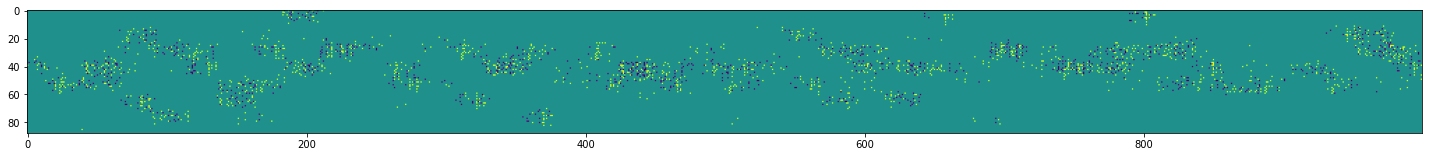

Epoch [   37/  120] | d_loss: 0.7108 | g_loss: 24.4527
Epoch [   37/  120] | d_loss: 0.6222 | g_loss: 25.7984
Epoch [   38/  120] | d_loss: 0.5493 | g_loss: 23.3145
Epoch [   38/  120] | d_loss: 0.9407 | g_loss: 25.9325
Epoch [   39/  120] | d_loss: 0.7311 | g_loss: 28.3401
Epoch [   39/  120] | d_loss: 0.6576 | g_loss: 24.5148
Epoch [   40/  120] | d_loss: 0.7392 | g_loss: 21.3718
Epoch [   40/  120] | d_loss: 0.6753 | g_loss: 24.0345
Epoch [   41/  120] | d_loss: 0.6866 | g_loss: 26.2524
Epoch [   41/  120] | d_loss: 0.7536 | g_loss: 25.5133


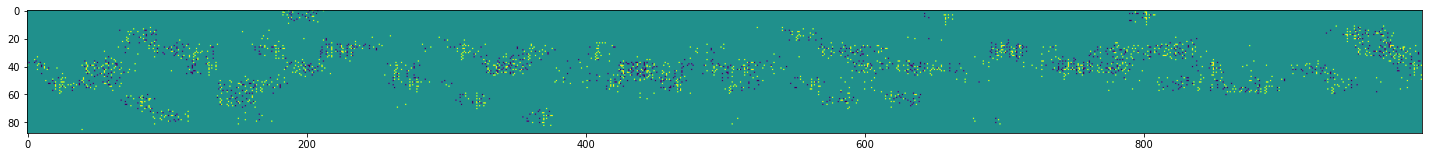

Epoch [   42/  120] | d_loss: 0.6195 | g_loss: 16.9274
Epoch [   42/  120] | d_loss: 0.6359 | g_loss: 18.4598
Epoch [   43/  120] | d_loss: 0.6524 | g_loss: 24.2276
Epoch [   43/  120] | d_loss: 0.6855 | g_loss: 25.6627
Epoch [   44/  120] | d_loss: 0.4801 | g_loss: 26.5395
Epoch [   44/  120] | d_loss: 0.6500 | g_loss: 20.7973
Epoch [   45/  120] | d_loss: 1.1664 | g_loss: 19.1518
Epoch [   45/  120] | d_loss: 0.8857 | g_loss: 23.5707
Epoch [   46/  120] | d_loss: 1.1316 | g_loss: 26.6655
Epoch [   46/  120] | d_loss: 0.6405 | g_loss: 25.1842


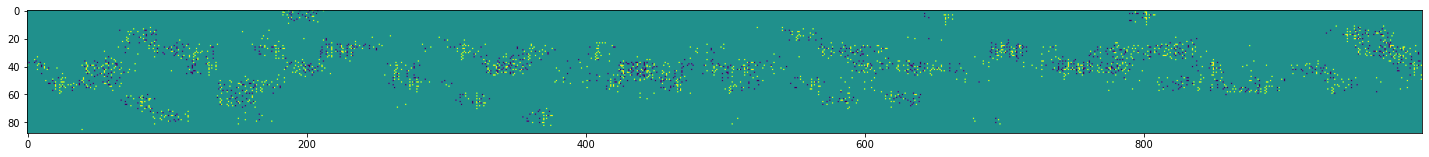

Epoch [   47/  120] | d_loss: 0.9061 | g_loss: 14.7274
Epoch [   47/  120] | d_loss: 0.9106 | g_loss: 16.4519
Epoch [   48/  120] | d_loss: 0.5857 | g_loss: 26.4783
Epoch [   48/  120] | d_loss: 1.6451 | g_loss: 20.1924
Epoch [   49/  120] | d_loss: 1.1072 | g_loss: 14.9863
Epoch [   49/  120] | d_loss: 1.2747 | g_loss: 17.7994
Epoch [   50/  120] | d_loss: 0.8684 | g_loss: 23.3712
Epoch [   50/  120] | d_loss: 1.8283 | g_loss: 25.0938
Epoch [   51/  120] | d_loss: 0.6195 | g_loss: 20.3057
Epoch [   51/  120] | d_loss: 0.7603 | g_loss: 18.0892


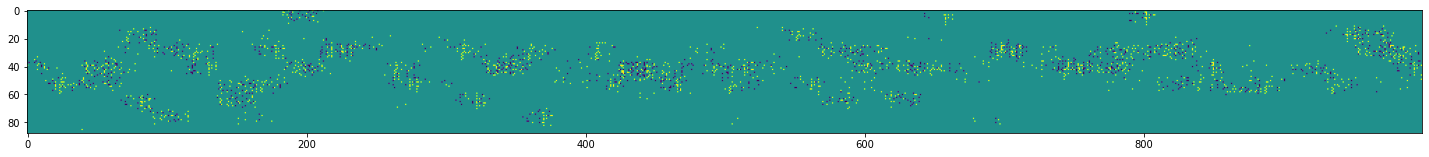

Epoch [   52/  120] | d_loss: 0.7753 | g_loss: 19.9519
Epoch [   52/  120] | d_loss: 0.7466 | g_loss: 10.6321
Epoch [   53/  120] | d_loss: 1.1343 | g_loss: 15.0713
Epoch [   53/  120] | d_loss: 0.7008 | g_loss: 16.1001
Epoch [   54/  120] | d_loss: 0.7251 | g_loss: 15.3615
Epoch [   54/  120] | d_loss: 0.6969 | g_loss: 18.7067
Epoch [   55/  120] | d_loss: 0.5679 | g_loss: 23.0644
Epoch [   55/  120] | d_loss: 1.0343 | g_loss: 18.9368
Epoch [   56/  120] | d_loss: 0.8154 | g_loss: 13.6955
Epoch [   56/  120] | d_loss: 0.8235 | g_loss: 18.2112


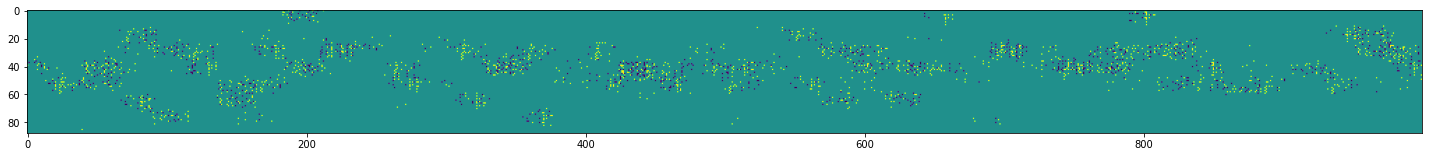

Epoch [   57/  120] | d_loss: 0.5518 | g_loss: 21.0362
Epoch [   57/  120] | d_loss: 0.7074 | g_loss: 15.6406
Epoch [   58/  120] | d_loss: 0.8051 | g_loss: 18.7935
Epoch [   58/  120] | d_loss: 0.6627 | g_loss: 25.6359
Epoch [   59/  120] | d_loss: 0.6067 | g_loss: 22.3348
Epoch [   59/  120] | d_loss: 0.5592 | g_loss: 23.8305
Epoch [   60/  120] | d_loss: 0.5803 | g_loss: 18.5640
Epoch [   60/  120] | d_loss: 0.7588 | g_loss: 17.3811
Epoch [   61/  120] | d_loss: 0.4765 | g_loss: 20.9688
Epoch [   61/  120] | d_loss: 0.7061 | g_loss: 12.0677


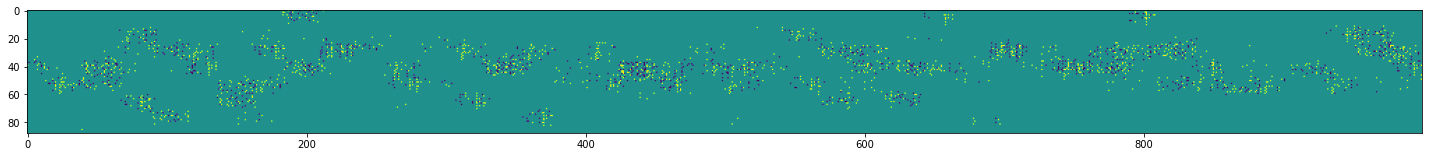

Epoch [   62/  120] | d_loss: 0.9696 | g_loss: 9.8574
Epoch [   62/  120] | d_loss: 0.7253 | g_loss: 15.3166
Epoch [   63/  120] | d_loss: 1.2416 | g_loss: 19.9525
Epoch [   63/  120] | d_loss: 0.5624 | g_loss: 14.9100
Epoch [   64/  120] | d_loss: 0.7082 | g_loss: 19.5738
Epoch [   64/  120] | d_loss: 0.7383 | g_loss: 19.3767
Epoch [   65/  120] | d_loss: 0.5937 | g_loss: 18.2822
Epoch [   65/  120] | d_loss: 0.6743 | g_loss: 17.6216
Epoch [   66/  120] | d_loss: 0.5616 | g_loss: 23.1335
Epoch [   66/  120] | d_loss: 0.7084 | g_loss: 21.7091


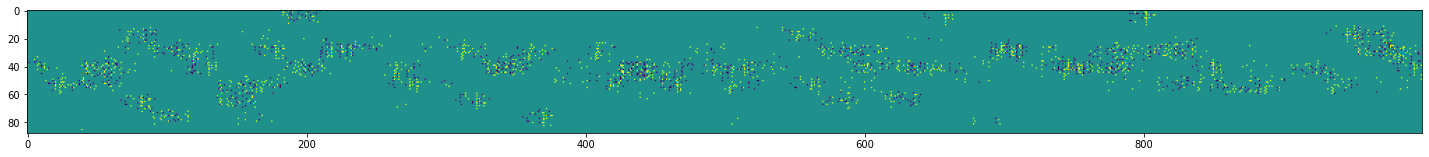

Epoch [   67/  120] | d_loss: 0.4866 | g_loss: 16.6807
Epoch [   67/  120] | d_loss: 0.5180 | g_loss: 18.2301
Epoch [   68/  120] | d_loss: 0.7762 | g_loss: 21.9147
Epoch [   68/  120] | d_loss: 0.6696 | g_loss: 13.5449
Epoch [   69/  120] | d_loss: 0.7078 | g_loss: 14.7567
Epoch [   69/  120] | d_loss: 0.6433 | g_loss: 20.9952
Epoch [   70/  120] | d_loss: 0.5853 | g_loss: 14.7530
Epoch [   70/  120] | d_loss: 0.8859 | g_loss: 14.7573
Epoch [   71/  120] | d_loss: 0.6642 | g_loss: 20.0967
Epoch [   71/  120] | d_loss: 0.4184 | g_loss: 19.7743


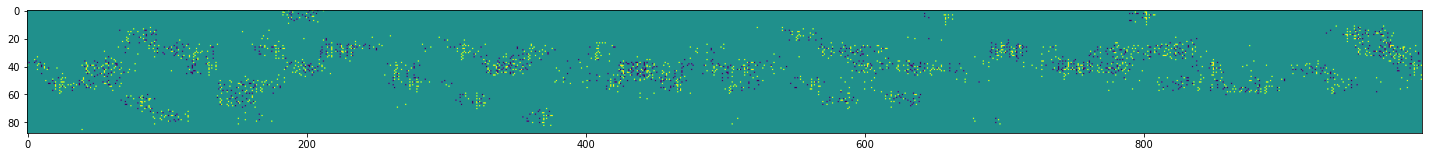

Epoch [   72/  120] | d_loss: 0.5905 | g_loss: 9.4611
Epoch [   72/  120] | d_loss: 0.8841 | g_loss: 10.8980
Epoch [   73/  120] | d_loss: 0.5651 | g_loss: 19.4693
Epoch [   73/  120] | d_loss: 0.8249 | g_loss: 16.3203
Epoch [   74/  120] | d_loss: 0.7700 | g_loss: 12.7231
Epoch [   74/  120] | d_loss: 0.6965 | g_loss: 15.8855
Epoch [   75/  120] | d_loss: 0.7272 | g_loss: 21.5708
Epoch [   75/  120] | d_loss: 0.6433 | g_loss: 17.2283
Epoch [   76/  120] | d_loss: 0.8488 | g_loss: 14.2565
Epoch [   76/  120] | d_loss: 0.6218 | g_loss: 18.6311


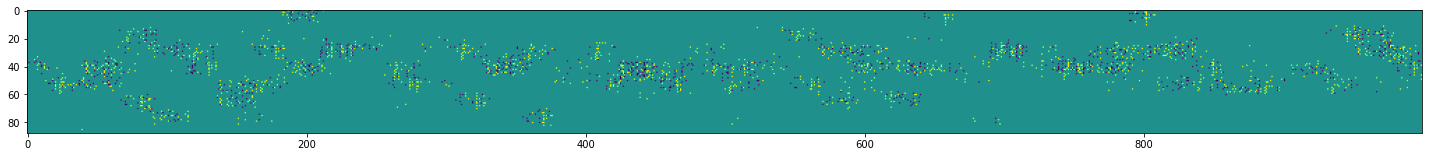

Epoch [   77/  120] | d_loss: 0.9371 | g_loss: 18.2008
Epoch [   77/  120] | d_loss: 0.6885 | g_loss: 14.9798
Epoch [   78/  120] | d_loss: 0.6463 | g_loss: 18.5972
Epoch [   78/  120] | d_loss: 0.4864 | g_loss: 26.6165
Epoch [   79/  120] | d_loss: 0.9265 | g_loss: 20.5542
Epoch [   79/  120] | d_loss: 0.8914 | g_loss: 13.4276
Epoch [   80/  120] | d_loss: 1.0483 | g_loss: 15.0362
Epoch [   80/  120] | d_loss: 0.7219 | g_loss: 21.1634
Epoch [   81/  120] | d_loss: 0.6675 | g_loss: 17.3060
Epoch [   81/  120] | d_loss: 0.9495 | g_loss: 17.3242


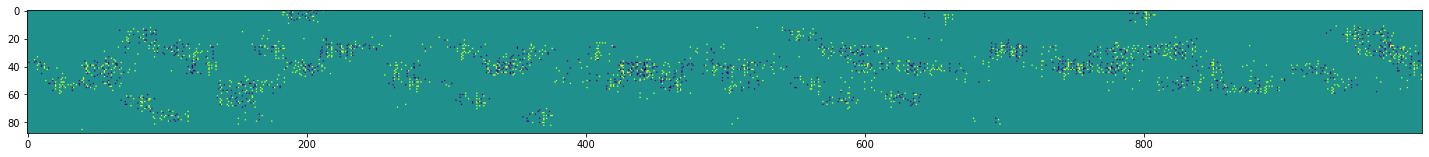

Epoch [   82/  120] | d_loss: 0.8564 | g_loss: 18.3833
Epoch [   82/  120] | d_loss: 0.6288 | g_loss: 16.4350
Epoch [   83/  120] | d_loss: 0.6359 | g_loss: 20.2333
Epoch [   83/  120] | d_loss: 0.6169 | g_loss: 20.8312
Epoch [   84/  120] | d_loss: 0.6403 | g_loss: 15.9740
Epoch [   84/  120] | d_loss: 0.5687 | g_loss: 15.8107
Epoch [   85/  120] | d_loss: 0.5814 | g_loss: 17.4953
Epoch [   85/  120] | d_loss: 0.5517 | g_loss: 16.0189
Epoch [   86/  120] | d_loss: 0.5525 | g_loss: 14.7748
Epoch [   86/  120] | d_loss: 0.6199 | g_loss: 16.5468


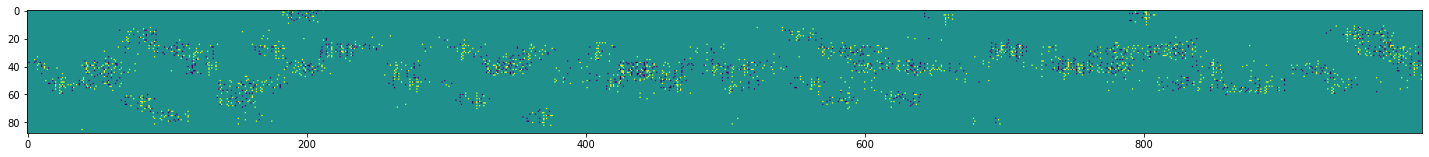

Epoch [   87/  120] | d_loss: 0.7910 | g_loss: 16.4903
Epoch [   87/  120] | d_loss: 0.5320 | g_loss: 15.6231
Epoch [   88/  120] | d_loss: 0.4762 | g_loss: 17.3170
Epoch [   88/  120] | d_loss: 0.6398 | g_loss: 16.3105
Epoch [   89/  120] | d_loss: 0.7947 | g_loss: 13.5020
Epoch [   89/  120] | d_loss: 0.5422 | g_loss: 20.3369
Epoch [   90/  120] | d_loss: 0.4756 | g_loss: 14.2426
Epoch [   90/  120] | d_loss: 0.7547 | g_loss: 15.5038
Epoch [   91/  120] | d_loss: 0.5532 | g_loss: 20.9426
Epoch [   91/  120] | d_loss: 0.5407 | g_loss: 17.2553


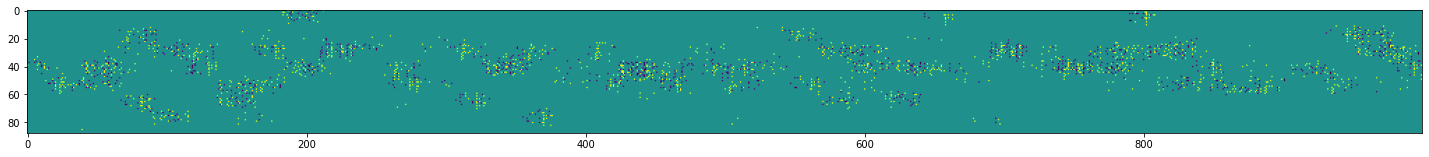

Epoch [   92/  120] | d_loss: 0.6761 | g_loss: 15.8925
Epoch [   92/  120] | d_loss: 0.4875 | g_loss: 17.1287
Epoch [   93/  120] | d_loss: 0.6151 | g_loss: 17.1471
Epoch [   93/  120] | d_loss: 0.6904 | g_loss: 11.8028
Epoch [   94/  120] | d_loss: 0.6866 | g_loss: 12.9025
Epoch [   94/  120] | d_loss: 0.8705 | g_loss: 13.7842
Epoch [   95/  120] | d_loss: 0.5870 | g_loss: 13.3563
Epoch [   95/  120] | d_loss: 0.4277 | g_loss: 16.7860
Epoch [   96/  120] | d_loss: 0.4037 | g_loss: 15.7750
Epoch [   96/  120] | d_loss: 0.4754 | g_loss: 16.4212


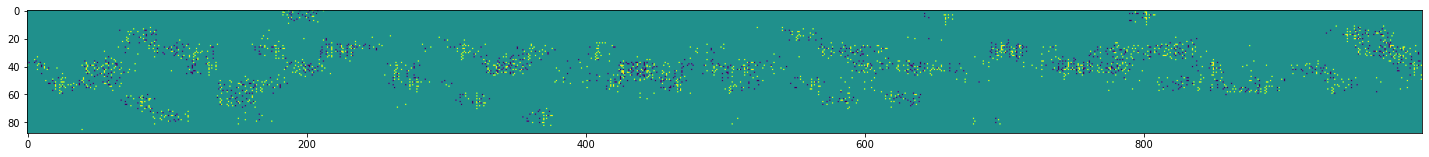

Epoch [   97/  120] | d_loss: 0.4908 | g_loss: 12.4134
Epoch [   97/  120] | d_loss: 0.6430 | g_loss: 12.0325
Epoch [   98/  120] | d_loss: 0.4883 | g_loss: 15.5605
Epoch [   98/  120] | d_loss: 0.4008 | g_loss: 14.2765
Epoch [   99/  120] | d_loss: 0.4924 | g_loss: 14.4500
Epoch [   99/  120] | d_loss: 0.4246 | g_loss: 15.5798
Epoch [  100/  120] | d_loss: 0.3770 | g_loss: 16.1513
Epoch [  100/  120] | d_loss: 0.4776 | g_loss: 15.5593
Epoch [  101/  120] | d_loss: 0.3862 | g_loss: 16.6766
Epoch [  101/  120] | d_loss: 0.4671 | g_loss: 11.9265


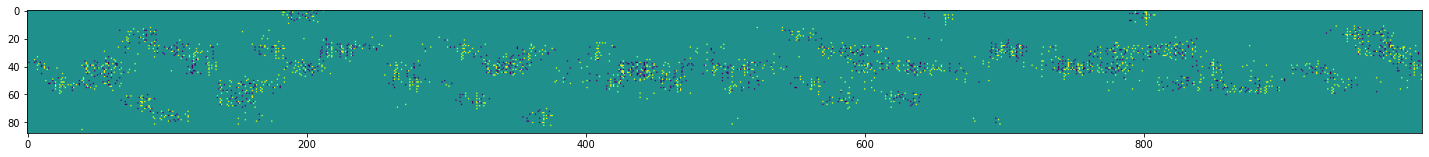

Epoch [  102/  120] | d_loss: 0.5646 | g_loss: 12.6736
Epoch [  102/  120] | d_loss: 0.4427 | g_loss: 17.8260
Epoch [  103/  120] | d_loss: 0.4618 | g_loss: 10.0108
Epoch [  103/  120] | d_loss: 0.8211 | g_loss: 10.9600
Epoch [  104/  120] | d_loss: 0.4971 | g_loss: 17.4084
Epoch [  104/  120] | d_loss: 0.8915 | g_loss: 11.4023
Epoch [  105/  120] | d_loss: 0.8177 | g_loss: 8.1093
Epoch [  105/  120] | d_loss: 0.7698 | g_loss: 11.9399
Epoch [  106/  120] | d_loss: 0.4251 | g_loss: 17.6095
Epoch [  106/  120] | d_loss: 0.4668 | g_loss: 10.4437


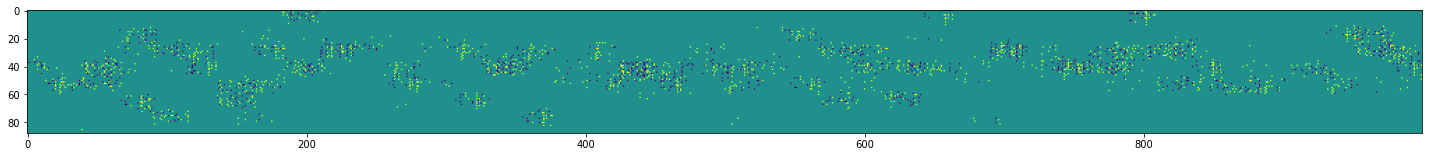

Epoch [  107/  120] | d_loss: 0.8617 | g_loss: 8.5128
Epoch [  107/  120] | d_loss: 0.6442 | g_loss: 15.7276
Epoch [  108/  120] | d_loss: 0.5749 | g_loss: 17.8970
Epoch [  108/  120] | d_loss: 0.5253 | g_loss: 16.2101
Epoch [  109/  120] | d_loss: 0.5964 | g_loss: 16.7254
Epoch [  109/  120] | d_loss: 0.6328 | g_loss: 15.7538
Epoch [  110/  120] | d_loss: 0.7939 | g_loss: 14.4602
Epoch [  110/  120] | d_loss: 0.6091 | g_loss: 19.7865
Epoch [  111/  120] | d_loss: 0.5005 | g_loss: 20.5673
Epoch [  111/  120] | d_loss: 0.4584 | g_loss: 16.0029


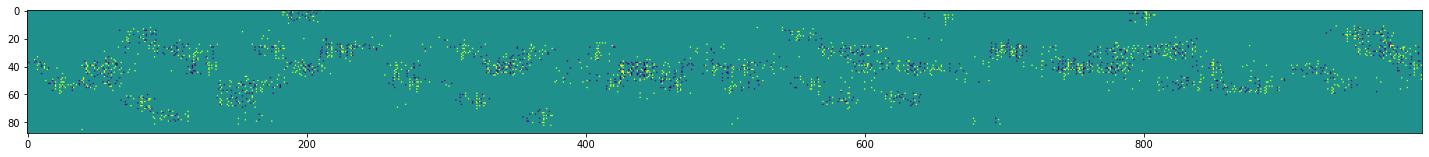

Epoch [  112/  120] | d_loss: 0.4276 | g_loss: 17.3897
Epoch [  112/  120] | d_loss: 0.7392 | g_loss: 15.6409
Epoch [  113/  120] | d_loss: 0.7365 | g_loss: 13.6325
Epoch [  113/  120] | d_loss: 0.4571 | g_loss: 18.0323
Epoch [  114/  120] | d_loss: 0.6385 | g_loss: 15.9976
Epoch [  114/  120] | d_loss: 0.6060 | g_loss: 13.3169
Epoch [  115/  120] | d_loss: 0.5126 | g_loss: 16.5211
Epoch [  115/  120] | d_loss: 0.5560 | g_loss: 15.3080
Epoch [  116/  120] | d_loss: 0.5380 | g_loss: 11.5478
Epoch [  116/  120] | d_loss: 0.6387 | g_loss: 15.4470


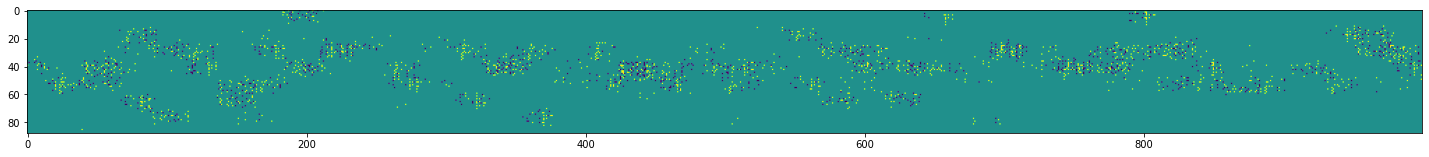

Epoch [  117/  120] | d_loss: 0.4561 | g_loss: 18.8182
Epoch [  117/  120] | d_loss: 0.4634 | g_loss: 15.6962
Epoch [  118/  120] | d_loss: 0.5498 | g_loss: 14.7418
Epoch [  118/  120] | d_loss: 0.4825 | g_loss: 17.1083
Epoch [  119/  120] | d_loss: 0.4173 | g_loss: 14.7076
Epoch [  119/  120] | d_loss: 0.4498 | g_loss: 15.1898
Epoch [  120/  120] | d_loss: 0.4936 | g_loss: 13.8952
Epoch [  120/  120] | d_loss: 0.5232 | g_loss: 14.2627


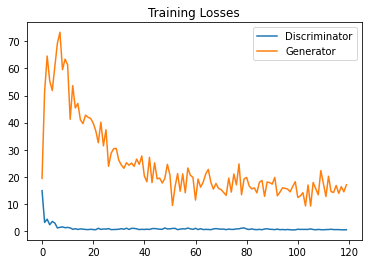

In [ ]:
# Size of input image to discriminator (28*28)
input_size = 1
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layers in the discriminator and the generator
hidden_size = 256
# Size of latent vector to give to generator
z_size = 200
batch_size = 20

try:
  del D
  del G
  torch.cuda.empty_cache()
  gc.collect()
  print("cache is cleard")
except:
  print("did not delete chache")

load_models = False
D = Discriminator(batch_size, input_size, hidden_size, d_output_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, output_size, scale
G = Generator(batch_size, input_size, hidden_size, z_size, major_scale).to(device) #batch_size, input_channels, num_hiddens, latent, scale
RH = RNNHands(z_size).to(device)
LH = RNNHands(z_size).to(device)
C = RNNchords(z_size).to(device)
HOH = OneHotHands().to(device)
COH = OneHotChords().to(device)
if load_models:
    checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models2/compose{}.pk'
    G.load_state_dict(torch.load(checkpoint_path.format("G" + str(load_models)), map_location=torch.device('cuda')))
    D.load_state_dict(torch.load(checkpoint_path.format("D" + str(load_models)), map_location=torch.device('cuda')))

train(G, D, RH, LH, C, HOH, COH, images_arr,batch_size = 20, z_size=200, lr=0.002, num_epochs=120)
# plot_grad_flow(G.cpu().named_parameters())

**Here we can see** that we get clear convergence, with the minimal value of g_loss - that we achieved.

We should note that whilst the graph does converge, the Generator (loss) does not reach the Discriminator (loss).

A few reasons for this difference are - 
* Small dataset - it's a simpler "job" for the discriminator to successfully distinguish the fake images from the real ones because there is less variety.
* Planning the architecture of the generator in complex models (like this one) is a more challenging task. For it needs to generate a whole image rather than one value.

In [ ]:
# this code was ment to save the model if required:
# checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/learn to compose/models/compose{}.pk'
# torch.save(G.state_dict(), checkpoint_path.format("G"))
# torch.save(D.state_dict(), checkpoint_path.format("D"))
# # 

## **Generate new classical piece**

After training our model with chosen hyperparameters, we would like to generate a new piece using our **generator model**.

In [ ]:
def generate_piece(z_size):
    generated_z = np.random.uniform(-1, 1, size=(2, z_size)) #the size of z (latent in VAE) what is the sample size???
    generated_z = torch.from_numpy(generated_z).to(device).float()
    plt.figure(figsize=(15,15))
    G.eval()
    music = G(generated_z, HOH(RH(generated_z)), HOH(LH(generated_z)), COH(C(generated_z))).detach().cpu()
    plt.figure(figsize= (25,3))
    plt.imshow(music[1,0,:,1000:2000])
    return music

**Generate a new piece with the latent, $z_t$ = 200**

<Figure size 1080x1080 with 0 Axes>

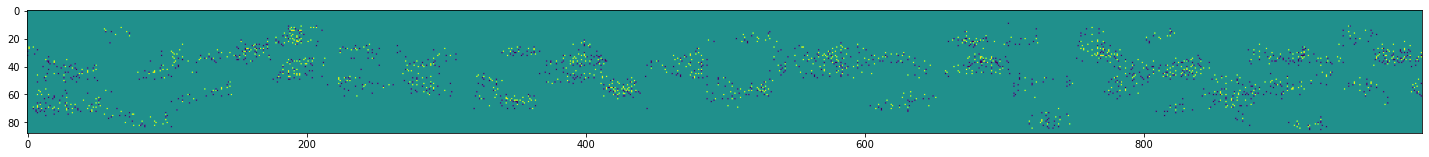

In [ ]:
music = generate_piece(z_size = 200)

## **Post Processing Data**

**Now**, we would like to convert the generated image into **real music!**
To do so, we would inverse the process we have done in the pre-processing section.

We ignore some of the notes that do not meet the criteria for proper note representation, as defined at the beginning of the project.

In [ ]:
def build_events_from_image(note_image):
  smallest_unit = (1/12)
  events=[]
  print(np.shape(note_image))
  for j in range(np.shape(note_image)[1]-1):
    for i in range(np.shape(note_image)[0]-1):#20,60):#
      if note_image[i,j] == 1:
        count = 1
        while ((note_image[i,j+count] == -1) and ((j+count) < np.shape(note_image)[1] - 1)):
          count += 1
        events.append([int(21+i),j,count])
  print (events)
  return events

**We would use MIDI** interface to convert the notes events into an audio file

In [ ]:
def create_midi(note_image, file_name):
  note_events = build_events_from_image(note_image)
  # create your MIDI object
  mf = MIDIFile(1)     # only 1 track
  track = 0   # the only track

  time = 0    # start at the beginning
  mf.addTrackName(track, time, "Sample Track")
  mf.addTempo(track, time, 120*2)

  # add some notes
  channel = 0
  volume = 100

  for event in note_events:
    mf.addNote(track, channel, event[0], event[1], event[2], volume) #(track, channel, pitch, time, duration, volume)

  # write it to disk
  with open(drive_path + file_name + ".mid", 'wb') as outf:
      mf.writeFile(outf)

In [ ]:
midi_file = create_midi(music[0,0,:,1500:1700],"ChopinAI_3")
# play_midi(midi_file)

torch.Size([88, 200])
[[73, 0, 1], [74, 0, 1], [77, 0, 1], [75, 1, 1], [77, 2, 1], [69, 3, 1], [72, 3, 1], [68, 5, 1], [72, 5, 1], [75, 5, 1], [55, 8, 1], [71, 8, 1], [78, 9, 1], [52, 11, 1], [101, 11, 1], [55, 12, 1], [52, 14, 1], [55, 17, 1], [102, 19, 2], [49, 20, 1], [52, 23, 1], [100, 23, 1], [101, 23, 1], [53, 24, 1], [54, 27, 1], [100, 27, 1], [54, 29, 1], [96, 29, 1], [99, 29, 1], [105, 30, 1], [51, 31, 1], [68, 32, 1], [58, 35, 1], [61, 35, 1], [67, 35, 1], [71, 35, 1], [56, 36, 1], [59, 36, 1], [72, 36, 1], [75, 36, 1], [78, 36, 1], [76, 37, 1], [60, 38, 1], [64, 39, 1], [74, 39, 1], [68, 40, 1], [72, 41, 1], [73, 44, 1], [81, 44, 2], [57, 47, 1], [69, 47, 1], [77, 50, 1], [60, 51, 1], [67, 52, 1], [68, 55, 1], [71, 55, 1], [41, 59, 1], [50, 61, 1], [43, 62, 1], [52, 62, 1], [47, 63, 1], [42, 67, 2], [49, 68, 1], [40, 71, 1], [41, 71, 1], [48, 71, 1], [52, 71, 1], [55, 71, 1], [44, 72, 1], [53, 72, 1], [40, 75, 1], [59, 75, 1], [36, 77, 1], [39, 77, 1], [54, 77, 1], [55, 77, 

**Attached here is a link to three short segments of generated pieces -**

[Link To Google Drive, For Playing - Just Click The Piece](https://drive.google.com/drive/folders/1BUJoxlYmBFhOqZ3IFOEnM8YME0_mSoO3?usp=sharing)

## **Result Analysis**




In the result analysis section, we will refer to the results of our best model. The result analysis is devided into two:

* **Analysis of the dry data** (convergance, loss, inferring from the images) - 

  Looking at the images we can see that the main change is happening in the first few epochs (from not playing anything at all to playing notes at different patterns). after the few first epochs the generator start doing fine tunings, and the changes are very hard to destinguish from the image (the images shown are only a portion of the full piece).

  Another thing we can observe is that the training process for the one-hot represantation did not seem to work. 
From the images presented during the process, while it is hard to inference anything regarding the chords movment, it easier to notice that the hands fails to change location from one image to the other and practicly we only get a random placing of them at the begining.

  However, we still do see convergance and changes in the images due to the convolutional networks, therefore, we chose to leave it as is to show more complex ideas we had along the way. This part of the model still needs work and we would apreciate your input on ways to impliment this idea correctly for farther research.


* **subjactive input** (Verification of the postprocessing of the images by listening) - 

  During this project, processing the results and listening to them was a big part of planing our model architecture and inferencing it's affect oncthe composed piece. After listening to varias different versions of our output, even though it is very hard to mistake one of our pieces with real classical music we are very pleased with our result. 
  
  On our first attempts we got many notes at once, no noticable patterns and no correlation between one note to the other. 
  
  Now, while listening we can recognized reoccuring patterns of rythem, correlation between low pitch and high pitch notes, and some interesting notes movments. 
  
  Another conclusion we got is that focusing on specific areas with our hands model was a good idea even if it is set from the very first epoch, with the hands models our generated pieces are focused, softer and not swamped with notes.






# **Benchmark**
Our main goal was to get better result then the relevant solutions / idea's we found on Kaggle ([link1](https://www.kaggle.com/code/risiris/audio-generation-using-neural-net#Conclusion)[4], [link2](https://www.kaggle.com/code/smogomes/music-generation-based-on-classics#5.-Models-evaluation-%F0%9F%93%9D)[5], [link3](https://www.kaggle.com/code/accountstatus/audio-generation-using-neural-net#First-Step-Creating-Data-For-Our-Model)[6]). 

The data we found does not come from a competition, so after a search we found several relevant projects, where one of the projects uses a GAN model and the other two use an LSTM model and a linear regression model - to generate music audio.

These models generating concept is different from our implementation - what they have in common is the attempt for each note to predict the next one, this system only preduces one note at a time in oppose to our model that knows how to create more complex structures. As we explained throughout the project, we tried to implement the model in a new aproach (represantation of the notes as an image in time) this model is very different from the benchmark and in our opinion shows much better results.

We must add and say, in the benchmark section, comparing genertive models to one another is not like any other NN models. Because what is considered to sound good is subjective it is very hard to measure which model is better. For these reason we can't be bias about our implementation.

As a part of benchmark we see fit to discuss some state of the art geranative music models existing today. One of the leading models is google's 'MusicLM' model that can convert text to music. This is of course a much more sophisticated model with a much larger dataset (280,000 hours of music from different genres). From open text to time interval based text you can ask the model to generate any piece of music that can come to mind. a short [article](https://www.gadgety.co.il/305103/musiclm-by-google/)

# **Conclusion**

In conclusion, our choise to try and create a generative model posed a lot of challanges, some we mennaged to overcome, some made us reconsider our model architecture, and some still remains in progress.

Overall, even though our model might not be compiting with google, we menaged to get good learning curves and graph convergances using the GANs model. considering the small dataset we had, we mennaged to get quite an impressive result in the form of short GANs based music pieces. 

In retrospect there are some thing we might have done differently:
* We believe that due to the small dataset, diminishing the images we are trying to generate even farther, could have given us better results.
* The idea of implimenting music theory and 'humen-like' thinking (hand position and chords movment) embedded in our model gave us an advantage in many ways and assisted the learning process. However there is much to improove on this side.




This project opened a whole new world for us and we do not plan on stopping here:
* reaserching more about how to merge RNN models into our existing model in the hands, chords and rhythm blocks.
* Finding solutions to our one-hot grad obsticle and make these branches a part of the learning process.

# **Reference**

Dr. Nir Shlezinger, Introduction To Dep Learning Course, Lectures

[1] [Dr.Nir shlezinger, Intro To Deep Learning course. GAN Example - GitHub](https://gist.github.com/nirshlezinger1/9c0f27b8b77510476ba5ef81cb13c524)

[2] [Dr.Nir shlezinger, Intro To Deep Learning Course. VAE Example - GitHub](https://gist.github.com/nirshlezinger1/cfe486a177d1e7dd75067c9397594c35)

[3] [MusicNet Dataset - Kaggle](https://www.kaggle.com/datasets/imsparsh/musicnet-dataset?datasetId=1167622&searchQuery=pred)

[4] [Benchmark - Audio Generation GAN Model](https://www.kaggle.com/code/risiris/audio-generation-using-neural-net#Conclusion)

[5] [Benchmark - Audio Generation Machine Learning Model](https://www.kaggle.com/code/smogomes/music-generation-based-on-classics#4.-Models-%F0%9F%96%A5%EF%B8%8F)

[6] [Benchmark - Audio Generation Neural Network Model](https://www.kaggle.com/code/accountstatus/audio-generation-using-neural-net#First-Step-Creating-Data-For-Our-Model)